In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, SpectralNormalization, Conv1D, MaxPooling1D, Flatten, Layer
from keras import backend as K
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.constraints import Constraint
import pickle

In [2]:
import h5py

with h5py.File('test_collected_data.mat', 'r') as file:
    U = file['U'][:]
    U = np.array(U)

    Y = file['Y'][:]
    Y = np.array(Y)

In [3]:
print(U.shape)
print(Y.shape)

(20001, 2)
(20001, 2)


In [4]:
print(U.shape[0])

20001


In [5]:
# get X and y data for training and testing

U_input = list()
Y_output = list()

for i in range(U.shape[0]-1):
    if i % 5 == 0:
        U_input.append(U[i:i+5, :])
        Y_output.append(Y[i:i+5, :])

In [6]:
U_input = np.array(U_input)
print(U_input.shape)
Y_output = np.array(Y_output)
print(Y_output.shape)

(4000, 5, 2)
(4000, 5, 2)


In [7]:
print(Y_output[-1])

[[0.48259197 0.93018467]
 [0.34779566 0.87790033]
 [0.87823507 0.92530261]
 [1.28194928 1.02012353]
 [1.48795291 1.12338469]]


In [8]:
RNN_input = U_input
# RNN_input = np.concatenate((U_input, -U_input), axis=2)
print("RNN_input shape is {}".format(RNN_input.shape))

RNN_input shape is (4000, 5, 2)


In [9]:
print(RNN_input[0, :, :])
print(RNN_input[1, :, :])

[[16.19241666 15.76933193]
 [12.70894193 15.86208482]
 [19.2123671  16.62241755]
 [19.75451791 15.65793096]
 [18.4116695  14.67089197]]
[[13.0167968  16.42839002]
 [17.27902718 13.91422655]
 [12.14333843 13.49401711]
 [12.5352551  16.91193655]
 [16.09581626 15.90299875]]


In [10]:
RNN_output = Y_output
print("RNN_output shape is {}".format(RNN_output.shape))

RNN_output shape is (4000, 5, 2)


In [11]:
print(RNN_output[0, :, :])
print(RNN_output[1, :, :])

[[1.         1.        ]
 [1.22269359 1.11420623]
 [0.70290225 0.94505017]
 [0.66837481 0.90328351]
 [0.90288417 0.91432542]]
[[1.38545837 1.08183303]
 [1.02589437 0.95628583]
 [1.4512544  1.11007631]
 [1.49351371 1.15346693]
 [0.99319535 1.03252695]]


In [12]:
def check_non_negative_weights_ignore_bias(model):
    all_non_negative = True
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # tf the layer has weights
            # check only the weight matrices (ignoring biases if present)
            weight_only = weights[0]  # assume weights are the first element, bias (if any) is second
            if not np.all(weight_only >= 0):
                print(f"Non-negative check failed in layer: {layer.name}")
                all_non_negative = False
    if all_non_negative:
        print("All weights are non-negative (ignoring biases).")
    else:
        print("Some weights are negative (ignoring biases).")

In [13]:
def evaluate_lip_const(model: Model, x, eps, seed=None):
    """
    Evaluate the Lipschitz constant of a model, with the naive method.
    Please note that the estimation of the lipschitz constant is done locally around
    input sample. This may not correctly estimate the behaviour in the whole domain.

    Args:
        model: built keras model used to make predictions
        x: inputs used to compute the lipschitz constant
        eps (float): magnitude of noise to add to input in order to compute the constant
        seed (int): seed used when generating the noise ( can be set to None )

    Returns:
        float: the empirically evaluated lipschitz constant. The computation might also
            be inaccurate in high dimensional space.

    """
    y_pred = model.predict(x)
    x_var = x + K.random_uniform(
        shape=x.shape, minval=eps * 0.25, maxval=eps, seed=seed
    )
#     x_var = x + K.random_normal(
#         shape=x.shape, mean=0, stddev=eps, seed=seed
#     )
    y_pred_var = model.predict(x_var)
    dx = x - x_var
    dfx = y_pred - y_pred_var
    ndx = K.sqrt(K.sum(K.square(dx), axis=range(1, len(x.shape))))
    ndfx = K.sqrt(K.sum(K.square(dfx), axis=range(1, len(y_pred.shape))))
    lip_cst = K.max(ndfx / ndx)
    print(f"lip cst: {lip_cst:.3f}")
    return lip_cst

In [14]:
# set the seed for reproducibility
tf.random.set_seed(42)

num_step = 5
training_loss = [0]*19
test_loss = [0]*19
lip = [0]*19
noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

for i in range(19):
    num_dims = 2

    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.3, random_state=123)

    # define scalers for both X and y base on training data only
    scaler_X = preprocessing.MinMaxScaler().fit(X_train.reshape(-1, num_dims))
    scaler_y = preprocessing.MinMaxScaler().fit(y_train.reshape(-1, 2))

    X_train = scaler_X.transform(X_train.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    X_test = scaler_X.transform(X_test.reshape(-1, num_dims)).reshape(-1,num_step,num_dims)
    y_train = scaler_y.transform(y_train.reshape(-1,2)).reshape(-1,num_step,2)
    y_test_normalized = scaler_y.transform(y_test.reshape(-1,2)).reshape(-1,num_step,2)

    # X is just the initial condition, so we introduce noise to the output trajectory y
    y_train = y_train + np.random.normal(0, noise[i], y_train.shape)

    nh = 64
    input = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # LSTM
    x = LSTM(nh,
          return_sequences=True,
          )(input)
    x = LSTM(nh,
          return_sequences=True,
          )(x)
    x = Dense(2,
            activation='linear',
            )(x)

    model = Model(input, x)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
    history = model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

    training_loss[i] = history.history['val_loss'][-1]
    print(noise)
    print(training_loss)

    loss = model.evaluate(X_test, y_test_normalized, batch_size=256)
    test_loss[i] = loss[0]
    print(test_loss)

    # check convexity by checking the weights
    check_non_negative_weights_ignore_bias(model)

    # compute the Lipschitz constant for the 2-layer RNN
    lipschitz_constant = evaluate_lip_const(model, X_train, 1e-04, 42)
    print(f"Estimated Lipschitz constant of the 2-layer RNN: {lipschitz_constant}")

    lip[i] = lipschitz_constant

model.summary()

Epoch 1/1000
9/9 - 8s - loss: 0.1533 - mean_squared_error: 0.1533 - val_loss: 0.1033 - val_mean_squared_error: 0.1033 - 8s/epoch - 834ms/step
Epoch 2/1000
9/9 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.0884 - val_mean_squared_error: 0.0884 - 150ms/epoch - 17ms/step
Epoch 3/1000
9/9 - 0s - loss: 0.0788 - mean_squared_error: 0.0788 - val_loss: 0.0733 - val_mean_squared_error: 0.0733 - 151ms/epoch - 17ms/step
Epoch 4/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0662 - val_mean_squared_error: 0.0662 - 150ms/epoch - 17ms/step
Epoch 5/1000
9/9 - 0s - loss: 0.0618 - mean_squared_error: 0.0618 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - 152ms/epoch - 17ms/step
Epoch 6/1000
9/9 - 0s - loss: 0.0556 - mean_squared_error: 0.0556 - val_loss: 0.0534 - val_mean_squared_error: 0.0534 - 151ms/epoch - 17ms/step
Epoch 7/1000
9/9 - 0s - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - 151ms/epoch - 17ms

Epoch 58/1000
9/9 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 150ms/epoch - 17ms/step
Epoch 59/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - 135ms/epoch - 15ms/step
Epoch 60/1000
9/9 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 151ms/epoch - 17ms/step
Epoch 61/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 151ms/epoch - 17ms/step
Epoch 62/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 151ms/epoch - 17ms/step
Epoch 63/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 151ms/epoch - 17ms/step
Epoch 64/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - 177ms/epo

Epoch 115/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 151ms/epoch - 17ms/step
Epoch 116/1000
9/9 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 150ms/epoch - 17ms/step
Epoch 117/1000
9/9 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 150ms/epoch - 17ms/step
Epoch 118/1000
9/9 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 144ms/epoch - 16ms/step
Epoch 119/1000
9/9 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 148ms/epoch - 16ms/step
Epoch 120/1000
9/9 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 135ms/epoch - 15ms/step
Epoch 121/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 15

Epoch 172/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 141ms/epoch - 16ms/step
Epoch 173/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 156ms/epoch - 17ms/step
Epoch 174/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 125ms/epoch - 14ms/step
Epoch 175/1000
9/9 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 125ms/epoch - 14ms/step
Epoch 176/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 157ms/epoch - 17ms/step
Epoch 177/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 143ms/epoch - 16ms/step
Epoch 178/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 13

Epoch 229/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 150ms/epoch - 17ms/step
Epoch 230/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 164ms/epoch - 18ms/step
Epoch 231/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 232/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 144ms/epoch - 16ms/step
Epoch 233/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 156ms/epoch - 17ms/step
Epoch 234/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 171ms/epoch - 19ms/step
Epoch 235/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 15

Epoch 286/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 165ms/epoch - 18ms/step
Epoch 287/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 288/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 289/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 152ms/epoch - 17ms/step
Epoch 290/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 163ms/epoch - 18ms/step
Epoch 291/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 149ms/epoch - 17ms/step
Epoch 292/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 15

Epoch 343/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 344/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 133ms/epoch - 15ms/step
Epoch 345/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 155ms/epoch - 17ms/step
Epoch 346/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 140ms/epoch - 16ms/step
Epoch 347/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 157ms/epoch - 17ms/step
Epoch 348/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 165ms/epoch - 18ms/step
Epoch 349/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 16

Epoch 400/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 159ms/epoch - 18ms/step
Epoch 401/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 144ms/epoch - 16ms/step
Epoch 402/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 157ms/epoch - 17ms/step
Epoch 403/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 163ms/epoch - 18ms/step
Epoch 404/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 138ms/epoch - 15ms/step
Epoch 405/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 166ms/epoch - 18ms/step
Epoch 406/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 15

Epoch 457/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 458/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 459/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 146ms/epoch - 16ms/step
Epoch 460/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 155ms/epoch - 17ms/step
Epoch 461/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 167ms/epoch - 19ms/step
Epoch 462/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 136ms/epoch - 15ms/step
Epoch 463/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 13

Epoch 514/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 163ms/epoch - 18ms/step
Epoch 515/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 140ms/epoch - 16ms/step
Epoch 516/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 148ms/epoch - 16ms/step
Epoch 517/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 135ms/epoch - 15ms/step
Epoch 518/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 149ms/epoch - 17ms/step
Epoch 519/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 149ms/epoch - 17ms/step
Epoch 520/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 15

Epoch 571/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 165ms/epoch - 18ms/step
Epoch 572/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 573/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 163ms/epoch - 18ms/step
Epoch 574/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 145ms/epoch - 16ms/step
Epoch 575/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 144ms/epoch - 16ms/step
Epoch 576/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 146ms/epoch - 16ms/step
Epoch 577/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 17

Epoch 628/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 168ms/epoch - 19ms/step
Epoch 629/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 154ms/epoch - 17ms/step
Epoch 630/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 164ms/epoch - 18ms/step
Epoch 631/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 161ms/epoch - 18ms/step
Epoch 632/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 165ms/epoch - 18ms/step
Epoch 633/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 149ms/epoch - 17ms/step
Epoch 634/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 15

Epoch 685/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - 135ms/epoch - 15ms/step
Epoch 686/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 143ms/epoch - 16ms/step
Epoch 687/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 134ms/epoch - 15ms/step
Epoch 688/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 150ms/epoch - 17ms/step
Epoch 689/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 149ms/epoch - 17ms/step
Epoch 690/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 135ms/epoch - 15ms/step
Epoch 691/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 13

Epoch 742/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 161ms/epoch - 18ms/step
Epoch 743/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 153ms/epoch - 17ms/step
Epoch 744/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 155ms/epoch - 17ms/step
Epoch 745/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 155ms/epoch - 17ms/step
Epoch 746/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 151ms/epoch - 17ms/step
Epoch 747/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 157ms/epoch - 17ms/step
Epoch 748/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 15

Epoch 799/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 800/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 170ms/epoch - 19ms/step
Epoch 801/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 171ms/epoch - 19ms/step
Epoch 802/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 152ms/epoch - 17ms/step
Epoch 803/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 152ms/epoch - 17ms/step
Epoch 804/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 152ms/epoch - 17ms/step
Epoch 805/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 14

Epoch 856/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 166ms/epoch - 18ms/step
Epoch 857/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 149ms/epoch - 17ms/step
Epoch 858/1000
9/9 - 0s - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 859/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 150ms/epoch - 17ms/step
Epoch 860/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 167ms/epoch - 19ms/step
Epoch 861/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 159ms/epoch - 18ms/step
Epoch 862/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 14

Epoch 913/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - 164ms/epoch - 18ms/step
Epoch 914/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 151ms/epoch - 17ms/step
Epoch 915/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 148ms/epoch - 16ms/step
Epoch 916/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 159ms/epoch - 18ms/step
Epoch 917/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 155ms/epoch - 17ms/step
Epoch 918/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 157ms/epoch - 17ms/step
Epoch 919/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 14

Epoch 970/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 148ms/epoch - 16ms/step
Epoch 971/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 148ms/epoch - 16ms/step
Epoch 972/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 157ms/epoch - 17ms/step
Epoch 973/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 157ms/epoch - 17ms/step
Epoch 974/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 160ms/epoch - 18ms/step
Epoch 975/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 139ms/epoch - 15ms/step
Epoch 976/1000
9/9 - 0s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 13

Epoch 22/1000
9/9 - 0s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - 140ms/epoch - 16ms/step
Epoch 23/1000
9/9 - 0s - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - 146ms/epoch - 16ms/step
Epoch 24/1000
9/9 - 0s - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - 125ms/epoch - 14ms/step
Epoch 25/1000
9/9 - 0s - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - 132ms/epoch - 15ms/step
Epoch 26/1000
9/9 - 0s - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - 127ms/epoch - 14ms/step
Epoch 27/1000
9/9 - 0s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - 140ms/epoch - 16ms/step
Epoch 28/1000
9/9 - 0s - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - 144ms/epo

Epoch 79/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 145ms/epoch - 16ms/step
Epoch 80/1000
9/9 - 0s - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 144ms/epoch - 16ms/step
Epoch 81/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 160ms/epoch - 18ms/step
Epoch 82/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - 142ms/epoch - 16ms/step
Epoch 83/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 152ms/epoch - 17ms/step
Epoch 84/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - 147ms/epoch - 16ms/step
Epoch 85/1000
9/9 - 0s - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 140ms/epo

Epoch 136/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 152ms/epoch - 17ms/step
Epoch 137/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 152ms/epoch - 17ms/step
Epoch 138/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 150ms/epoch - 17ms/step
Epoch 139/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 140ms/epoch - 16ms/step
Epoch 140/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 138ms/epoch - 15ms/step
Epoch 141/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 150ms/epoch - 17ms/step
Epoch 142/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 15

Epoch 193/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 136ms/epoch - 15ms/step
Epoch 194/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 137ms/epoch - 15ms/step
Epoch 195/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 151ms/epoch - 17ms/step
Epoch 196/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 132ms/epoch - 15ms/step
Epoch 197/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 144ms/epoch - 16ms/step
Epoch 198/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 152ms/epoch - 17ms/step
Epoch 199/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 13

Epoch 250/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 139ms/epoch - 15ms/step
Epoch 251/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 143ms/epoch - 16ms/step
Epoch 252/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 152ms/epoch - 17ms/step
Epoch 253/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 152ms/epoch - 17ms/step
Epoch 254/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 148ms/epoch - 16ms/step
Epoch 255/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 142ms/epoch - 16ms/step
Epoch 256/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 13

Epoch 307/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 151ms/epoch - 17ms/step
Epoch 308/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 169ms/epoch - 19ms/step
Epoch 309/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 151ms/epoch - 17ms/step
Epoch 310/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 151ms/epoch - 17ms/step
Epoch 311/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 167ms/epoch - 19ms/step
Epoch 312/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 169ms/epoch - 19ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 15

Epoch 364/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 365/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 136ms/epoch - 15ms/step
Epoch 366/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 140ms/epoch - 16ms/step
Epoch 367/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 135ms/epoch - 15ms/step
Epoch 368/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 128ms/epoch - 14ms/step
Epoch 369/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 370/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 13

Epoch 421/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 138ms/epoch - 15ms/step
Epoch 422/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 151ms/epoch - 17ms/step
Epoch 423/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 149ms/epoch - 17ms/step
Epoch 424/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 140ms/epoch - 16ms/step
Epoch 425/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 139ms/epoch - 15ms/step
Epoch 426/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 427/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 15

Epoch 478/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 157ms/epoch - 17ms/step
Epoch 479/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 147ms/epoch - 16ms/step
Epoch 480/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 136ms/epoch - 15ms/step
Epoch 481/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 138ms/epoch - 15ms/step
Epoch 482/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 149ms/epoch - 17ms/step
Epoch 483/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 484/1000
9/9 - 0s - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 15

Epoch 535/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 141ms/epoch - 16ms/step
Epoch 536/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 144ms/epoch - 16ms/step
Epoch 537/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 154ms/epoch - 17ms/step
Epoch 538/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 135ms/epoch - 15ms/step
Epoch 539/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 162ms/epoch - 18ms/step
Epoch 540/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 143ms/epoch - 16ms/step
Epoch 541/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 13

Epoch 592/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 140ms/epoch - 16ms/step
Epoch 593/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 594/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 153ms/epoch - 17ms/step
Epoch 595/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 150ms/epoch - 17ms/step
Epoch 596/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 144ms/epoch - 16ms/step
Epoch 597/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 143ms/epoch - 16ms/step
Epoch 598/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 13

Epoch 649/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 153ms/epoch - 17ms/step
Epoch 650/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 151ms/epoch - 17ms/step
Epoch 651/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 156ms/epoch - 17ms/step
Epoch 652/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 143ms/epoch - 16ms/step
Epoch 653/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 146ms/epoch - 16ms/step
Epoch 654/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 129ms/epoch - 14ms/step
Epoch 655/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 15

Epoch 706/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 106ms/epoch - 12ms/step
Epoch 707/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 119ms/epoch - 13ms/step
Epoch 708/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 135ms/epoch - 15ms/step
Epoch 709/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 152ms/epoch - 17ms/step
Epoch 710/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 143ms/epoch - 16ms/step
Epoch 711/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 150ms/epoch - 17ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 14

Epoch 763/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 130ms/epoch - 14ms/step
Epoch 764/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 151ms/epoch - 17ms/step
Epoch 765/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 155ms/epoch - 17ms/step
Epoch 766/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 144ms/epoch - 16ms/step
Epoch 767/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 147ms/epoch - 16ms/step
Epoch 768/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 147ms/epoch - 16ms/step
Epoch 769/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 15

Epoch 820/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 145ms/epoch - 16ms/step
Epoch 821/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 147ms/epoch - 16ms/step
Epoch 822/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 145ms/epoch - 16ms/step
Epoch 823/1000
9/9 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 151ms/epoch - 17ms/step
Epoch 824/1000
9/9 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 149ms/epoch - 17ms/step
Epoch 825/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 140ms/epoch - 16ms/step
Epoch 826/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 15

Epoch 877/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 135ms/epoch - 15ms/step
Epoch 878/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 152ms/epoch - 17ms/step
Epoch 879/1000
9/9 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 157ms/epoch - 17ms/step
Epoch 880/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 150ms/epoch - 17ms/step
Epoch 881/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 136ms/epoch - 15ms/step
Epoch 882/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 151ms/epoch - 17ms/step
Epoch 883/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 15

Epoch 934/1000
9/9 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 142ms/epoch - 16ms/step
Epoch 935/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 148ms/epoch - 16ms/step
Epoch 936/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 153ms/epoch - 17ms/step
Epoch 937/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 153ms/epoch - 17ms/step
Epoch 938/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 151ms/epoch - 17ms/step
Epoch 939/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 154ms/epoch - 17ms/step
Epoch 940/1000
9/9 - 0s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 13

Epoch 991/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 136ms/epoch - 15ms/step
Epoch 992/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 140ms/epoch - 16ms/step
Epoch 993/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - 148ms/epoch - 16ms/step
Epoch 994/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 137ms/epoch - 15ms/step
Epoch 995/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - 167ms/epoch - 19ms/step
Epoch 996/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 166ms/epoch - 18ms/step
Epoch 997/1000
9/9 - 0s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - 14

Epoch 43/1000
9/9 - 0s - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - 139ms/epoch - 15ms/step
Epoch 44/1000
9/9 - 0s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - 155ms/epoch - 17ms/step
Epoch 45/1000
9/9 - 0s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 152ms/epoch - 17ms/step
Epoch 46/1000
9/9 - 0s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 137ms/epoch - 15ms/step
Epoch 47/1000
9/9 - 0s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 152ms/epoch - 17ms/step
Epoch 48/1000
9/9 - 0s - loss: 0.0165 - mean_squared_error: 0.0165 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - 155ms/epoch - 17ms/step
Epoch 49/1000
9/9 - 0s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 136ms/epo

Epoch 100/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 146ms/epoch - 16ms/step
Epoch 101/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 135ms/epoch - 15ms/step
Epoch 102/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 144ms/epoch - 16ms/step
Epoch 103/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 151ms/epoch - 17ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 135ms/epoch - 15ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 165ms/epoch - 18ms/step
Epoch 106/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 15

Epoch 157/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 154ms/epoch - 17ms/step
Epoch 158/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 153ms/epoch - 17ms/step
Epoch 159/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 145ms/epoch - 16ms/step
Epoch 160/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 160ms/epoch - 18ms/step
Epoch 161/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 132ms/epoch - 15ms/step
Epoch 162/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 128ms/epoch - 14ms/step
Epoch 163/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 13

Epoch 214/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 152ms/epoch - 17ms/step
Epoch 215/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 153ms/epoch - 17ms/step
Epoch 216/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 136ms/epoch - 15ms/step
Epoch 217/1000
9/9 - 0s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 153ms/epoch - 17ms/step
Epoch 218/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 137ms/epoch - 15ms/step
Epoch 219/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 142ms/epoch - 16ms/step
Epoch 220/1000
9/9 - 0s - loss: 0.0162 - mean_squared_error: 0.0162 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 14

Epoch 271/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 149ms/epoch - 17ms/step
Epoch 272/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 117ms/epoch - 13ms/step
Epoch 273/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 125ms/epoch - 14ms/step
Epoch 274/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 141ms/epoch - 16ms/step
Epoch 275/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 125ms/epoch - 14ms/step
Epoch 276/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 141ms/epoch - 16ms/step
Epoch 277/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 15

Epoch 328/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 138ms/epoch - 15ms/step
Epoch 329/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 150ms/epoch - 17ms/step
Epoch 330/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 151ms/epoch - 17ms/step
Epoch 331/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 135ms/epoch - 15ms/step
Epoch 332/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 166ms/epoch - 18ms/step
Epoch 333/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 334/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 15

Epoch 385/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 141ms/epoch - 16ms/step
Epoch 386/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 149ms/epoch - 17ms/step
Epoch 387/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 152ms/epoch - 17ms/step
Epoch 388/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 389/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 150ms/epoch - 17ms/step
Epoch 390/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 152ms/epoch - 17ms/step
Epoch 391/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 16

Epoch 442/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 152ms/epoch - 17ms/step
Epoch 443/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 444/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 142ms/epoch - 16ms/step
Epoch 445/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 143ms/epoch - 16ms/step
Epoch 446/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 148ms/epoch - 16ms/step
Epoch 447/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 138ms/epoch - 15ms/step
Epoch 448/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 15

Epoch 499/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 151ms/epoch - 17ms/step
Epoch 500/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 501/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 157ms/epoch - 17ms/step
Epoch 502/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 140ms/epoch - 16ms/step
Epoch 503/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 166ms/epoch - 18ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 150ms/epoch - 17ms/step
Epoch 505/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 13

Epoch 556/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 146ms/epoch - 16ms/step
Epoch 557/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 123ms/epoch - 14ms/step
Epoch 558/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 559/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 143ms/epoch - 16ms/step
Epoch 560/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 133ms/epoch - 15ms/step
Epoch 561/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 562/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 15

Epoch 613/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 151ms/epoch - 17ms/step
Epoch 614/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 157ms/epoch - 17ms/step
Epoch 615/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 145ms/epoch - 16ms/step
Epoch 616/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 135ms/epoch - 15ms/step
Epoch 617/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - 150ms/epoch - 17ms/step
Epoch 618/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 147ms/epoch - 16ms/step
Epoch 619/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 14

Epoch 670/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 151ms/epoch - 17ms/step
Epoch 671/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 148ms/epoch - 16ms/step
Epoch 672/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 144ms/epoch - 16ms/step
Epoch 673/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 141ms/epoch - 16ms/step
Epoch 674/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 146ms/epoch - 16ms/step
Epoch 675/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 142ms/epoch - 16ms/step
Epoch 676/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 15

Epoch 727/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 132ms/epoch - 15ms/step
Epoch 728/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 142ms/epoch - 16ms/step
Epoch 729/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 147ms/epoch - 16ms/step
Epoch 730/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 144ms/epoch - 16ms/step
Epoch 731/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 123ms/epoch - 14ms/step
Epoch 732/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 132ms/epoch - 15ms/step
Epoch 733/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 13

Epoch 784/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 127ms/epoch - 14ms/step
Epoch 785/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 130ms/epoch - 14ms/step
Epoch 786/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 130ms/epoch - 14ms/step
Epoch 787/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 135ms/epoch - 15ms/step
Epoch 788/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 123ms/epoch - 14ms/step
Epoch 789/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - 133ms/epoch - 15ms/step
Epoch 790/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 13

Epoch 841/1000
9/9 - 0s - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 136ms/epoch - 15ms/step
Epoch 842/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 127ms/epoch - 14ms/step
Epoch 843/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 128ms/epoch - 14ms/step
Epoch 844/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 125ms/epoch - 14ms/step
Epoch 845/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 124ms/epoch - 14ms/step
Epoch 846/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 116ms/epoch - 13ms/step
Epoch 847/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 13

Epoch 898/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 134ms/epoch - 15ms/step
Epoch 899/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 133ms/epoch - 15ms/step
Epoch 900/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 133ms/epoch - 15ms/step
Epoch 901/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 119ms/epoch - 13ms/step
Epoch 902/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 118ms/epoch - 13ms/step
Epoch 903/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - 119ms/epoch - 13ms/step
Epoch 904/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 13

Epoch 955/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 119ms/epoch - 13ms/step
Epoch 956/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 125ms/epoch - 14ms/step
Epoch 957/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 121ms/epoch - 13ms/step
Epoch 958/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 134ms/epoch - 15ms/step
Epoch 959/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 134ms/epoch - 15ms/step
Epoch 960/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 118ms/epoch - 13ms/step
Epoch 961/1000
9/9 - 0s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - 13

Epoch 6/1000
9/9 - 0s - loss: 0.0795 - mean_squared_error: 0.0795 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - 179ms/epoch - 20ms/step
Epoch 7/1000
9/9 - 0s - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - 200ms/epoch - 22ms/step
Epoch 8/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 203ms/epoch - 23ms/step
Epoch 9/1000
9/9 - 0s - loss: 0.0646 - mean_squared_error: 0.0646 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - 215ms/epoch - 24ms/step
Epoch 10/1000
9/9 - 0s - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - 202ms/epoch - 22ms/step
Epoch 11/1000
9/9 - 0s - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 0.0576 - val_mean_squared_error: 0.0576 - 214ms/epoch - 24ms/step
Epoch 12/1000
9/9 - 0s - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.0548 - val_mean_squared_error: 0.0548 - 224ms/epoch -

Epoch 63/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 217ms/epoch - 24ms/step
Epoch 64/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 199ms/epoch - 22ms/step
Epoch 65/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 195ms/epoch - 22ms/step
Epoch 66/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 195ms/epoch - 22ms/step
Epoch 67/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 196ms/epoch - 22ms/step
Epoch 68/1000
9/9 - 0s - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 217ms/epoch - 24ms/step
Epoch 69/1000
9/9 - 0s - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 182ms/epo

Epoch 120/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 205ms/epoch - 23ms/step
Epoch 121/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 195ms/epoch - 22ms/step
Epoch 122/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 202ms/epoch - 22ms/step
Epoch 123/1000
9/9 - 0s - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 213ms/epoch - 24ms/step
Epoch 124/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 197ms/epoch - 22ms/step
Epoch 125/1000
9/9 - 0s - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 204ms/epoch - 23ms/step
Epoch 126/1000
9/9 - 0s - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 19

Epoch 177/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 213ms/epoch - 24ms/step
Epoch 178/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 187ms/epoch - 21ms/step
Epoch 179/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 219ms/epoch - 24ms/step
Epoch 180/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 211ms/epoch - 23ms/step
Epoch 181/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 209ms/epoch - 23ms/step
Epoch 182/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 189ms/epoch - 21ms/step
Epoch 183/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 21

Epoch 234/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 235/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 236/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 237/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 156ms/epoch - 17ms/step
Epoch 238/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 156ms/epoch - 17ms/step
Epoch 239/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 240/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 17

Epoch 291/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 187ms/epoch - 21ms/step
Epoch 292/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 176ms/epoch - 20ms/step
Epoch 293/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 152ms/epoch - 17ms/step
Epoch 294/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 234ms/epoch - 26ms/step
Epoch 295/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 250ms/epoch - 28ms/step
Epoch 296/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 297/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 17

Epoch 348/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 203ms/epoch - 23ms/step
Epoch 349/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 250ms/epoch - 28ms/step
Epoch 350/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 351/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 263ms/epoch - 29ms/step
Epoch 352/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 156ms/epoch - 17ms/step
Epoch 353/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 219ms/epoch - 24ms/step
Epoch 354/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 17

Epoch 405/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 156ms/epoch - 17ms/step
Epoch 406/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 407/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 234ms/epoch - 26ms/step
Epoch 408/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 313ms/epoch - 35ms/step
Epoch 409/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 187ms/epoch - 21ms/step
Epoch 410/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 411/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 21

Epoch 462/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 187ms/epoch - 21ms/step
Epoch 463/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 464/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 465/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 266ms/epoch - 30ms/step
Epoch 466/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 467/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 468/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 17

Epoch 519/1000
9/9 - 0s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 520/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 521/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 522/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 188ms/epoch - 21ms/step
Epoch 523/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 234ms/epoch - 26ms/step
Epoch 524/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 156ms/epoch - 17ms/step
Epoch 525/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 18

Epoch 576/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 577/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 578/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 219ms/epoch - 24ms/step
Epoch 579/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 580/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 581/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 582/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 15

Epoch 633/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 187ms/epoch - 21ms/step
Epoch 634/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 141ms/epoch - 16ms/step
Epoch 635/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 636/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 637/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 203ms/epoch - 23ms/step
Epoch 638/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 639/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 17

Epoch 690/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - 172ms/epoch - 19ms/step
Epoch 691/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 692/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 693/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 156ms/epoch - 17ms/step
Epoch 694/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 203ms/epoch - 23ms/step
Epoch 695/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 266ms/epoch - 30ms/step
Epoch 696/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 17

Epoch 747/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 748/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 234ms/epoch - 26ms/step
Epoch 749/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 210ms/epoch - 23ms/step
Epoch 750/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 165ms/epoch - 18ms/step
Epoch 751/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 752/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 753/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 17

Epoch 804/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 805/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 187ms/epoch - 21ms/step
Epoch 806/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 807/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 156ms/epoch - 17ms/step
Epoch 808/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 809/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 312ms/epoch - 35ms/step
Epoch 810/1000
9/9 - 0s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 15

Epoch 861/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 187ms/epoch - 21ms/step
Epoch 862/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 863/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 188ms/epoch - 21ms/step
Epoch 864/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 865/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 234ms/epoch - 26ms/step
Epoch 866/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 331ms/epoch - 37ms/step
Epoch 867/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 26

Epoch 918/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - 172ms/epoch - 19ms/step
Epoch 919/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 234ms/epoch - 26ms/step
Epoch 920/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 156ms/epoch - 17ms/step
Epoch 921/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 172ms/epoch - 19ms/step
Epoch 922/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 923/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 188ms/epoch - 21ms/step
Epoch 924/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 23

Epoch 975/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - 156ms/epoch - 17ms/step
Epoch 976/1000
9/9 - 0s - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 328ms/epoch - 36ms/step
Epoch 977/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 203ms/epoch - 23ms/step
Epoch 978/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - 172ms/epoch - 19ms/step
Epoch 979/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 172ms/epoch - 19ms/step
Epoch 980/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - 172ms/epoch - 19ms/step
Epoch 981/1000
9/9 - 0s - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - 15

Epoch 26/1000
9/9 - 0s - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0468 - val_mean_squared_error: 0.0468 - 281ms/epoch - 31ms/step
Epoch 27/1000
9/9 - 0s - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - 156ms/epoch - 17ms/step
Epoch 28/1000
9/9 - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 187ms/epoch - 21ms/step
Epoch 29/1000
9/9 - 0s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0461 - val_mean_squared_error: 0.0461 - 187ms/epoch - 21ms/step
Epoch 30/1000
9/9 - 0s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - 297ms/epoch - 33ms/step
Epoch 31/1000
9/9 - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - 203ms/epoch - 23ms/step
Epoch 32/1000
9/9 - 0s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0459 - val_mean_squared_error: 0.0459 - 203ms/epo

Epoch 83/1000
9/9 - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 297ms/epoch - 33ms/step
Epoch 84/1000
9/9 - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 359ms/epoch - 40ms/step
Epoch 85/1000
9/9 - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 250ms/epoch - 28ms/step
Epoch 86/1000
9/9 - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 156ms/epoch - 17ms/step
Epoch 87/1000
9/9 - 0s - loss: 0.0461 - mean_squared_error: 0.0461 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 313ms/epoch - 35ms/step
Epoch 88/1000
9/9 - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 234ms/epoch - 26ms/step
Epoch 89/1000
9/9 - 0s - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 328ms/epo

Epoch 140/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 187ms/epoch - 21ms/step
Epoch 141/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 141ms/epoch - 16ms/step
Epoch 142/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 266ms/epoch - 30ms/step
Epoch 143/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 328ms/epoch - 36ms/step
Epoch 144/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 172ms/epoch - 19ms/step
Epoch 145/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 219ms/epoch - 24ms/step
Epoch 146/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 26

Epoch 197/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 200ms/epoch - 22ms/step
Epoch 198/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 184ms/epoch - 20ms/step
Epoch 199/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - 167ms/epoch - 19ms/step
Epoch 200/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 136ms/epoch - 15ms/step
Epoch 201/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 127ms/epoch - 14ms/step
Epoch 202/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 117ms/epoch - 13ms/step
Epoch 203/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 15

Epoch 254/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 125ms/epoch - 14ms/step
Epoch 255/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 131ms/epoch - 15ms/step
Epoch 256/1000
9/9 - 0s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 140ms/epoch - 16ms/step
Epoch 257/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0448 - val_mean_squared_error: 0.0448 - 123ms/epoch - 14ms/step
Epoch 258/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 139ms/epoch - 15ms/step
Epoch 259/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 125ms/epoch - 14ms/step
Epoch 260/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 12

Epoch 311/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 119ms/epoch - 13ms/step
Epoch 312/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 124ms/epoch - 14ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 117ms/epoch - 13ms/step
Epoch 314/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 117ms/epoch - 13ms/step
Epoch 315/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 114ms/epoch - 13ms/step
Epoch 316/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 117ms/epoch - 13ms/step
Epoch 317/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 11

Epoch 368/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 109ms/epoch - 12ms/step
Epoch 369/1000
9/9 - 0s - loss: 0.0459 - mean_squared_error: 0.0459 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 141ms/epoch - 16ms/step
Epoch 370/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 111ms/epoch - 12ms/step
Epoch 371/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 125ms/epoch - 14ms/step
Epoch 372/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 142ms/epoch - 16ms/step
Epoch 373/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 125ms/epoch - 14ms/step
Epoch 374/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 12

Epoch 425/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 131ms/epoch - 15ms/step
Epoch 426/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 125ms/epoch - 14ms/step
Epoch 427/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 158ms/epoch - 18ms/step
Epoch 428/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 143ms/epoch - 16ms/step
Epoch 429/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - 151ms/epoch - 17ms/step
Epoch 430/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 141ms/epoch - 16ms/step
Epoch 431/1000
9/9 - 0s - loss: 0.0458 - mean_squared_error: 0.0458 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 12

Epoch 482/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 143ms/epoch - 16ms/step
Epoch 483/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 129ms/epoch - 14ms/step
Epoch 484/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 140ms/epoch - 16ms/step
Epoch 485/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 130ms/epoch - 14ms/step
Epoch 486/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 125ms/epoch - 14ms/step
Epoch 487/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 129ms/epoch - 14ms/step
Epoch 488/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 14

Epoch 539/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 137ms/epoch - 15ms/step
Epoch 540/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 135ms/epoch - 15ms/step
Epoch 541/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 138ms/epoch - 15ms/step
Epoch 542/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0450 - val_mean_squared_error: 0.0450 - 140ms/epoch - 16ms/step
Epoch 543/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 148ms/epoch - 16ms/step
Epoch 544/1000
9/9 - 0s - loss: 0.0457 - mean_squared_error: 0.0457 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 146ms/epoch - 16ms/step
Epoch 545/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 14

Epoch 596/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 146ms/epoch - 16ms/step
Epoch 597/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 133ms/epoch - 15ms/step
Epoch 598/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 126ms/epoch - 14ms/step
Epoch 599/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 142ms/epoch - 16ms/step
Epoch 600/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 141ms/epoch - 16ms/step
Epoch 601/1000
9/9 - 0s - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - 132ms/epoch - 15ms/step
Epoch 602/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 13

Epoch 653/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 137ms/epoch - 15ms/step
Epoch 654/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 148ms/epoch - 16ms/step
Epoch 655/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 142ms/epoch - 16ms/step
Epoch 656/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - 133ms/epoch - 15ms/step
Epoch 657/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 140ms/epoch - 16ms/step
Epoch 658/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 132ms/epoch - 15ms/step
Epoch 659/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 14

Epoch 710/1000
9/9 - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 141ms/epoch - 16ms/step
Epoch 711/1000
9/9 - 0s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 145ms/epoch - 16ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - 152ms/epoch - 17ms/step
Epoch 713/1000
9/9 - 0s - loss: 0.0454 - mean_squared_error: 0.0454 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - 134ms/epoch - 15ms/step
Epoch 714/1000
9/9 - 0s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - 141ms/epoch - 16ms/step
Epoch 715/1000
9/9 - 0s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - 157ms/epoch - 17ms/step
Epoch 716/1000
9/9 - 0s - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - 15

Epoch 767/1000
9/9 - 0s - loss: 0.0452 - mean_squared_error: 0.0452 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 136ms/epoch - 15ms/step
Epoch 768/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 132ms/epoch - 15ms/step
Epoch 769/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 134ms/epoch - 15ms/step
Epoch 770/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0454 - val_mean_squared_error: 0.0454 - 127ms/epoch - 14ms/step
Epoch 771/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - 138ms/epoch - 15ms/step
Epoch 772/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 125ms/epoch - 14ms/step
Epoch 773/1000
9/9 - 0s - loss: 0.0451 - mean_squared_error: 0.0451 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - 15

Epoch 824/1000
9/9 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 110ms/epoch - 12ms/step
Epoch 825/1000
9/9 - 0s - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 141ms/epoch - 16ms/step
Epoch 826/1000
9/9 - 0s - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - 125ms/epoch - 14ms/step
Epoch 827/1000
9/9 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - 125ms/epoch - 14ms/step
Epoch 828/1000
9/9 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 127ms/epoch - 14ms/step
Epoch 829/1000
9/9 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - 140ms/epoch - 16ms/step
Epoch 830/1000
9/9 - 0s - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0460 - val_mean_squared_error: 0.0460 - 12

Epoch 881/1000
9/9 - 0s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 141ms/epoch - 16ms/step
Epoch 882/1000
9/9 - 0s - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 110ms/epoch - 12ms/step
Epoch 883/1000
9/9 - 0s - loss: 0.0445 - mean_squared_error: 0.0445 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - 126ms/epoch - 14ms/step
Epoch 884/1000
9/9 - 0s - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - 126ms/epoch - 14ms/step
Epoch 885/1000
9/9 - 0s - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - 126ms/epoch - 14ms/step
Epoch 886/1000
9/9 - 0s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - 142ms/epoch - 16ms/step
Epoch 887/1000
9/9 - 0s - loss: 0.0443 - mean_squared_error: 0.0443 - val_loss: 0.0462 - val_mean_squared_error: 0.0462 - 12

Epoch 938/1000
9/9 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - 156ms/epoch - 17ms/step
Epoch 939/1000
9/9 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - 125ms/epoch - 14ms/step
Epoch 940/1000
9/9 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0470 - val_mean_squared_error: 0.0470 - 125ms/epoch - 14ms/step
Epoch 941/1000
9/9 - 0s - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0472 - val_mean_squared_error: 0.0472 - 154ms/epoch - 17ms/step
Epoch 942/1000
9/9 - 0s - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - 117ms/epoch - 13ms/step
Epoch 943/1000
9/9 - 0s - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - 115ms/epoch - 13ms/step
Epoch 944/1000
9/9 - 0s - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - 13

Epoch 995/1000
9/9 - 0s - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - 141ms/epoch - 16ms/step
Epoch 996/1000
9/9 - 0s - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0482 - val_mean_squared_error: 0.0482 - 141ms/epoch - 16ms/step
Epoch 997/1000
9/9 - 0s - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - 141ms/epoch - 16ms/step
Epoch 998/1000
9/9 - 0s - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - 156ms/epoch - 17ms/step
Epoch 999/1000
9/9 - 0s - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - 159ms/epoch - 18ms/step
Epoch 1000/1000
9/9 - 0s - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - 166ms/epoch - 18ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[0.00588618218898773

Epoch 46/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 231ms/epoch - 26ms/step
Epoch 47/1000
9/9 - 0s - loss: 0.0698 - mean_squared_error: 0.0698 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 249ms/epoch - 28ms/step
Epoch 48/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 250ms/epoch - 28ms/step
Epoch 49/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 247ms/epoch - 27ms/step
Epoch 50/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 253ms/epoch - 28ms/step
Epoch 51/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 240ms/epoch - 27ms/step
Epoch 52/1000
9/9 - 0s - loss: 0.0697 - mean_squared_error: 0.0697 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 241ms/epo

Epoch 103/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 252ms/epoch - 28ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 240ms/epoch - 27ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 231ms/epoch - 26ms/step
Epoch 106/1000
9/9 - 0s - loss: 0.0694 - mean_squared_error: 0.0694 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 260ms/epoch - 29ms/step
Epoch 107/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 242ms/epoch - 27ms/step
Epoch 108/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 245ms/epoch - 27ms/step
Epoch 109/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 25

Epoch 160/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 239ms/epoch - 27ms/step
Epoch 161/1000
9/9 - 0s - loss: 0.0693 - mean_squared_error: 0.0693 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 252ms/epoch - 28ms/step
Epoch 162/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 239ms/epoch - 27ms/step
Epoch 163/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 259ms/epoch - 29ms/step
Epoch 164/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 236ms/epoch - 26ms/step
Epoch 165/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 250ms/epoch - 28ms/step
Epoch 166/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 23

Epoch 217/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 234ms/epoch - 26ms/step
Epoch 218/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 239ms/epoch - 27ms/step
Epoch 219/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 250ms/epoch - 28ms/step
Epoch 220/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 243ms/epoch - 27ms/step
Epoch 221/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 235ms/epoch - 26ms/step
Epoch 222/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 253ms/epoch - 28ms/step
Epoch 223/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 25

Epoch 274/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 254ms/epoch - 28ms/step
Epoch 275/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 249ms/epoch - 28ms/step
Epoch 276/1000
9/9 - 0s - loss: 0.0692 - mean_squared_error: 0.0692 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 245ms/epoch - 27ms/step
Epoch 277/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 252ms/epoch - 28ms/step
Epoch 278/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 236ms/epoch - 26ms/step
Epoch 279/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0676 - val_mean_squared_error: 0.0676 - 246ms/epoch - 27ms/step
Epoch 280/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 25

Epoch 331/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 265ms/epoch - 29ms/step
Epoch 332/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 243ms/epoch - 27ms/step
Epoch 333/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 248ms/epoch - 28ms/step
Epoch 334/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 237ms/epoch - 26ms/step
Epoch 335/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 252ms/epoch - 28ms/step
Epoch 336/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 245ms/epoch - 27ms/step
Epoch 337/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 23

Epoch 388/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 253ms/epoch - 28ms/step
Epoch 389/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 237ms/epoch - 26ms/step
Epoch 390/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 230ms/epoch - 26ms/step
Epoch 391/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 253ms/epoch - 28ms/step
Epoch 392/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 251ms/epoch - 28ms/step
Epoch 393/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 227ms/epoch - 25ms/step
Epoch 394/1000
9/9 - 0s - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 25

Epoch 445/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 252ms/epoch - 28ms/step
Epoch 446/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 245ms/epoch - 27ms/step
Epoch 447/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 253ms/epoch - 28ms/step
Epoch 448/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 237ms/epoch - 26ms/step
Epoch 449/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 229ms/epoch - 25ms/step
Epoch 450/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 253ms/epoch - 28ms/step
Epoch 451/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 25

Epoch 502/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 253ms/epoch - 28ms/step
Epoch 503/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 259ms/epoch - 29ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 236ms/epoch - 26ms/step
Epoch 505/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0681 - val_mean_squared_error: 0.0681 - 269ms/epoch - 30ms/step
Epoch 506/1000
9/9 - 0s - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 246ms/epoch - 27ms/step
Epoch 507/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 232ms/epoch - 26ms/step
Epoch 508/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0677 - val_mean_squared_error: 0.0677 - 25

Epoch 559/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 219ms/epoch - 24ms/step
Epoch 560/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 204ms/epoch - 23ms/step
Epoch 561/1000
9/9 - 0s - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 234ms/epoch - 26ms/step
Epoch 562/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 237ms/epoch - 26ms/step
Epoch 563/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 228ms/epoch - 25ms/step
Epoch 564/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 236ms/epoch - 26ms/step
Epoch 565/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 20

Epoch 616/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 246ms/epoch - 27ms/step
Epoch 617/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 252ms/epoch - 28ms/step
Epoch 618/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 252ms/epoch - 28ms/step
Epoch 619/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 241ms/epoch - 27ms/step
Epoch 620/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 236ms/epoch - 26ms/step
Epoch 621/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 249ms/epoch - 28ms/step
Epoch 622/1000
9/9 - 0s - loss: 0.0687 - mean_squared_error: 0.0687 - val_loss: 0.0678 - val_mean_squared_error: 0.0678 - 24

Epoch 673/1000
9/9 - 0s - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0679 - val_mean_squared_error: 0.0679 - 241ms/epoch - 27ms/step
Epoch 674/1000
9/9 - 0s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 254ms/epoch - 28ms/step
Epoch 675/1000
9/9 - 0s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 240ms/epoch - 27ms/step
Epoch 676/1000
9/9 - 0s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 236ms/epoch - 26ms/step
Epoch 677/1000
9/9 - 0s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 262ms/epoch - 29ms/step
Epoch 678/1000
9/9 - 0s - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 240ms/epoch - 27ms/step
Epoch 679/1000
9/9 - 0s - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - 24

Epoch 730/1000
9/9 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 251ms/epoch - 28ms/step
Epoch 731/1000
9/9 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0683 - val_mean_squared_error: 0.0683 - 243ms/epoch - 27ms/step
Epoch 732/1000
9/9 - 0s - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 252ms/epoch - 28ms/step
Epoch 733/1000
9/9 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 252ms/epoch - 28ms/step
Epoch 734/1000
9/9 - 0s - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 238ms/epoch - 26ms/step
Epoch 735/1000
9/9 - 0s - loss: 0.0684 - mean_squared_error: 0.0684 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 243ms/epoch - 27ms/step
Epoch 736/1000
9/9 - 0s - loss: 0.0683 - mean_squared_error: 0.0683 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - 26

Epoch 787/1000
9/9 - 0s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - 236ms/epoch - 26ms/step
Epoch 788/1000
9/9 - 0s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - 237ms/epoch - 26ms/step
Epoch 789/1000
9/9 - 0s - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - 237ms/epoch - 26ms/step
Epoch 790/1000
9/9 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - 223ms/epoch - 25ms/step
Epoch 791/1000
9/9 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0686 - val_mean_squared_error: 0.0686 - 220ms/epoch - 24ms/step
Epoch 792/1000
9/9 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - 234ms/epoch - 26ms/step
Epoch 793/1000
9/9 - 0s - loss: 0.0682 - mean_squared_error: 0.0682 - val_loss: 0.0685 - val_mean_squared_error: 0.0685 - 21

Epoch 844/1000
9/9 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - 244ms/epoch - 27ms/step
Epoch 845/1000
9/9 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - 252ms/epoch - 28ms/step
Epoch 846/1000
9/9 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - 258ms/epoch - 29ms/step
Epoch 847/1000
9/9 - 0s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - 227ms/epoch - 25ms/step
Epoch 848/1000
9/9 - 0s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - 259ms/epoch - 29ms/step
Epoch 849/1000
9/9 - 0s - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0689 - val_mean_squared_error: 0.0689 - 253ms/epoch - 28ms/step
Epoch 850/1000
9/9 - 0s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - 24

Epoch 901/1000
9/9 - 0s - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0699 - val_mean_squared_error: 0.0699 - 247ms/epoch - 27ms/step
Epoch 902/1000
9/9 - 0s - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - 230ms/epoch - 26ms/step
Epoch 903/1000
9/9 - 0s - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - 232ms/epoch - 26ms/step
Epoch 904/1000
9/9 - 0s - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - 252ms/epoch - 28ms/step
Epoch 905/1000
9/9 - 0s - loss: 0.0670 - mean_squared_error: 0.0670 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - 237ms/epoch - 26ms/step
Epoch 906/1000
9/9 - 0s - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0700 - val_mean_squared_error: 0.0700 - 243ms/epoch - 27ms/step
Epoch 907/1000
9/9 - 0s - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0702 - val_mean_squared_error: 0.0702 - 25

Epoch 958/1000
9/9 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - 250ms/epoch - 28ms/step
Epoch 959/1000
9/9 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0714 - val_mean_squared_error: 0.0714 - 246ms/epoch - 27ms/step
Epoch 960/1000
9/9 - 0s - loss: 0.0660 - mean_squared_error: 0.0660 - val_loss: 0.0715 - val_mean_squared_error: 0.0715 - 254ms/epoch - 28ms/step
Epoch 961/1000
9/9 - 0s - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0712 - val_mean_squared_error: 0.0712 - 252ms/epoch - 28ms/step
Epoch 962/1000
9/9 - 0s - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0712 - val_mean_squared_error: 0.0712 - 243ms/epoch - 27ms/step
Epoch 963/1000
9/9 - 0s - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - 232ms/epoch - 26ms/step
Epoch 964/1000
9/9 - 0s - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0713 - val_mean_squared_error: 0.0713 - 24

9/9 - 0s - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1369 - val_mean_squared_error: 0.1369 - 180ms/epoch - 20ms/step
Epoch 9/1000
9/9 - 0s - loss: 0.1341 - mean_squared_error: 0.1341 - val_loss: 0.1324 - val_mean_squared_error: 0.1324 - 181ms/epoch - 20ms/step
Epoch 10/1000
9/9 - 0s - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1288 - val_mean_squared_error: 0.1288 - 181ms/epoch - 20ms/step
Epoch 11/1000
9/9 - 0s - loss: 0.1267 - mean_squared_error: 0.1267 - val_loss: 0.1260 - val_mean_squared_error: 0.1260 - 167ms/epoch - 19ms/step
Epoch 12/1000
9/9 - 0s - loss: 0.1241 - mean_squared_error: 0.1241 - val_loss: 0.1235 - val_mean_squared_error: 0.1235 - 186ms/epoch - 21ms/step
Epoch 13/1000
9/9 - 0s - loss: 0.1218 - mean_squared_error: 0.1218 - val_loss: 0.1211 - val_mean_squared_error: 0.1211 - 192ms/epoch - 21ms/step
Epoch 14/1000
9/9 - 0s - loss: 0.1192 - mean_squared_error: 0.1192 - val_loss: 0.1183 - val_mean_squared_error: 0.1183 - 187ms/epoch - 21ms/step


Epoch 65/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 181ms/epoch - 20ms/step
Epoch 66/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 183ms/epoch - 20ms/step
Epoch 67/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 185ms/epoch - 21ms/step
Epoch 68/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 181ms/epoch - 20ms/step
Epoch 69/1000
9/9 - 0s - loss: 0.0964 - mean_squared_error: 0.0964 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 164ms/epoch - 18ms/step
Epoch 70/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 193ms/epoch - 21ms/step
Epoch 71/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 176ms/epo

Epoch 122/1000
9/9 - 0s - loss: 0.0962 - mean_squared_error: 0.0962 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 182ms/epoch - 20ms/step
Epoch 123/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 181ms/epoch - 20ms/step
Epoch 124/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 166ms/epoch - 18ms/step
Epoch 125/1000
9/9 - 0s - loss: 0.0963 - mean_squared_error: 0.0963 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 175ms/epoch - 19ms/step
Epoch 126/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 182ms/epoch - 20ms/step
Epoch 127/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 166ms/epoch - 18ms/step
Epoch 128/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 18

Epoch 179/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 175ms/epoch - 19ms/step
Epoch 180/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 181ms/epoch - 20ms/step
Epoch 181/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 168ms/epoch - 19ms/step
Epoch 182/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 181ms/epoch - 20ms/step
Epoch 183/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 182ms/epoch - 20ms/step
Epoch 184/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 183ms/epoch - 20ms/step
Epoch 185/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 16

Epoch 236/1000
9/9 - 0s - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 172ms/epoch - 19ms/step
Epoch 237/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 172ms/epoch - 19ms/step
Epoch 238/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 156ms/epoch - 17ms/step
Epoch 239/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 164ms/epoch - 18ms/step
Epoch 240/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 185ms/epoch - 21ms/step
Epoch 241/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 172ms/epoch - 19ms/step
Epoch 242/1000
9/9 - 0s - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 14

Epoch 293/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 175ms/epoch - 19ms/step
Epoch 294/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 179ms/epoch - 20ms/step
Epoch 295/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 183ms/epoch - 20ms/step
Epoch 296/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 182ms/epoch - 20ms/step
Epoch 297/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 181ms/epoch - 20ms/step
Epoch 298/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 171ms/epoch - 19ms/step
Epoch 299/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 18

Epoch 350/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 181ms/epoch - 20ms/step
Epoch 351/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 182ms/epoch - 20ms/step
Epoch 352/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 181ms/epoch - 20ms/step
Epoch 353/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 171ms/epoch - 19ms/step
Epoch 354/1000
9/9 - 0s - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 182ms/epoch - 20ms/step
Epoch 355/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 182ms/epoch - 20ms/step
Epoch 356/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 17

Epoch 407/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 170ms/epoch - 19ms/step
Epoch 408/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0967 - val_mean_squared_error: 0.0967 - 181ms/epoch - 20ms/step
Epoch 409/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 182ms/epoch - 20ms/step
Epoch 410/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 181ms/epoch - 20ms/step
Epoch 411/1000
9/9 - 0s - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 169ms/epoch - 19ms/step
Epoch 412/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - 166ms/epoch - 18ms/step
Epoch 413/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 18

Epoch 464/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 183ms/epoch - 20ms/step
Epoch 465/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 171ms/epoch - 19ms/step
Epoch 466/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 183ms/epoch - 20ms/step
Epoch 467/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 178ms/epoch - 20ms/step
Epoch 468/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - 181ms/epoch - 20ms/step
Epoch 469/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 189ms/epoch - 21ms/step
Epoch 470/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 18

Epoch 521/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 187ms/epoch - 21ms/step
Epoch 522/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 180ms/epoch - 20ms/step
Epoch 523/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 182ms/epoch - 20ms/step
Epoch 524/1000
9/9 - 0s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 165ms/epoch - 18ms/step
Epoch 525/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 192ms/epoch - 21ms/step
Epoch 526/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - 164ms/epoch - 18ms/step
Epoch 527/1000
9/9 - 0s - loss: 0.0956 - mean_squared_error: 0.0956 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 18

Epoch 578/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 152ms/epoch - 17ms/step
Epoch 579/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 167ms/epoch - 19ms/step
Epoch 580/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 158ms/epoch - 18ms/step
Epoch 581/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 165ms/epoch - 18ms/step
Epoch 582/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 175ms/epoch - 19ms/step
Epoch 583/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 187ms/epoch - 21ms/step
Epoch 584/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 15

Epoch 635/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 181ms/epoch - 20ms/step
Epoch 636/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0976 - val_mean_squared_error: 0.0976 - 190ms/epoch - 21ms/step
Epoch 637/1000
9/9 - 0s - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.0971 - val_mean_squared_error: 0.0971 - 188ms/epoch - 21ms/step
Epoch 638/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 171ms/epoch - 19ms/step
Epoch 639/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 166ms/epoch - 18ms/step
Epoch 640/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0972 - val_mean_squared_error: 0.0972 - 167ms/epoch - 19ms/step
Epoch 641/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 15

Epoch 692/1000
9/9 - 0s - loss: 0.0954 - mean_squared_error: 0.0954 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 173ms/epoch - 19ms/step
Epoch 693/1000
9/9 - 0s - loss: 0.0953 - mean_squared_error: 0.0953 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 171ms/epoch - 19ms/step
Epoch 694/1000
9/9 - 0s - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 181ms/epoch - 20ms/step
Epoch 695/1000
9/9 - 0s - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 180ms/epoch - 20ms/step
Epoch 696/1000
9/9 - 0s - loss: 0.0953 - mean_squared_error: 0.0953 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 175ms/epoch - 19ms/step
Epoch 697/1000
9/9 - 0s - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 178ms/epoch - 20ms/step
Epoch 698/1000
9/9 - 0s - loss: 0.0952 - mean_squared_error: 0.0952 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - 18

Epoch 749/1000
9/9 - 0s - loss: 0.0949 - mean_squared_error: 0.0949 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - 166ms/epoch - 18ms/step
Epoch 750/1000
9/9 - 0s - loss: 0.0949 - mean_squared_error: 0.0949 - val_loss: 0.0975 - val_mean_squared_error: 0.0975 - 166ms/epoch - 18ms/step
Epoch 751/1000
9/9 - 0s - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - 170ms/epoch - 19ms/step
Epoch 752/1000
9/9 - 0s - loss: 0.0947 - mean_squared_error: 0.0947 - val_loss: 0.0977 - val_mean_squared_error: 0.0977 - 184ms/epoch - 20ms/step
Epoch 753/1000
9/9 - 0s - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0975 - val_mean_squared_error: 0.0975 - 166ms/epoch - 18ms/step
Epoch 754/1000
9/9 - 0s - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0976 - val_mean_squared_error: 0.0976 - 182ms/epoch - 20ms/step
Epoch 755/1000
9/9 - 0s - loss: 0.0948 - mean_squared_error: 0.0948 - val_loss: 0.0980 - val_mean_squared_error: 0.0980 - 18

Epoch 806/1000
9/9 - 0s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0984 - val_mean_squared_error: 0.0984 - 186ms/epoch - 21ms/step
Epoch 807/1000
9/9 - 0s - loss: 0.0943 - mean_squared_error: 0.0943 - val_loss: 0.0986 - val_mean_squared_error: 0.0986 - 174ms/epoch - 19ms/step
Epoch 808/1000
9/9 - 0s - loss: 0.0941 - mean_squared_error: 0.0941 - val_loss: 0.0985 - val_mean_squared_error: 0.0985 - 173ms/epoch - 19ms/step
Epoch 809/1000
9/9 - 0s - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0988 - val_mean_squared_error: 0.0988 - 166ms/epoch - 18ms/step
Epoch 810/1000
9/9 - 0s - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0985 - val_mean_squared_error: 0.0985 - 164ms/epoch - 18ms/step
Epoch 811/1000
9/9 - 0s - loss: 0.0944 - mean_squared_error: 0.0944 - val_loss: 0.0984 - val_mean_squared_error: 0.0984 - 189ms/epoch - 21ms/step
Epoch 812/1000
9/9 - 0s - loss: 0.0942 - mean_squared_error: 0.0942 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - 17

Epoch 863/1000
9/9 - 0s - loss: 0.0932 - mean_squared_error: 0.0932 - val_loss: 0.0996 - val_mean_squared_error: 0.0996 - 179ms/epoch - 20ms/step
Epoch 864/1000
9/9 - 0s - loss: 0.0933 - mean_squared_error: 0.0933 - val_loss: 0.0997 - val_mean_squared_error: 0.0997 - 175ms/epoch - 19ms/step
Epoch 865/1000
9/9 - 0s - loss: 0.0934 - mean_squared_error: 0.0934 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - 171ms/epoch - 19ms/step
Epoch 866/1000
9/9 - 0s - loss: 0.0934 - mean_squared_error: 0.0934 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - 188ms/epoch - 21ms/step
Epoch 867/1000
9/9 - 0s - loss: 0.0933 - mean_squared_error: 0.0933 - val_loss: 0.0997 - val_mean_squared_error: 0.0997 - 164ms/epoch - 18ms/step
Epoch 868/1000
9/9 - 0s - loss: 0.0934 - mean_squared_error: 0.0934 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - 181ms/epoch - 20ms/step
Epoch 869/1000
9/9 - 0s - loss: 0.0935 - mean_squared_error: 0.0935 - val_loss: 0.0995 - val_mean_squared_error: 0.0995 - 16

Epoch 920/1000
9/9 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1010 - val_mean_squared_error: 0.1010 - 165ms/epoch - 18ms/step
Epoch 921/1000
9/9 - 0s - loss: 0.0920 - mean_squared_error: 0.0920 - val_loss: 0.1010 - val_mean_squared_error: 0.1010 - 190ms/epoch - 21ms/step
Epoch 922/1000
9/9 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1007 - val_mean_squared_error: 0.1007 - 185ms/epoch - 21ms/step
Epoch 923/1000
9/9 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1018 - val_mean_squared_error: 0.1018 - 175ms/epoch - 19ms/step
Epoch 924/1000
9/9 - 0s - loss: 0.0922 - mean_squared_error: 0.0922 - val_loss: 0.1008 - val_mean_squared_error: 0.1008 - 182ms/epoch - 20ms/step
Epoch 925/1000
9/9 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1012 - val_mean_squared_error: 0.1012 - 165ms/epoch - 18ms/step
Epoch 926/1000
9/9 - 0s - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1007 - val_mean_squared_error: 0.1007 - 17

Epoch 977/1000
9/9 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - 181ms/epoch - 20ms/step
Epoch 978/1000
9/9 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.1030 - val_mean_squared_error: 0.1030 - 173ms/epoch - 19ms/step
Epoch 979/1000
9/9 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.1030 - val_mean_squared_error: 0.1030 - 179ms/epoch - 20ms/step
Epoch 980/1000
9/9 - 0s - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.1032 - val_mean_squared_error: 0.1032 - 165ms/epoch - 18ms/step
Epoch 981/1000
9/9 - 0s - loss: 0.0897 - mean_squared_error: 0.0897 - val_loss: 0.1031 - val_mean_squared_error: 0.1031 - 182ms/epoch - 20ms/step
Epoch 982/1000
9/9 - 0s - loss: 0.0898 - mean_squared_error: 0.0898 - val_loss: 0.1035 - val_mean_squared_error: 0.1035 - 164ms/epoch - 18ms/step
Epoch 983/1000
9/9 - 0s - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 0.1032 - val_mean_squared_error: 0.1032 - 18

Epoch 27/1000
9/9 - 0s - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1347 - val_mean_squared_error: 0.1347 - 266ms/epoch - 30ms/step
Epoch 28/1000
9/9 - 0s - loss: 0.1324 - mean_squared_error: 0.1324 - val_loss: 0.1340 - val_mean_squared_error: 0.1340 - 266ms/epoch - 30ms/step
Epoch 29/1000
9/9 - 0s - loss: 0.1321 - mean_squared_error: 0.1321 - val_loss: 0.1344 - val_mean_squared_error: 0.1344 - 281ms/epoch - 31ms/step
Epoch 30/1000
9/9 - 0s - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 0.1335 - val_mean_squared_error: 0.1335 - 266ms/epoch - 30ms/step
Epoch 31/1000
9/9 - 0s - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.1333 - val_mean_squared_error: 0.1333 - 266ms/epoch - 30ms/step
Epoch 32/1000
9/9 - 0s - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1332 - val_mean_squared_error: 0.1332 - 250ms/epoch - 28ms/step
Epoch 33/1000
9/9 - 0s - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1335 - val_mean_squared_error: 0.1335 - 281ms/epo

Epoch 84/1000
9/9 - 0s - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 310ms/epoch - 34ms/step
Epoch 85/1000
9/9 - 0s - loss: 0.1306 - mean_squared_error: 0.1306 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 293ms/epoch - 33ms/step
Epoch 86/1000
9/9 - 0s - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1321 - val_mean_squared_error: 0.1321 - 301ms/epoch - 33ms/step
Epoch 87/1000
9/9 - 0s - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 281ms/epoch - 31ms/step
Epoch 88/1000
9/9 - 0s - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 309ms/epoch - 34ms/step
Epoch 89/1000
9/9 - 0s - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1324 - val_mean_squared_error: 0.1324 - 294ms/epoch - 33ms/step
Epoch 90/1000
9/9 - 0s - loss: 0.1306 - mean_squared_error: 0.1306 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 294ms/epo

Epoch 141/1000
9/9 - 0s - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 281ms/epoch - 31ms/step
Epoch 142/1000
9/9 - 0s - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1325 - val_mean_squared_error: 0.1325 - 297ms/epoch - 33ms/step
Epoch 143/1000
9/9 - 0s - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 288ms/epoch - 32ms/step
Epoch 144/1000
9/9 - 0s - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 294ms/epoch - 33ms/step
Epoch 145/1000
9/9 - 0s - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 308ms/epoch - 34ms/step
Epoch 146/1000
9/9 - 0s - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 294ms/epoch - 33ms/step
Epoch 147/1000
9/9 - 0s - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 30

Epoch 198/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 307ms/epoch - 34ms/step
Epoch 199/1000
9/9 - 0s - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 294ms/epoch - 33ms/step
Epoch 200/1000
9/9 - 0s - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - 294ms/epoch - 33ms/step
Epoch 201/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 307ms/epoch - 34ms/step
Epoch 202/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - 295ms/epoch - 33ms/step
Epoch 203/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 301ms/epoch - 33ms/step
Epoch 204/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - 29

Epoch 255/1000
9/9 - 0s - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - 291ms/epoch - 32ms/step
Epoch 256/1000
9/9 - 0s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 302ms/epoch - 34ms/step
Epoch 257/1000
9/9 - 0s - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 291ms/epoch - 32ms/step
Epoch 258/1000
9/9 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 297ms/epoch - 33ms/step
Epoch 259/1000
9/9 - 0s - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1328 - val_mean_squared_error: 0.1328 - 282ms/epoch - 31ms/step
Epoch 260/1000
9/9 - 0s - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 0.1315 - val_mean_squared_error: 0.1315 - 280ms/epoch - 31ms/step
Epoch 261/1000
9/9 - 0s - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 28

Epoch 312/1000
9/9 - 0s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 316ms/epoch - 35ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 297ms/epoch - 33ms/step
Epoch 314/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 297ms/epoch - 33ms/step
Epoch 315/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 312ms/epoch - 35ms/step
Epoch 316/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 316ms/epoch - 35ms/step
Epoch 317/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 304ms/epoch - 34ms/step
Epoch 318/1000
9/9 - 0s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 29

Epoch 369/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 302ms/epoch - 34ms/step
Epoch 370/1000
9/9 - 0s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1321 - val_mean_squared_error: 0.1321 - 322ms/epoch - 36ms/step
Epoch 371/1000
9/9 - 0s - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 319ms/epoch - 35ms/step
Epoch 372/1000
9/9 - 0s - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 310ms/epoch - 34ms/step
Epoch 373/1000
9/9 - 0s - loss: 0.1296 - mean_squared_error: 0.1296 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 328ms/epoch - 36ms/step
Epoch 374/1000
9/9 - 0s - loss: 0.1296 - mean_squared_error: 0.1296 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 298ms/epoch - 33ms/step
Epoch 375/1000
9/9 - 0s - loss: 0.1296 - mean_squared_error: 0.1296 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 31

Epoch 426/1000
9/9 - 0s - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 332ms/epoch - 37ms/step
Epoch 427/1000
9/9 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 322ms/epoch - 36ms/step
Epoch 428/1000
9/9 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1318 - val_mean_squared_error: 0.1318 - 313ms/epoch - 35ms/step
Epoch 429/1000
9/9 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 331ms/epoch - 37ms/step
Epoch 430/1000
9/9 - 0s - loss: 0.1294 - mean_squared_error: 0.1294 - val_loss: 0.1320 - val_mean_squared_error: 0.1320 - 324ms/epoch - 36ms/step
Epoch 431/1000
9/9 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 327ms/epoch - 36ms/step
Epoch 432/1000
9/9 - 0s - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1326 - val_mean_squared_error: 0.1326 - 30

Epoch 483/1000
9/9 - 0s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1316 - val_mean_squared_error: 0.1316 - 311ms/epoch - 35ms/step
Epoch 484/1000
9/9 - 0s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1321 - val_mean_squared_error: 0.1321 - 357ms/epoch - 40ms/step
Epoch 485/1000
9/9 - 0s - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 368ms/epoch - 41ms/step
Epoch 486/1000
9/9 - 0s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 314ms/epoch - 35ms/step
Epoch 487/1000
9/9 - 0s - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1317 - val_mean_squared_error: 0.1317 - 353ms/epoch - 39ms/step
Epoch 488/1000
9/9 - 0s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 346ms/epoch - 38ms/step
Epoch 489/1000
9/9 - 0s - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1321 - val_mean_squared_error: 0.1321 - 41

Epoch 540/1000
9/9 - 0s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 398ms/epoch - 44ms/step
Epoch 541/1000
9/9 - 0s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 399ms/epoch - 44ms/step
Epoch 542/1000
9/9 - 0s - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 411ms/epoch - 46ms/step
Epoch 543/1000
9/9 - 0s - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 402ms/epoch - 45ms/step
Epoch 544/1000
9/9 - 0s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 403ms/epoch - 45ms/step
Epoch 545/1000
9/9 - 0s - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 395ms/epoch - 44ms/step
Epoch 546/1000
9/9 - 0s - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1319 - val_mean_squared_error: 0.1319 - 41

Epoch 597/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1323 - val_mean_squared_error: 0.1323 - 405ms/epoch - 45ms/step
Epoch 598/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1323 - val_mean_squared_error: 0.1323 - 404ms/epoch - 45ms/step
Epoch 599/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 402ms/epoch - 45ms/step
Epoch 600/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1329 - val_mean_squared_error: 0.1329 - 406ms/epoch - 45ms/step
Epoch 601/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1322 - val_mean_squared_error: 0.1322 - 415ms/epoch - 46ms/step
Epoch 602/1000
9/9 - 0s - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1323 - val_mean_squared_error: 0.1323 - 409ms/epoch - 45ms/step
Epoch 603/1000
9/9 - 0s - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1325 - val_mean_squared_error: 0.1325 - 41

Epoch 654/1000
9/9 - 0s - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1331 - val_mean_squared_error: 0.1331 - 416ms/epoch - 46ms/step
Epoch 655/1000
9/9 - 0s - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1326 - val_mean_squared_error: 0.1326 - 423ms/epoch - 47ms/step
Epoch 656/1000
9/9 - 0s - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - 395ms/epoch - 44ms/step
Epoch 657/1000
9/9 - 0s - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1329 - val_mean_squared_error: 0.1329 - 392ms/epoch - 44ms/step
Epoch 658/1000
9/9 - 0s - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - 401ms/epoch - 45ms/step
Epoch 659/1000
9/9 - 0s - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1325 - val_mean_squared_error: 0.1325 - 385ms/epoch - 43ms/step
Epoch 660/1000
9/9 - 0s - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1328 - val_mean_squared_error: 0.1328 - 39

Epoch 711/1000
9/9 - 0s - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1340 - val_mean_squared_error: 0.1340 - 424ms/epoch - 47ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1338 - val_mean_squared_error: 0.1338 - 393ms/epoch - 44ms/step
Epoch 713/1000
9/9 - 0s - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1345 - val_mean_squared_error: 0.1345 - 400ms/epoch - 44ms/step
Epoch 714/1000
9/9 - 0s - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1338 - val_mean_squared_error: 0.1338 - 400ms/epoch - 44ms/step
Epoch 715/1000
9/9 - 0s - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1345 - val_mean_squared_error: 0.1345 - 400ms/epoch - 44ms/step
Epoch 716/1000
9/9 - 0s - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.1338 - val_mean_squared_error: 0.1338 - 405ms/epoch - 45ms/step
Epoch 717/1000
9/9 - 0s - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1340 - val_mean_squared_error: 0.1340 - 40

Epoch 768/1000
9/9 - 0s - loss: 0.1255 - mean_squared_error: 0.1255 - val_loss: 0.1349 - val_mean_squared_error: 0.1349 - 399ms/epoch - 44ms/step
Epoch 769/1000
9/9 - 0s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1350 - val_mean_squared_error: 0.1350 - 384ms/epoch - 43ms/step
Epoch 770/1000
9/9 - 0s - loss: 0.1255 - mean_squared_error: 0.1255 - val_loss: 0.1351 - val_mean_squared_error: 0.1351 - 392ms/epoch - 44ms/step
Epoch 771/1000
9/9 - 0s - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1348 - val_mean_squared_error: 0.1348 - 391ms/epoch - 43ms/step
Epoch 772/1000
9/9 - 0s - loss: 0.1252 - mean_squared_error: 0.1252 - val_loss: 0.1351 - val_mean_squared_error: 0.1351 - 400ms/epoch - 44ms/step
Epoch 773/1000
9/9 - 0s - loss: 0.1253 - mean_squared_error: 0.1253 - val_loss: 0.1352 - val_mean_squared_error: 0.1352 - 386ms/epoch - 43ms/step
Epoch 774/1000
9/9 - 0s - loss: 0.1253 - mean_squared_error: 0.1253 - val_loss: 0.1357 - val_mean_squared_error: 0.1357 - 39

Epoch 825/1000
9/9 - 0s - loss: 0.1225 - mean_squared_error: 0.1225 - val_loss: 0.1375 - val_mean_squared_error: 0.1375 - 384ms/epoch - 43ms/step
Epoch 826/1000
9/9 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1379 - val_mean_squared_error: 0.1379 - 385ms/epoch - 43ms/step
Epoch 827/1000
9/9 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1375 - val_mean_squared_error: 0.1375 - 398ms/epoch - 44ms/step
Epoch 828/1000
9/9 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1377 - val_mean_squared_error: 0.1377 - 400ms/epoch - 44ms/step
Epoch 829/1000
9/9 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - val_loss: 0.1380 - val_mean_squared_error: 0.1380 - 392ms/epoch - 44ms/step
Epoch 830/1000
9/9 - 0s - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1382 - val_mean_squared_error: 0.1382 - 400ms/epoch - 44ms/step
Epoch 831/1000
9/9 - 0s - loss: 0.1224 - mean_squared_error: 0.1224 - val_loss: 0.1377 - val_mean_squared_error: 0.1377 - 40

Epoch 882/1000
9/9 - 0s - loss: 0.1174 - mean_squared_error: 0.1174 - val_loss: 0.1426 - val_mean_squared_error: 0.1426 - 399ms/epoch - 44ms/step
Epoch 883/1000
9/9 - 0s - loss: 0.1174 - mean_squared_error: 0.1174 - val_loss: 0.1433 - val_mean_squared_error: 0.1433 - 400ms/epoch - 44ms/step
Epoch 884/1000
9/9 - 0s - loss: 0.1175 - mean_squared_error: 0.1175 - val_loss: 0.1434 - val_mean_squared_error: 0.1434 - 384ms/epoch - 43ms/step
Epoch 885/1000
9/9 - 0s - loss: 0.1174 - mean_squared_error: 0.1174 - val_loss: 0.1432 - val_mean_squared_error: 0.1432 - 384ms/epoch - 43ms/step
Epoch 886/1000
9/9 - 0s - loss: 0.1172 - mean_squared_error: 0.1172 - val_loss: 0.1431 - val_mean_squared_error: 0.1431 - 384ms/epoch - 43ms/step
Epoch 887/1000
9/9 - 0s - loss: 0.1173 - mean_squared_error: 0.1173 - val_loss: 0.1444 - val_mean_squared_error: 0.1444 - 406ms/epoch - 45ms/step
Epoch 888/1000
9/9 - 0s - loss: 0.1172 - mean_squared_error: 0.1172 - val_loss: 0.1432 - val_mean_squared_error: 0.1432 - 39

Epoch 939/1000
9/9 - 0s - loss: 0.1110 - mean_squared_error: 0.1110 - val_loss: 0.1502 - val_mean_squared_error: 0.1502 - 400ms/epoch - 44ms/step
Epoch 940/1000
9/9 - 0s - loss: 0.1111 - mean_squared_error: 0.1111 - val_loss: 0.1502 - val_mean_squared_error: 0.1502 - 410ms/epoch - 46ms/step
Epoch 941/1000
9/9 - 0s - loss: 0.1109 - mean_squared_error: 0.1109 - val_loss: 0.1511 - val_mean_squared_error: 0.1511 - 374ms/epoch - 42ms/step
Epoch 942/1000
9/9 - 0s - loss: 0.1112 - mean_squared_error: 0.1112 - val_loss: 0.1504 - val_mean_squared_error: 0.1504 - 398ms/epoch - 44ms/step
Epoch 943/1000
9/9 - 0s - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.1514 - val_mean_squared_error: 0.1514 - 386ms/epoch - 43ms/step
Epoch 944/1000
9/9 - 0s - loss: 0.1107 - mean_squared_error: 0.1107 - val_loss: 0.1515 - val_mean_squared_error: 0.1515 - 409ms/epoch - 45ms/step
Epoch 945/1000
9/9 - 0s - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.1510 - val_mean_squared_error: 0.1510 - 40

Epoch 996/1000
9/9 - 0s - loss: 0.1047 - mean_squared_error: 0.1047 - val_loss: 0.1590 - val_mean_squared_error: 0.1590 - 396ms/epoch - 44ms/step
Epoch 997/1000
9/9 - 0s - loss: 0.1044 - mean_squared_error: 0.1044 - val_loss: 0.1584 - val_mean_squared_error: 0.1584 - 399ms/epoch - 44ms/step
Epoch 998/1000
9/9 - 0s - loss: 0.1044 - mean_squared_error: 0.1044 - val_loss: 0.1585 - val_mean_squared_error: 0.1585 - 400ms/epoch - 44ms/step
Epoch 999/1000
9/9 - 0s - loss: 0.1041 - mean_squared_error: 0.1041 - val_loss: 0.1585 - val_mean_squared_error: 0.1585 - 385ms/epoch - 43ms/step
Epoch 1000/1000
9/9 - 0s - loss: 0.1040 - mean_squared_error: 0.1040 - val_loss: 0.1582 - val_mean_squared_error: 0.1582 - 399ms/epoch - 44ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[0.005886182188987732, 0.008378485217690468, 0.01578657142817974, 0.029168404638767242, 0.04836000129580498, 0.07246145606040955, 0.10366825759410858, 0.1582334786653

Epoch 46/1000
9/9 - 0s - loss: 0.1641 - mean_squared_error: 0.1641 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 285ms/epoch - 32ms/step
Epoch 47/1000
9/9 - 0s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 267ms/epoch - 30ms/step
Epoch 48/1000
9/9 - 0s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 284ms/epoch - 32ms/step
Epoch 49/1000
9/9 - 0s - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 284ms/epoch - 32ms/step
Epoch 50/1000
9/9 - 0s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 283ms/epoch - 31ms/step
Epoch 51/1000
9/9 - 0s - loss: 0.1635 - mean_squared_error: 0.1635 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 299ms/epoch - 33ms/step
Epoch 52/1000
9/9 - 0s - loss: 0.1634 - mean_squared_error: 0.1634 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - 284ms/epo

Epoch 103/1000
9/9 - 0s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 292ms/epoch - 32ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 293ms/epoch - 33ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.1633 - mean_squared_error: 0.1633 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 298ms/epoch - 33ms/step
Epoch 106/1000
9/9 - 0s - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 271ms/epoch - 30ms/step
Epoch 107/1000
9/9 - 0s - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 284ms/epoch - 32ms/step
Epoch 108/1000
9/9 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 267ms/epoch - 30ms/step
Epoch 109/1000
9/9 - 0s - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 26

Epoch 160/1000
9/9 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 263ms/epoch - 29ms/step
Epoch 161/1000
9/9 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 268ms/epoch - 30ms/step
Epoch 162/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 299ms/epoch - 33ms/step
Epoch 163/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 266ms/epoch - 30ms/step
Epoch 164/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 284ms/epoch - 32ms/step
Epoch 165/1000
9/9 - 0s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 267ms/epoch - 30ms/step
Epoch 166/1000
9/9 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 25

Epoch 217/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 268ms/epoch - 30ms/step
Epoch 218/1000
9/9 - 0s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 283ms/epoch - 31ms/step
Epoch 219/1000
9/9 - 0s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 283ms/epoch - 31ms/step
Epoch 220/1000
9/9 - 0s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 267ms/epoch - 30ms/step
Epoch 221/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 284ms/epoch - 32ms/step
Epoch 222/1000
9/9 - 0s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1672 - val_mean_squared_error: 0.1672 - 282ms/epoch - 31ms/step
Epoch 223/1000
9/9 - 0s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 26

Epoch 274/1000
9/9 - 0s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 273ms/epoch - 30ms/step
Epoch 275/1000
9/9 - 0s - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 268ms/epoch - 30ms/step
Epoch 276/1000
9/9 - 0s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 268ms/epoch - 30ms/step
Epoch 277/1000
9/9 - 0s - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 267ms/epoch - 30ms/step
Epoch 278/1000
9/9 - 0s - loss: 0.1631 - mean_squared_error: 0.1631 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 275ms/epoch - 31ms/step
Epoch 279/1000
9/9 - 0s - loss: 0.1629 - mean_squared_error: 0.1629 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 273ms/epoch - 30ms/step
Epoch 280/1000
9/9 - 0s - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 29

Epoch 331/1000
9/9 - 0s - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 267ms/epoch - 30ms/step
Epoch 332/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 268ms/epoch - 30ms/step
Epoch 333/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 301ms/epoch - 33ms/step
Epoch 334/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1673 - val_mean_squared_error: 0.1673 - 261ms/epoch - 29ms/step
Epoch 335/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - 268ms/epoch - 30ms/step
Epoch 336/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 267ms/epoch - 30ms/step
Epoch 337/1000
9/9 - 0s - loss: 0.1628 - mean_squared_error: 0.1628 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 28

Epoch 388/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 283ms/epoch - 31ms/step
Epoch 389/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 267ms/epoch - 30ms/step
Epoch 390/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 260ms/epoch - 29ms/step
Epoch 391/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 268ms/epoch - 30ms/step
Epoch 392/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 275ms/epoch - 31ms/step
Epoch 393/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 276ms/epoch - 31ms/step
Epoch 394/1000
9/9 - 0s - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 26

Epoch 445/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 268ms/epoch - 30ms/step
Epoch 446/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 268ms/epoch - 30ms/step
Epoch 447/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 274ms/epoch - 30ms/step
Epoch 448/1000
9/9 - 0s - loss: 0.1627 - mean_squared_error: 0.1627 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 280ms/epoch - 31ms/step
Epoch 449/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1676 - val_mean_squared_error: 0.1676 - 274ms/epoch - 30ms/step
Epoch 450/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 268ms/epoch - 30ms/step
Epoch 451/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1675 - val_mean_squared_error: 0.1675 - 26

Epoch 502/1000
9/9 - 0s - loss: 0.1626 - mean_squared_error: 0.1626 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 267ms/epoch - 30ms/step
Epoch 503/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 268ms/epoch - 30ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.1625 - mean_squared_error: 0.1625 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - 282ms/epoch - 31ms/step
Epoch 505/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 270ms/epoch - 30ms/step
Epoch 506/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 275ms/epoch - 31ms/step
Epoch 507/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1677 - val_mean_squared_error: 0.1677 - 288ms/epoch - 32ms/step
Epoch 508/1000
9/9 - 0s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 26

Epoch 559/1000
9/9 - 0s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1680 - val_mean_squared_error: 0.1680 - 267ms/epoch - 30ms/step
Epoch 560/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1679 - val_mean_squared_error: 0.1679 - 289ms/epoch - 32ms/step
Epoch 561/1000
9/9 - 0s - loss: 0.1623 - mean_squared_error: 0.1623 - val_loss: 0.1680 - val_mean_squared_error: 0.1680 - 273ms/epoch - 30ms/step
Epoch 562/1000
9/9 - 0s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1682 - val_mean_squared_error: 0.1682 - 282ms/epoch - 31ms/step
Epoch 563/1000
9/9 - 0s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 282ms/epoch - 31ms/step
Epoch 564/1000
9/9 - 0s - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1680 - val_mean_squared_error: 0.1680 - 267ms/epoch - 30ms/step
Epoch 565/1000
9/9 - 0s - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1678 - val_mean_squared_error: 0.1678 - 26

Epoch 616/1000
9/9 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1682 - val_mean_squared_error: 0.1682 - 268ms/epoch - 30ms/step
Epoch 617/1000
9/9 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 283ms/epoch - 31ms/step
Epoch 618/1000
9/9 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 269ms/epoch - 30ms/step
Epoch 619/1000
9/9 - 0s - loss: 0.1619 - mean_squared_error: 0.1619 - val_loss: 0.1681 - val_mean_squared_error: 0.1681 - 282ms/epoch - 31ms/step
Epoch 620/1000
9/9 - 0s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1683 - val_mean_squared_error: 0.1683 - 272ms/epoch - 30ms/step
Epoch 621/1000
9/9 - 0s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1685 - val_mean_squared_error: 0.1685 - 266ms/epoch - 30ms/step
Epoch 622/1000
9/9 - 0s - loss: 0.1618 - mean_squared_error: 0.1618 - val_loss: 0.1682 - val_mean_squared_error: 0.1682 - 29

Epoch 673/1000
9/9 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1689 - val_mean_squared_error: 0.1689 - 279ms/epoch - 31ms/step
Epoch 674/1000
9/9 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1687 - val_mean_squared_error: 0.1687 - 277ms/epoch - 31ms/step
Epoch 675/1000
9/9 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1688 - val_mean_squared_error: 0.1688 - 274ms/epoch - 30ms/step
Epoch 676/1000
9/9 - 0s - loss: 0.1613 - mean_squared_error: 0.1613 - val_loss: 0.1689 - val_mean_squared_error: 0.1689 - 259ms/epoch - 29ms/step
Epoch 677/1000
9/9 - 0s - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1691 - val_mean_squared_error: 0.1691 - 290ms/epoch - 32ms/step
Epoch 678/1000
9/9 - 0s - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1691 - val_mean_squared_error: 0.1691 - 275ms/epoch - 31ms/step
Epoch 679/1000
9/9 - 0s - loss: 0.1614 - mean_squared_error: 0.1614 - val_loss: 0.1692 - val_mean_squared_error: 0.1692 - 28

Epoch 730/1000
9/9 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1697 - val_mean_squared_error: 0.1697 - 278ms/epoch - 31ms/step
Epoch 731/1000
9/9 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1696 - val_mean_squared_error: 0.1696 - 263ms/epoch - 29ms/step
Epoch 732/1000
9/9 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1696 - val_mean_squared_error: 0.1696 - 284ms/epoch - 32ms/step
Epoch 733/1000
9/9 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1695 - val_mean_squared_error: 0.1695 - 279ms/epoch - 31ms/step
Epoch 734/1000
9/9 - 0s - loss: 0.1603 - mean_squared_error: 0.1603 - val_loss: 0.1694 - val_mean_squared_error: 0.1694 - 280ms/epoch - 31ms/step
Epoch 735/1000
9/9 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1694 - val_mean_squared_error: 0.1694 - 261ms/epoch - 29ms/step
Epoch 736/1000
9/9 - 0s - loss: 0.1602 - mean_squared_error: 0.1602 - val_loss: 0.1698 - val_mean_squared_error: 0.1698 - 26

Epoch 787/1000
9/9 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1708 - val_mean_squared_error: 0.1708 - 272ms/epoch - 30ms/step
Epoch 788/1000
9/9 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1702 - val_mean_squared_error: 0.1702 - 266ms/epoch - 30ms/step
Epoch 789/1000
9/9 - 0s - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1711 - val_mean_squared_error: 0.1711 - 282ms/epoch - 31ms/step
Epoch 790/1000
9/9 - 0s - loss: 0.1591 - mean_squared_error: 0.1591 - val_loss: 0.1711 - val_mean_squared_error: 0.1711 - 276ms/epoch - 31ms/step
Epoch 791/1000
9/9 - 0s - loss: 0.1589 - mean_squared_error: 0.1589 - val_loss: 0.1710 - val_mean_squared_error: 0.1710 - 275ms/epoch - 31ms/step
Epoch 792/1000
9/9 - 0s - loss: 0.1588 - mean_squared_error: 0.1588 - val_loss: 0.1709 - val_mean_squared_error: 0.1709 - 282ms/epoch - 31ms/step
Epoch 793/1000
9/9 - 0s - loss: 0.1587 - mean_squared_error: 0.1587 - val_loss: 0.1715 - val_mean_squared_error: 0.1715 - 26

Epoch 844/1000
9/9 - 0s - loss: 0.1569 - mean_squared_error: 0.1569 - val_loss: 0.1729 - val_mean_squared_error: 0.1729 - 284ms/epoch - 32ms/step
Epoch 845/1000
9/9 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1729 - val_mean_squared_error: 0.1729 - 267ms/epoch - 30ms/step
Epoch 846/1000
9/9 - 0s - loss: 0.1567 - mean_squared_error: 0.1567 - val_loss: 0.1730 - val_mean_squared_error: 0.1730 - 275ms/epoch - 31ms/step
Epoch 847/1000
9/9 - 0s - loss: 0.1566 - mean_squared_error: 0.1566 - val_loss: 0.1731 - val_mean_squared_error: 0.1731 - 273ms/epoch - 30ms/step
Epoch 848/1000
9/9 - 0s - loss: 0.1567 - mean_squared_error: 0.1567 - val_loss: 0.1732 - val_mean_squared_error: 0.1732 - 276ms/epoch - 31ms/step
Epoch 849/1000
9/9 - 0s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1730 - val_mean_squared_error: 0.1730 - 283ms/epoch - 31ms/step
Epoch 850/1000
9/9 - 0s - loss: 0.1565 - mean_squared_error: 0.1565 - val_loss: 0.1733 - val_mean_squared_error: 0.1733 - 26

Epoch 901/1000
9/9 - 0s - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1771 - val_mean_squared_error: 0.1771 - 249ms/epoch - 28ms/step
Epoch 902/1000
9/9 - 0s - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.1761 - val_mean_squared_error: 0.1761 - 265ms/epoch - 29ms/step
Epoch 903/1000
9/9 - 0s - loss: 0.1533 - mean_squared_error: 0.1533 - val_loss: 0.1763 - val_mean_squared_error: 0.1763 - 253ms/epoch - 28ms/step
Epoch 904/1000
9/9 - 0s - loss: 0.1531 - mean_squared_error: 0.1531 - val_loss: 0.1767 - val_mean_squared_error: 0.1767 - 234ms/epoch - 26ms/step
Epoch 905/1000
9/9 - 0s - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.1771 - val_mean_squared_error: 0.1771 - 270ms/epoch - 30ms/step
Epoch 906/1000
9/9 - 0s - loss: 0.1534 - mean_squared_error: 0.1534 - val_loss: 0.1770 - val_mean_squared_error: 0.1770 - 263ms/epoch - 29ms/step
Epoch 907/1000
9/9 - 0s - loss: 0.1533 - mean_squared_error: 0.1533 - val_loss: 0.1770 - val_mean_squared_error: 0.1770 - 26

Epoch 958/1000
9/9 - 0s - loss: 0.1489 - mean_squared_error: 0.1489 - val_loss: 0.1803 - val_mean_squared_error: 0.1803 - 284ms/epoch - 32ms/step
Epoch 959/1000
9/9 - 0s - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.1809 - val_mean_squared_error: 0.1809 - 267ms/epoch - 30ms/step
Epoch 960/1000
9/9 - 0s - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1809 - val_mean_squared_error: 0.1809 - 267ms/epoch - 30ms/step
Epoch 961/1000
9/9 - 0s - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1808 - val_mean_squared_error: 0.1808 - 284ms/epoch - 32ms/step
Epoch 962/1000
9/9 - 0s - loss: 0.1480 - mean_squared_error: 0.1480 - val_loss: 0.1815 - val_mean_squared_error: 0.1815 - 283ms/epoch - 31ms/step
Epoch 963/1000
9/9 - 0s - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1812 - val_mean_squared_error: 0.1812 - 266ms/epoch - 30ms/step
Epoch 964/1000
9/9 - 0s - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1815 - val_mean_squared_error: 0.1815 - 26

Epoch 8/1000
9/9 - 0s - loss: 0.2509 - mean_squared_error: 0.2509 - val_loss: 0.2498 - val_mean_squared_error: 0.2498 - 457ms/epoch - 51ms/step
Epoch 9/1000
9/9 - 0s - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2461 - val_mean_squared_error: 0.2461 - 470ms/epoch - 52ms/step
Epoch 10/1000
9/9 - 0s - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2428 - val_mean_squared_error: 0.2428 - 469ms/epoch - 52ms/step
Epoch 11/1000
9/9 - 0s - loss: 0.2406 - mean_squared_error: 0.2406 - val_loss: 0.2403 - val_mean_squared_error: 0.2403 - 462ms/epoch - 51ms/step
Epoch 12/1000
9/9 - 0s - loss: 0.2383 - mean_squared_error: 0.2383 - val_loss: 0.2385 - val_mean_squared_error: 0.2385 - 452ms/epoch - 50ms/step
Epoch 13/1000
9/9 - 0s - loss: 0.2364 - mean_squared_error: 0.2364 - val_loss: 0.2367 - val_mean_squared_error: 0.2367 - 482ms/epoch - 54ms/step
Epoch 14/1000
9/9 - 0s - loss: 0.2347 - mean_squared_error: 0.2347 - val_loss: 0.2348 - val_mean_squared_error: 0.2348 - 467ms/epoch

Epoch 65/1000
9/9 - 0s - loss: 0.2064 - mean_squared_error: 0.2064 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - 466ms/epoch - 52ms/step
Epoch 66/1000
9/9 - 0s - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 483ms/epoch - 54ms/step
Epoch 67/1000
9/9 - 0s - loss: 0.2063 - mean_squared_error: 0.2063 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 476ms/epoch - 53ms/step
Epoch 68/1000
9/9 - 0s - loss: 0.2062 - mean_squared_error: 0.2062 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 469ms/epoch - 52ms/step
Epoch 69/1000
9/9 - 0s - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 467ms/epoch - 52ms/step
Epoch 70/1000
9/9 - 0s - loss: 0.2062 - mean_squared_error: 0.2062 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 460ms/epoch - 51ms/step
Epoch 71/1000
9/9 - 0s - loss: 0.2061 - mean_squared_error: 0.2061 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 465ms/epo

Epoch 122/1000
9/9 - 0s - loss: 0.2059 - mean_squared_error: 0.2059 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 465ms/epoch - 52ms/step
Epoch 123/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 466ms/epoch - 52ms/step
Epoch 124/1000
9/9 - 0s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 464ms/epoch - 52ms/step
Epoch 125/1000
9/9 - 0s - loss: 0.2059 - mean_squared_error: 0.2059 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 449ms/epoch - 50ms/step
Epoch 126/1000
9/9 - 0s - loss: 0.2059 - mean_squared_error: 0.2059 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 466ms/epoch - 52ms/step
Epoch 127/1000
9/9 - 0s - loss: 0.2061 - mean_squared_error: 0.2061 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 468ms/epoch - 52ms/step
Epoch 128/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 45

Epoch 179/1000
9/9 - 0s - loss: 0.2057 - mean_squared_error: 0.2057 - val_loss: 0.2071 - val_mean_squared_error: 0.2071 - 451ms/epoch - 50ms/step
Epoch 180/1000
9/9 - 0s - loss: 0.2057 - mean_squared_error: 0.2057 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 466ms/epoch - 52ms/step
Epoch 181/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 458ms/epoch - 51ms/step
Epoch 182/1000
9/9 - 0s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 466ms/epoch - 52ms/step
Epoch 183/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 469ms/epoch - 52ms/step
Epoch 184/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 468ms/epoch - 52ms/step
Epoch 185/1000
9/9 - 0s - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 45

Epoch 236/1000
9/9 - 0s - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2075 - val_mean_squared_error: 0.2075 - 477ms/epoch - 53ms/step
Epoch 237/1000
9/9 - 0s - loss: 0.2059 - mean_squared_error: 0.2059 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 452ms/epoch - 50ms/step
Epoch 238/1000
9/9 - 0s - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 463ms/epoch - 51ms/step
Epoch 239/1000
9/9 - 0s - loss: 0.2057 - mean_squared_error: 0.2057 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 482ms/epoch - 54ms/step
Epoch 240/1000
9/9 - 0s - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 467ms/epoch - 52ms/step
Epoch 241/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 451ms/epoch - 50ms/step
Epoch 242/1000
9/9 - 0s - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 49

Epoch 293/1000
9/9 - 0s - loss: 0.2057 - mean_squared_error: 0.2057 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 461ms/epoch - 51ms/step
Epoch 294/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 467ms/epoch - 52ms/step
Epoch 295/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 475ms/epoch - 53ms/step
Epoch 296/1000
9/9 - 0s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2072 - val_mean_squared_error: 0.2072 - 447ms/epoch - 50ms/step
Epoch 297/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 467ms/epoch - 52ms/step
Epoch 298/1000
9/9 - 0s - loss: 0.2056 - mean_squared_error: 0.2056 - val_loss: 0.2074 - val_mean_squared_error: 0.2074 - 460ms/epoch - 51ms/step
Epoch 299/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 48

Epoch 350/1000
9/9 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 416ms/epoch - 46ms/step
Epoch 351/1000
9/9 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 417ms/epoch - 46ms/step
Epoch 352/1000
9/9 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 432ms/epoch - 48ms/step
Epoch 353/1000
9/9 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 418ms/epoch - 46ms/step
Epoch 354/1000
9/9 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 417ms/epoch - 46ms/step
Epoch 355/1000
9/9 - 0s - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 432ms/epoch - 48ms/step
Epoch 356/1000
9/9 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2073 - val_mean_squared_error: 0.2073 - 41

Epoch 407/1000
9/9 - 0s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2077 - val_mean_squared_error: 0.2077 - 451ms/epoch - 50ms/step
Epoch 408/1000
9/9 - 0s - loss: 0.2054 - mean_squared_error: 0.2054 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 467ms/epoch - 52ms/step
Epoch 409/1000
9/9 - 0s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 467ms/epoch - 52ms/step
Epoch 410/1000
9/9 - 0s - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 452ms/epoch - 50ms/step
Epoch 411/1000
9/9 - 0s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 450ms/epoch - 50ms/step
Epoch 412/1000
9/9 - 0s - loss: 0.2051 - mean_squared_error: 0.2051 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 448ms/epoch - 50ms/step
Epoch 413/1000
9/9 - 0s - loss: 0.2050 - mean_squared_error: 0.2050 - val_loss: 0.2076 - val_mean_squared_error: 0.2076 - 47

Epoch 464/1000
9/9 - 0s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2079 - val_mean_squared_error: 0.2079 - 475ms/epoch - 53ms/step
Epoch 465/1000
9/9 - 0s - loss: 0.2050 - mean_squared_error: 0.2050 - val_loss: 0.2079 - val_mean_squared_error: 0.2079 - 452ms/epoch - 50ms/step
Epoch 466/1000
9/9 - 0s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2079 - val_mean_squared_error: 0.2079 - 462ms/epoch - 51ms/step
Epoch 467/1000
9/9 - 0s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2080 - val_mean_squared_error: 0.2080 - 471ms/epoch - 52ms/step
Epoch 468/1000
9/9 - 0s - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2079 - val_mean_squared_error: 0.2079 - 452ms/epoch - 50ms/step
Epoch 469/1000
9/9 - 0s - loss: 0.2050 - mean_squared_error: 0.2050 - val_loss: 0.2080 - val_mean_squared_error: 0.2080 - 451ms/epoch - 50ms/step
Epoch 470/1000
9/9 - 0s - loss: 0.2049 - mean_squared_error: 0.2049 - val_loss: 0.2081 - val_mean_squared_error: 0.2081 - 46

Epoch 521/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - 466ms/epoch - 52ms/step
Epoch 522/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2084 - val_mean_squared_error: 0.2084 - 467ms/epoch - 52ms/step
Epoch 523/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 468ms/epoch - 52ms/step
Epoch 524/1000
9/9 - 0s - loss: 0.2043 - mean_squared_error: 0.2043 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 451ms/epoch - 50ms/step
Epoch 525/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2083 - val_mean_squared_error: 0.2083 - 482ms/epoch - 54ms/step
Epoch 526/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2085 - val_mean_squared_error: 0.2085 - 466ms/epoch - 52ms/step
Epoch 527/1000
9/9 - 0s - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2085 - val_mean_squared_error: 0.2085 - 46

Epoch 578/1000
9/9 - 0s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 466ms/epoch - 52ms/step
Epoch 579/1000
9/9 - 0s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2089 - val_mean_squared_error: 0.2089 - 467ms/epoch - 52ms/step
Epoch 580/1000
9/9 - 0s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 451ms/epoch - 50ms/step
Epoch 581/1000
9/9 - 0s - loss: 0.2036 - mean_squared_error: 0.2036 - val_loss: 0.2092 - val_mean_squared_error: 0.2092 - 467ms/epoch - 52ms/step
Epoch 582/1000
9/9 - 0s - loss: 0.2037 - mean_squared_error: 0.2037 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 451ms/epoch - 50ms/step
Epoch 583/1000
9/9 - 0s - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2095 - val_mean_squared_error: 0.2095 - 449ms/epoch - 50ms/step
Epoch 584/1000
9/9 - 0s - loss: 0.2035 - mean_squared_error: 0.2035 - val_loss: 0.2090 - val_mean_squared_error: 0.2090 - 46

Epoch 635/1000
9/9 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2100 - val_mean_squared_error: 0.2100 - 474ms/epoch - 53ms/step
Epoch 636/1000
9/9 - 0s - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2102 - val_mean_squared_error: 0.2102 - 460ms/epoch - 51ms/step
Epoch 637/1000
9/9 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2100 - val_mean_squared_error: 0.2100 - 451ms/epoch - 50ms/step
Epoch 638/1000
9/9 - 0s - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2101 - val_mean_squared_error: 0.2101 - 482ms/epoch - 54ms/step
Epoch 639/1000
9/9 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2104 - val_mean_squared_error: 0.2104 - 473ms/epoch - 53ms/step
Epoch 640/1000
9/9 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2104 - val_mean_squared_error: 0.2104 - 442ms/epoch - 49ms/step
Epoch 641/1000
9/9 - 0s - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2105 - val_mean_squared_error: 0.2105 - 46

Epoch 692/1000
9/9 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2130 - val_mean_squared_error: 0.2130 - 467ms/epoch - 52ms/step
Epoch 693/1000
9/9 - 0s - loss: 0.1997 - mean_squared_error: 0.1997 - val_loss: 0.2126 - val_mean_squared_error: 0.2126 - 468ms/epoch - 52ms/step
Epoch 694/1000
9/9 - 0s - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2124 - val_mean_squared_error: 0.2124 - 451ms/epoch - 50ms/step
Epoch 695/1000
9/9 - 0s - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2126 - val_mean_squared_error: 0.2126 - 434ms/epoch - 48ms/step
Epoch 696/1000
9/9 - 0s - loss: 0.1992 - mean_squared_error: 0.1992 - val_loss: 0.2125 - val_mean_squared_error: 0.2125 - 421ms/epoch - 47ms/step
Epoch 697/1000
9/9 - 0s - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2125 - val_mean_squared_error: 0.2125 - 418ms/epoch - 46ms/step
Epoch 698/1000
9/9 - 0s - loss: 0.1993 - mean_squared_error: 0.1993 - val_loss: 0.2133 - val_mean_squared_error: 0.2133 - 41

Epoch 749/1000
9/9 - 0s - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.2159 - val_mean_squared_error: 0.2159 - 467ms/epoch - 52ms/step
Epoch 750/1000
9/9 - 0s - loss: 0.1943 - mean_squared_error: 0.1943 - val_loss: 0.2165 - val_mean_squared_error: 0.2165 - 466ms/epoch - 52ms/step
Epoch 751/1000
9/9 - 0s - loss: 0.1952 - mean_squared_error: 0.1952 - val_loss: 0.2160 - val_mean_squared_error: 0.2160 - 470ms/epoch - 52ms/step
Epoch 752/1000
9/9 - 0s - loss: 0.1946 - mean_squared_error: 0.1946 - val_loss: 0.2168 - val_mean_squared_error: 0.2168 - 463ms/epoch - 51ms/step
Epoch 753/1000
9/9 - 0s - loss: 0.1942 - mean_squared_error: 0.1942 - val_loss: 0.2156 - val_mean_squared_error: 0.2156 - 467ms/epoch - 52ms/step
Epoch 754/1000
9/9 - 0s - loss: 0.1941 - mean_squared_error: 0.1941 - val_loss: 0.2169 - val_mean_squared_error: 0.2169 - 451ms/epoch - 50ms/step
Epoch 755/1000
9/9 - 0s - loss: 0.1939 - mean_squared_error: 0.1939 - val_loss: 0.2165 - val_mean_squared_error: 0.2165 - 46

Epoch 806/1000
9/9 - 0s - loss: 0.1873 - mean_squared_error: 0.1873 - val_loss: 0.2234 - val_mean_squared_error: 0.2234 - 460ms/epoch - 51ms/step
Epoch 807/1000
9/9 - 0s - loss: 0.1873 - mean_squared_error: 0.1873 - val_loss: 0.2234 - val_mean_squared_error: 0.2234 - 467ms/epoch - 52ms/step
Epoch 808/1000
9/9 - 0s - loss: 0.1872 - mean_squared_error: 0.1872 - val_loss: 0.2235 - val_mean_squared_error: 0.2235 - 451ms/epoch - 50ms/step
Epoch 809/1000
9/9 - 0s - loss: 0.1870 - mean_squared_error: 0.1870 - val_loss: 0.2237 - val_mean_squared_error: 0.2237 - 467ms/epoch - 52ms/step
Epoch 810/1000
9/9 - 0s - loss: 0.1868 - mean_squared_error: 0.1868 - val_loss: 0.2244 - val_mean_squared_error: 0.2244 - 466ms/epoch - 52ms/step
Epoch 811/1000
9/9 - 0s - loss: 0.1868 - mean_squared_error: 0.1868 - val_loss: 0.2240 - val_mean_squared_error: 0.2240 - 467ms/epoch - 52ms/step
Epoch 812/1000
9/9 - 0s - loss: 0.1864 - mean_squared_error: 0.1864 - val_loss: 0.2239 - val_mean_squared_error: 0.2239 - 46

Epoch 863/1000
9/9 - 0s - loss: 0.1768 - mean_squared_error: 0.1768 - val_loss: 0.2336 - val_mean_squared_error: 0.2336 - 453ms/epoch - 50ms/step
Epoch 864/1000
9/9 - 0s - loss: 0.1765 - mean_squared_error: 0.1765 - val_loss: 0.2348 - val_mean_squared_error: 0.2348 - 465ms/epoch - 52ms/step
Epoch 865/1000
9/9 - 0s - loss: 0.1767 - mean_squared_error: 0.1767 - val_loss: 0.2341 - val_mean_squared_error: 0.2341 - 435ms/epoch - 48ms/step
Epoch 866/1000
9/9 - 0s - loss: 0.1759 - mean_squared_error: 0.1759 - val_loss: 0.2355 - val_mean_squared_error: 0.2355 - 448ms/epoch - 50ms/step
Epoch 867/1000
9/9 - 0s - loss: 0.1762 - mean_squared_error: 0.1762 - val_loss: 0.2355 - val_mean_squared_error: 0.2355 - 449ms/epoch - 50ms/step
Epoch 868/1000
9/9 - 0s - loss: 0.1761 - mean_squared_error: 0.1761 - val_loss: 0.2344 - val_mean_squared_error: 0.2344 - 467ms/epoch - 52ms/step
Epoch 869/1000
9/9 - 0s - loss: 0.1759 - mean_squared_error: 0.1759 - val_loss: 0.2344 - val_mean_squared_error: 0.2344 - 48

Epoch 920/1000
9/9 - 0s - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.2456 - val_mean_squared_error: 0.2456 - 463ms/epoch - 51ms/step
Epoch 921/1000
9/9 - 0s - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.2465 - val_mean_squared_error: 0.2465 - 420ms/epoch - 47ms/step
Epoch 922/1000
9/9 - 0s - loss: 0.1651 - mean_squared_error: 0.1651 - val_loss: 0.2468 - val_mean_squared_error: 0.2468 - 418ms/epoch - 46ms/step
Epoch 923/1000
9/9 - 0s - loss: 0.1648 - mean_squared_error: 0.1648 - val_loss: 0.2463 - val_mean_squared_error: 0.2463 - 464ms/epoch - 52ms/step
Epoch 924/1000
9/9 - 0s - loss: 0.1647 - mean_squared_error: 0.1647 - val_loss: 0.2467 - val_mean_squared_error: 0.2467 - 466ms/epoch - 52ms/step
Epoch 925/1000
9/9 - 0s - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.2475 - val_mean_squared_error: 0.2475 - 469ms/epoch - 52ms/step
Epoch 926/1000
9/9 - 0s - loss: 0.1645 - mean_squared_error: 0.1645 - val_loss: 0.2472 - val_mean_squared_error: 0.2472 - 46

Epoch 977/1000
9/9 - 0s - loss: 0.1549 - mean_squared_error: 0.1549 - val_loss: 0.2570 - val_mean_squared_error: 0.2570 - 466ms/epoch - 52ms/step
Epoch 978/1000
9/9 - 0s - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.2573 - val_mean_squared_error: 0.2573 - 471ms/epoch - 52ms/step
Epoch 979/1000
9/9 - 0s - loss: 0.1545 - mean_squared_error: 0.1545 - val_loss: 0.2578 - val_mean_squared_error: 0.2578 - 448ms/epoch - 50ms/step
Epoch 980/1000
9/9 - 0s - loss: 0.1544 - mean_squared_error: 0.1544 - val_loss: 0.2591 - val_mean_squared_error: 0.2591 - 481ms/epoch - 53ms/step
Epoch 981/1000
9/9 - 0s - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 0.2580 - val_mean_squared_error: 0.2580 - 467ms/epoch - 52ms/step
Epoch 982/1000
9/9 - 0s - loss: 0.1542 - mean_squared_error: 0.1542 - val_loss: 0.2581 - val_mean_squared_error: 0.2581 - 468ms/epoch - 52ms/step
Epoch 983/1000
9/9 - 0s - loss: 0.1541 - mean_squared_error: 0.1541 - val_loss: 0.2593 - val_mean_squared_error: 0.2593 - 46

Epoch 27/1000
9/9 - 0s - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.2566 - val_mean_squared_error: 0.2566 - 371ms/epoch - 41ms/step
Epoch 28/1000
9/9 - 0s - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2574 - val_mean_squared_error: 0.2574 - 351ms/epoch - 39ms/step
Epoch 29/1000
9/9 - 0s - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - 366ms/epoch - 41ms/step
Epoch 30/1000
9/9 - 0s - loss: 0.2560 - mean_squared_error: 0.2560 - val_loss: 0.2563 - val_mean_squared_error: 0.2563 - 351ms/epoch - 39ms/step
Epoch 31/1000
9/9 - 0s - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.2567 - val_mean_squared_error: 0.2567 - 350ms/epoch - 39ms/step
Epoch 32/1000
9/9 - 0s - loss: 0.2560 - mean_squared_error: 0.2560 - val_loss: 0.2561 - val_mean_squared_error: 0.2561 - 354ms/epoch - 39ms/step
Epoch 33/1000
9/9 - 0s - loss: 0.2558 - mean_squared_error: 0.2558 - val_loss: 0.2563 - val_mean_squared_error: 0.2563 - 358ms/epo

Epoch 84/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 352ms/epoch - 39ms/step
Epoch 85/1000
9/9 - 0s - loss: 0.2550 - mean_squared_error: 0.2550 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 350ms/epoch - 39ms/step
Epoch 86/1000
9/9 - 0s - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 351ms/epoch - 39ms/step
Epoch 87/1000
9/9 - 0s - loss: 0.2550 - mean_squared_error: 0.2550 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 352ms/epoch - 39ms/step
Epoch 88/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 353ms/epoch - 39ms/step
Epoch 89/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 344ms/epoch - 38ms/step
Epoch 90/1000
9/9 - 0s - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - 365ms/epo

Epoch 141/1000
9/9 - 0s - loss: 0.2546 - mean_squared_error: 0.2546 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 350ms/epoch - 39ms/step
Epoch 142/1000
9/9 - 0s - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 351ms/epoch - 39ms/step
Epoch 143/1000
9/9 - 0s - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 358ms/epoch - 40ms/step
Epoch 144/1000
9/9 - 0s - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 343ms/epoch - 38ms/step
Epoch 145/1000
9/9 - 0s - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 365ms/epoch - 41ms/step
Epoch 146/1000
9/9 - 0s - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 367ms/epoch - 41ms/step
Epoch 147/1000
9/9 - 0s - loss: 0.2546 - mean_squared_error: 0.2546 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 33

Epoch 198/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 351ms/epoch - 39ms/step
Epoch 199/1000
9/9 - 0s - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 349ms/epoch - 39ms/step
Epoch 200/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 349ms/epoch - 39ms/step
Epoch 201/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 335ms/epoch - 37ms/step
Epoch 202/1000
9/9 - 0s - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 350ms/epoch - 39ms/step
Epoch 203/1000
9/9 - 0s - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.2552 - val_mean_squared_error: 0.2552 - 350ms/epoch - 39ms/step
Epoch 204/1000
9/9 - 0s - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 33

Epoch 255/1000
9/9 - 0s - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 367ms/epoch - 41ms/step
Epoch 256/1000
9/9 - 0s - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 350ms/epoch - 39ms/step
Epoch 257/1000
9/9 - 0s - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 341ms/epoch - 38ms/step
Epoch 258/1000
9/9 - 0s - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 335ms/epoch - 37ms/step
Epoch 259/1000
9/9 - 0s - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 365ms/epoch - 41ms/step
Epoch 260/1000
9/9 - 0s - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 336ms/epoch - 37ms/step
Epoch 261/1000
9/9 - 0s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 34

Epoch 312/1000
9/9 - 0s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 332ms/epoch - 37ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2550 - val_mean_squared_error: 0.2550 - 332ms/epoch - 37ms/step
Epoch 314/1000
9/9 - 0s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 348ms/epoch - 39ms/step
Epoch 315/1000
9/9 - 0s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 350ms/epoch - 39ms/step
Epoch 316/1000
9/9 - 0s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 331ms/epoch - 37ms/step
Epoch 317/1000
9/9 - 0s - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 365ms/epoch - 41ms/step
Epoch 318/1000
9/9 - 0s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 33

Epoch 369/1000
9/9 - 0s - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 348ms/epoch - 39ms/step
Epoch 370/1000
9/9 - 0s - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.2546 - val_mean_squared_error: 0.2546 - 359ms/epoch - 40ms/step
Epoch 371/1000
9/9 - 0s - loss: 0.2538 - mean_squared_error: 0.2538 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 351ms/epoch - 39ms/step
Epoch 372/1000
9/9 - 0s - loss: 0.2538 - mean_squared_error: 0.2538 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 350ms/epoch - 39ms/step
Epoch 373/1000
9/9 - 0s - loss: 0.2538 - mean_squared_error: 0.2538 - val_loss: 0.2548 - val_mean_squared_error: 0.2548 - 362ms/epoch - 40ms/step
Epoch 374/1000
9/9 - 0s - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.2549 - val_mean_squared_error: 0.2549 - 354ms/epoch - 39ms/step
Epoch 375/1000
9/9 - 0s - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.2547 - val_mean_squared_error: 0.2547 - 35

Epoch 426/1000
9/9 - 0s - loss: 0.2535 - mean_squared_error: 0.2535 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 350ms/epoch - 39ms/step
Epoch 427/1000
9/9 - 0s - loss: 0.2535 - mean_squared_error: 0.2535 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 332ms/epoch - 37ms/step
Epoch 428/1000
9/9 - 0s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 350ms/epoch - 39ms/step
Epoch 429/1000
9/9 - 0s - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 350ms/epoch - 39ms/step
Epoch 430/1000
9/9 - 0s - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 336ms/epoch - 37ms/step
Epoch 431/1000
9/9 - 0s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - 335ms/epoch - 37ms/step
Epoch 432/1000
9/9 - 0s - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2553 - val_mean_squared_error: 0.2553 - 34

Epoch 483/1000
9/9 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2554 - val_mean_squared_error: 0.2554 - 333ms/epoch - 37ms/step
Epoch 484/1000
9/9 - 0s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 333ms/epoch - 37ms/step
Epoch 485/1000
9/9 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 318ms/epoch - 35ms/step
Epoch 486/1000
9/9 - 0s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.2555 - val_mean_squared_error: 0.2555 - 319ms/epoch - 35ms/step
Epoch 487/1000
9/9 - 0s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - 316ms/epoch - 35ms/step
Epoch 488/1000
9/9 - 0s - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2558 - val_mean_squared_error: 0.2558 - 317ms/epoch - 35ms/step
Epoch 489/1000
9/9 - 0s - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.2556 - val_mean_squared_error: 0.2556 - 34

Epoch 540/1000
9/9 - 0s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2560 - val_mean_squared_error: 0.2560 - 365ms/epoch - 41ms/step
Epoch 541/1000
9/9 - 0s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2569 - val_mean_squared_error: 0.2569 - 351ms/epoch - 39ms/step
Epoch 542/1000
9/9 - 0s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2561 - val_mean_squared_error: 0.2561 - 351ms/epoch - 39ms/step
Epoch 543/1000
9/9 - 0s - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2562 - val_mean_squared_error: 0.2562 - 349ms/epoch - 39ms/step
Epoch 544/1000
9/9 - 0s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2563 - val_mean_squared_error: 0.2563 - 340ms/epoch - 38ms/step
Epoch 545/1000
9/9 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2559 - val_mean_squared_error: 0.2559 - 351ms/epoch - 39ms/step
Epoch 546/1000
9/9 - 0s - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2565 - val_mean_squared_error: 0.2565 - 35

Epoch 597/1000
9/9 - 0s - loss: 0.2494 - mean_squared_error: 0.2494 - val_loss: 0.2584 - val_mean_squared_error: 0.2584 - 366ms/epoch - 41ms/step
Epoch 598/1000
9/9 - 0s - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2581 - val_mean_squared_error: 0.2581 - 350ms/epoch - 39ms/step
Epoch 599/1000
9/9 - 0s - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.2582 - val_mean_squared_error: 0.2582 - 351ms/epoch - 39ms/step
Epoch 600/1000
9/9 - 0s - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.2583 - val_mean_squared_error: 0.2583 - 352ms/epoch - 39ms/step
Epoch 601/1000
9/9 - 0s - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 0.2584 - val_mean_squared_error: 0.2584 - 347ms/epoch - 39ms/step
Epoch 602/1000
9/9 - 0s - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.2584 - val_mean_squared_error: 0.2584 - 338ms/epoch - 38ms/step
Epoch 603/1000
9/9 - 0s - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2583 - val_mean_squared_error: 0.2583 - 35

Epoch 654/1000
9/9 - 0s - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2618 - val_mean_squared_error: 0.2618 - 350ms/epoch - 39ms/step
Epoch 655/1000
9/9 - 0s - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.2621 - val_mean_squared_error: 0.2621 - 348ms/epoch - 39ms/step
Epoch 656/1000
9/9 - 0s - loss: 0.2447 - mean_squared_error: 0.2447 - val_loss: 0.2623 - val_mean_squared_error: 0.2623 - 351ms/epoch - 39ms/step
Epoch 657/1000
9/9 - 0s - loss: 0.2447 - mean_squared_error: 0.2447 - val_loss: 0.2620 - val_mean_squared_error: 0.2620 - 341ms/epoch - 38ms/step
Epoch 658/1000
9/9 - 0s - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.2621 - val_mean_squared_error: 0.2621 - 340ms/epoch - 38ms/step
Epoch 659/1000
9/9 - 0s - loss: 0.2445 - mean_squared_error: 0.2445 - val_loss: 0.2622 - val_mean_squared_error: 0.2622 - 337ms/epoch - 37ms/step
Epoch 660/1000
9/9 - 0s - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2631 - val_mean_squared_error: 0.2631 - 34

Epoch 711/1000
9/9 - 0s - loss: 0.2398 - mean_squared_error: 0.2398 - val_loss: 0.2671 - val_mean_squared_error: 0.2671 - 350ms/epoch - 39ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.2668 - val_mean_squared_error: 0.2668 - 337ms/epoch - 37ms/step
Epoch 713/1000
9/9 - 0s - loss: 0.2385 - mean_squared_error: 0.2385 - val_loss: 0.2672 - val_mean_squared_error: 0.2672 - 335ms/epoch - 37ms/step
Epoch 714/1000
9/9 - 0s - loss: 0.2382 - mean_squared_error: 0.2382 - val_loss: 0.2671 - val_mean_squared_error: 0.2671 - 335ms/epoch - 37ms/step
Epoch 715/1000
9/9 - 0s - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2678 - val_mean_squared_error: 0.2678 - 349ms/epoch - 39ms/step
Epoch 716/1000
9/9 - 0s - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2677 - val_mean_squared_error: 0.2677 - 350ms/epoch - 39ms/step
Epoch 717/1000
9/9 - 0s - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2675 - val_mean_squared_error: 0.2675 - 35

Epoch 768/1000
9/9 - 0s - loss: 0.2285 - mean_squared_error: 0.2285 - val_loss: 0.2748 - val_mean_squared_error: 0.2748 - 350ms/epoch - 39ms/step
Epoch 769/1000
9/9 - 0s - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.2756 - val_mean_squared_error: 0.2756 - 344ms/epoch - 38ms/step
Epoch 770/1000
9/9 - 0s - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.2748 - val_mean_squared_error: 0.2748 - 366ms/epoch - 41ms/step
Epoch 771/1000
9/9 - 0s - loss: 0.2277 - mean_squared_error: 0.2277 - val_loss: 0.2763 - val_mean_squared_error: 0.2763 - 332ms/epoch - 37ms/step
Epoch 772/1000
9/9 - 0s - loss: 0.2277 - mean_squared_error: 0.2277 - val_loss: 0.2762 - val_mean_squared_error: 0.2762 - 350ms/epoch - 39ms/step
Epoch 773/1000
9/9 - 0s - loss: 0.2275 - mean_squared_error: 0.2275 - val_loss: 0.2762 - val_mean_squared_error: 0.2762 - 350ms/epoch - 39ms/step
Epoch 774/1000
9/9 - 0s - loss: 0.2269 - mean_squared_error: 0.2269 - val_loss: 0.2768 - val_mean_squared_error: 0.2768 - 36

Epoch 825/1000
9/9 - 0s - loss: 0.2149 - mean_squared_error: 0.2149 - val_loss: 0.2864 - val_mean_squared_error: 0.2864 - 349ms/epoch - 39ms/step
Epoch 826/1000
9/9 - 0s - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2866 - val_mean_squared_error: 0.2866 - 350ms/epoch - 39ms/step
Epoch 827/1000
9/9 - 0s - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2874 - val_mean_squared_error: 0.2874 - 351ms/epoch - 39ms/step
Epoch 828/1000
9/9 - 0s - loss: 0.2138 - mean_squared_error: 0.2138 - val_loss: 0.2885 - val_mean_squared_error: 0.2885 - 350ms/epoch - 39ms/step
Epoch 829/1000
9/9 - 0s - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.2867 - val_mean_squared_error: 0.2867 - 365ms/epoch - 41ms/step
Epoch 830/1000
9/9 - 0s - loss: 0.2136 - mean_squared_error: 0.2136 - val_loss: 0.2880 - val_mean_squared_error: 0.2880 - 350ms/epoch - 39ms/step
Epoch 831/1000
9/9 - 0s - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.2875 - val_mean_squared_error: 0.2875 - 34

Epoch 882/1000
9/9 - 0s - loss: 0.2013 - mean_squared_error: 0.2013 - val_loss: 0.3003 - val_mean_squared_error: 0.3003 - 362ms/epoch - 40ms/step
Epoch 883/1000
9/9 - 0s - loss: 0.2010 - mean_squared_error: 0.2010 - val_loss: 0.2996 - val_mean_squared_error: 0.2996 - 355ms/epoch - 39ms/step
Epoch 884/1000
9/9 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2997 - val_mean_squared_error: 0.2997 - 330ms/epoch - 37ms/step
Epoch 885/1000
9/9 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2998 - val_mean_squared_error: 0.2998 - 335ms/epoch - 37ms/step
Epoch 886/1000
9/9 - 0s - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.2998 - val_mean_squared_error: 0.2998 - 349ms/epoch - 39ms/step
Epoch 887/1000
9/9 - 0s - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.3004 - val_mean_squared_error: 0.3004 - 351ms/epoch - 39ms/step
Epoch 888/1000
9/9 - 0s - loss: 0.1997 - mean_squared_error: 0.1997 - val_loss: 0.3008 - val_mean_squared_error: 0.3008 - 34

Epoch 939/1000
9/9 - 0s - loss: 0.1882 - mean_squared_error: 0.1882 - val_loss: 0.3144 - val_mean_squared_error: 0.3144 - 351ms/epoch - 39ms/step
Epoch 940/1000
9/9 - 0s - loss: 0.1882 - mean_squared_error: 0.1882 - val_loss: 0.3143 - val_mean_squared_error: 0.3143 - 335ms/epoch - 37ms/step
Epoch 941/1000
9/9 - 0s - loss: 0.1879 - mean_squared_error: 0.1879 - val_loss: 0.3141 - val_mean_squared_error: 0.3141 - 340ms/epoch - 38ms/step
Epoch 942/1000
9/9 - 0s - loss: 0.1883 - mean_squared_error: 0.1883 - val_loss: 0.3148 - val_mean_squared_error: 0.3148 - 338ms/epoch - 38ms/step
Epoch 943/1000
9/9 - 0s - loss: 0.1880 - mean_squared_error: 0.1880 - val_loss: 0.3153 - val_mean_squared_error: 0.3153 - 367ms/epoch - 41ms/step
Epoch 944/1000
9/9 - 0s - loss: 0.1879 - mean_squared_error: 0.1879 - val_loss: 0.3160 - val_mean_squared_error: 0.3160 - 334ms/epoch - 37ms/step
Epoch 945/1000
9/9 - 0s - loss: 0.1873 - mean_squared_error: 0.1873 - val_loss: 0.3150 - val_mean_squared_error: 0.3150 - 35

Epoch 996/1000
9/9 - 0s - loss: 0.1778 - mean_squared_error: 0.1778 - val_loss: 0.3296 - val_mean_squared_error: 0.3296 - 336ms/epoch - 37ms/step
Epoch 997/1000
9/9 - 0s - loss: 0.1775 - mean_squared_error: 0.1775 - val_loss: 0.3292 - val_mean_squared_error: 0.3292 - 335ms/epoch - 37ms/step
Epoch 998/1000
9/9 - 0s - loss: 0.1772 - mean_squared_error: 0.1772 - val_loss: 0.3297 - val_mean_squared_error: 0.3297 - 333ms/epoch - 37ms/step
Epoch 999/1000
9/9 - 0s - loss: 0.1773 - mean_squared_error: 0.1773 - val_loss: 0.3300 - val_mean_squared_error: 0.3300 - 351ms/epoch - 39ms/step
Epoch 1000/1000
9/9 - 0s - loss: 0.1773 - mean_squared_error: 0.1773 - val_loss: 0.3297 - val_mean_squared_error: 0.3297 - 348ms/epoch - 39ms/step
[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
[0.005886182188987732, 0.008378485217690468, 0.01578657142817974, 0.029168404638767242, 0.04836000129580498, 0.07246145606040955, 0.10366825759410858, 0.1582334786653

9/9 - 0s - loss: 0.3077 - mean_squared_error: 0.3077 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 367ms/epoch - 41ms/step
Epoch 46/1000
9/9 - 0s - loss: 0.3076 - mean_squared_error: 0.3076 - val_loss: 0.3047 - val_mean_squared_error: 0.3047 - 394ms/epoch - 44ms/step
Epoch 47/1000
9/9 - 0s - loss: 0.3077 - mean_squared_error: 0.3077 - val_loss: 0.3055 - val_mean_squared_error: 0.3055 - 370ms/epoch - 41ms/step
Epoch 48/1000
9/9 - 0s - loss: 0.3077 - mean_squared_error: 0.3077 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 380ms/epoch - 42ms/step
Epoch 49/1000
9/9 - 0s - loss: 0.3076 - mean_squared_error: 0.3076 - val_loss: 0.3046 - val_mean_squared_error: 0.3046 - 383ms/epoch - 43ms/step
Epoch 50/1000
9/9 - 0s - loss: 0.3077 - mean_squared_error: 0.3077 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 383ms/epoch - 43ms/step
Epoch 51/1000
9/9 - 0s - loss: 0.3075 - mean_squared_error: 0.3075 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 367ms/epoch - 41ms/step

Epoch 102/1000
9/9 - 0s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 368ms/epoch - 41ms/step
Epoch 103/1000
9/9 - 0s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3046 - val_mean_squared_error: 0.3046 - 365ms/epoch - 41ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.3069 - mean_squared_error: 0.3069 - val_loss: 0.3047 - val_mean_squared_error: 0.3047 - 368ms/epoch - 41ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.3069 - mean_squared_error: 0.3069 - val_loss: 0.3046 - val_mean_squared_error: 0.3046 - 385ms/epoch - 43ms/step
Epoch 106/1000
9/9 - 0s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 382ms/epoch - 42ms/step
Epoch 107/1000
9/9 - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.3045 - val_mean_squared_error: 0.3045 - 366ms/epoch - 41ms/step
Epoch 108/1000
9/9 - 0s - loss: 0.3071 - mean_squared_error: 0.3071 - val_loss: 0.3048 - val_mean_squared_error: 0.3048 - 39

Epoch 159/1000
9/9 - 0s - loss: 0.3068 - mean_squared_error: 0.3068 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 369ms/epoch - 41ms/step
Epoch 160/1000
9/9 - 0s - loss: 0.3069 - mean_squared_error: 0.3069 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 384ms/epoch - 43ms/step
Epoch 161/1000
9/9 - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 382ms/epoch - 42ms/step
Epoch 162/1000
9/9 - 0s - loss: 0.3068 - mean_squared_error: 0.3068 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 360ms/epoch - 40ms/step
Epoch 163/1000
9/9 - 0s - loss: 0.3068 - mean_squared_error: 0.3068 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 384ms/epoch - 43ms/step
Epoch 164/1000
9/9 - 0s - loss: 0.3067 - mean_squared_error: 0.3067 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 372ms/epoch - 41ms/step
Epoch 165/1000
9/9 - 0s - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 36

Epoch 216/1000
9/9 - 0s - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 368ms/epoch - 41ms/step
Epoch 217/1000
9/9 - 0s - loss: 0.3064 - mean_squared_error: 0.3064 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 374ms/epoch - 42ms/step
Epoch 218/1000
9/9 - 0s - loss: 0.3065 - mean_squared_error: 0.3065 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 368ms/epoch - 41ms/step
Epoch 219/1000
9/9 - 0s - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 367ms/epoch - 41ms/step
Epoch 220/1000
9/9 - 0s - loss: 0.3067 - mean_squared_error: 0.3067 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 383ms/epoch - 43ms/step
Epoch 221/1000
9/9 - 0s - loss: 0.3064 - mean_squared_error: 0.3064 - val_loss: 0.3049 - val_mean_squared_error: 0.3049 - 368ms/epoch - 41ms/step
Epoch 222/1000
9/9 - 0s - loss: 0.3065 - mean_squared_error: 0.3065 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 37

Epoch 273/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3052 - val_mean_squared_error: 0.3052 - 383ms/epoch - 43ms/step
Epoch 274/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3050 - val_mean_squared_error: 0.3050 - 367ms/epoch - 41ms/step
Epoch 275/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 382ms/epoch - 42ms/step
Epoch 276/1000
9/9 - 0s - loss: 0.3065 - mean_squared_error: 0.3065 - val_loss: 0.3054 - val_mean_squared_error: 0.3054 - 353ms/epoch - 39ms/step
Epoch 277/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3053 - val_mean_squared_error: 0.3053 - 383ms/epoch - 43ms/step
Epoch 278/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3051 - val_mean_squared_error: 0.3051 - 379ms/epoch - 42ms/step
Epoch 279/1000
9/9 - 0s - loss: 0.3063 - mean_squared_error: 0.3063 - val_loss: 0.3053 - val_mean_squared_error: 0.3053 - 38

Epoch 330/1000
9/9 - 0s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3056 - val_mean_squared_error: 0.3056 - 367ms/epoch - 41ms/step
Epoch 331/1000
9/9 - 0s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3058 - val_mean_squared_error: 0.3058 - 368ms/epoch - 41ms/step
Epoch 332/1000
9/9 - 0s - loss: 0.3062 - mean_squared_error: 0.3062 - val_loss: 0.3056 - val_mean_squared_error: 0.3056 - 367ms/epoch - 41ms/step
Epoch 333/1000
9/9 - 0s - loss: 0.3061 - mean_squared_error: 0.3061 - val_loss: 0.3057 - val_mean_squared_error: 0.3057 - 373ms/epoch - 41ms/step
Epoch 334/1000
9/9 - 0s - loss: 0.3059 - mean_squared_error: 0.3059 - val_loss: 0.3053 - val_mean_squared_error: 0.3053 - 367ms/epoch - 41ms/step
Epoch 335/1000
9/9 - 0s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3055 - val_mean_squared_error: 0.3055 - 368ms/epoch - 41ms/step
Epoch 336/1000
9/9 - 0s - loss: 0.3060 - mean_squared_error: 0.3060 - val_loss: 0.3054 - val_mean_squared_error: 0.3054 - 37

Epoch 387/1000
9/9 - 0s - loss: 0.3059 - mean_squared_error: 0.3059 - val_loss: 0.3058 - val_mean_squared_error: 0.3058 - 364ms/epoch - 40ms/step
Epoch 388/1000
9/9 - 0s - loss: 0.3057 - mean_squared_error: 0.3057 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 383ms/epoch - 43ms/step
Epoch 389/1000
9/9 - 0s - loss: 0.3058 - mean_squared_error: 0.3058 - val_loss: 0.3058 - val_mean_squared_error: 0.3058 - 374ms/epoch - 42ms/step
Epoch 390/1000
9/9 - 0s - loss: 0.3059 - mean_squared_error: 0.3059 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 359ms/epoch - 40ms/step
Epoch 391/1000
9/9 - 0s - loss: 0.3058 - mean_squared_error: 0.3058 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - 368ms/epoch - 41ms/step
Epoch 392/1000
9/9 - 0s - loss: 0.3059 - mean_squared_error: 0.3059 - val_loss: 0.3059 - val_mean_squared_error: 0.3059 - 366ms/epoch - 41ms/step
Epoch 393/1000
9/9 - 0s - loss: 0.3059 - mean_squared_error: 0.3059 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - 35

Epoch 444/1000
9/9 - 0s - loss: 0.3055 - mean_squared_error: 0.3055 - val_loss: 0.3065 - val_mean_squared_error: 0.3065 - 368ms/epoch - 41ms/step
Epoch 445/1000
9/9 - 0s - loss: 0.3053 - mean_squared_error: 0.3053 - val_loss: 0.3066 - val_mean_squared_error: 0.3066 - 380ms/epoch - 42ms/step
Epoch 446/1000
9/9 - 0s - loss: 0.3054 - mean_squared_error: 0.3054 - val_loss: 0.3068 - val_mean_squared_error: 0.3068 - 380ms/epoch - 42ms/step
Epoch 447/1000
9/9 - 0s - loss: 0.3055 - mean_squared_error: 0.3055 - val_loss: 0.3066 - val_mean_squared_error: 0.3066 - 373ms/epoch - 41ms/step
Epoch 448/1000
9/9 - 0s - loss: 0.3056 - mean_squared_error: 0.3056 - val_loss: 0.3067 - val_mean_squared_error: 0.3067 - 364ms/epoch - 40ms/step
Epoch 449/1000
9/9 - 0s - loss: 0.3053 - mean_squared_error: 0.3053 - val_loss: 0.3065 - val_mean_squared_error: 0.3065 - 383ms/epoch - 43ms/step
Epoch 450/1000
9/9 - 0s - loss: 0.3055 - mean_squared_error: 0.3055 - val_loss: 0.3063 - val_mean_squared_error: 0.3063 - 36

Epoch 501/1000
9/9 - 0s - loss: 0.3049 - mean_squared_error: 0.3049 - val_loss: 0.3073 - val_mean_squared_error: 0.3073 - 370ms/epoch - 41ms/step
Epoch 502/1000
9/9 - 0s - loss: 0.3046 - mean_squared_error: 0.3046 - val_loss: 0.3069 - val_mean_squared_error: 0.3069 - 377ms/epoch - 42ms/step
Epoch 503/1000
9/9 - 0s - loss: 0.3046 - mean_squared_error: 0.3046 - val_loss: 0.3071 - val_mean_squared_error: 0.3071 - 372ms/epoch - 41ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.3045 - mean_squared_error: 0.3045 - val_loss: 0.3065 - val_mean_squared_error: 0.3065 - 369ms/epoch - 41ms/step
Epoch 505/1000
9/9 - 0s - loss: 0.3045 - mean_squared_error: 0.3045 - val_loss: 0.3068 - val_mean_squared_error: 0.3068 - 368ms/epoch - 41ms/step
Epoch 506/1000
9/9 - 0s - loss: 0.3046 - mean_squared_error: 0.3046 - val_loss: 0.3068 - val_mean_squared_error: 0.3068 - 381ms/epoch - 42ms/step
Epoch 507/1000
9/9 - 0s - loss: 0.3044 - mean_squared_error: 0.3044 - val_loss: 0.3071 - val_mean_squared_error: 0.3071 - 36

Epoch 558/1000
9/9 - 0s - loss: 0.3042 - mean_squared_error: 0.3042 - val_loss: 0.3082 - val_mean_squared_error: 0.3082 - 350ms/epoch - 39ms/step
Epoch 559/1000
9/9 - 0s - loss: 0.3039 - mean_squared_error: 0.3039 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - 350ms/epoch - 39ms/step
Epoch 560/1000
9/9 - 0s - loss: 0.3037 - mean_squared_error: 0.3037 - val_loss: 0.3088 - val_mean_squared_error: 0.3088 - 350ms/epoch - 39ms/step
Epoch 561/1000
9/9 - 0s - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.3087 - val_mean_squared_error: 0.3087 - 350ms/epoch - 39ms/step
Epoch 562/1000
9/9 - 0s - loss: 0.3034 - mean_squared_error: 0.3034 - val_loss: 0.3080 - val_mean_squared_error: 0.3080 - 358ms/epoch - 40ms/step
Epoch 563/1000
9/9 - 0s - loss: 0.3035 - mean_squared_error: 0.3035 - val_loss: 0.3077 - val_mean_squared_error: 0.3077 - 326ms/epoch - 36ms/step
Epoch 564/1000
9/9 - 0s - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.3082 - val_mean_squared_error: 0.3082 - 34

Epoch 615/1000
9/9 - 0s - loss: 0.3013 - mean_squared_error: 0.3013 - val_loss: 0.3112 - val_mean_squared_error: 0.3112 - 363ms/epoch - 40ms/step
Epoch 616/1000
9/9 - 0s - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.3105 - val_mean_squared_error: 0.3105 - 366ms/epoch - 41ms/step
Epoch 617/1000
9/9 - 0s - loss: 0.3010 - mean_squared_error: 0.3010 - val_loss: 0.3106 - val_mean_squared_error: 0.3106 - 382ms/epoch - 42ms/step
Epoch 618/1000
9/9 - 0s - loss: 0.3009 - mean_squared_error: 0.3009 - val_loss: 0.3113 - val_mean_squared_error: 0.3113 - 367ms/epoch - 41ms/step
Epoch 619/1000
9/9 - 0s - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.3109 - val_mean_squared_error: 0.3109 - 355ms/epoch - 39ms/step
Epoch 620/1000
9/9 - 0s - loss: 0.3008 - mean_squared_error: 0.3008 - val_loss: 0.3107 - val_mean_squared_error: 0.3107 - 366ms/epoch - 41ms/step
Epoch 621/1000
9/9 - 0s - loss: 0.3007 - mean_squared_error: 0.3007 - val_loss: 0.3116 - val_mean_squared_error: 0.3116 - 36

Epoch 672/1000
9/9 - 0s - loss: 0.2965 - mean_squared_error: 0.2965 - val_loss: 0.3143 - val_mean_squared_error: 0.3143 - 367ms/epoch - 41ms/step
Epoch 673/1000
9/9 - 0s - loss: 0.2964 - mean_squared_error: 0.2964 - val_loss: 0.3151 - val_mean_squared_error: 0.3151 - 372ms/epoch - 41ms/step
Epoch 674/1000
9/9 - 0s - loss: 0.2963 - mean_squared_error: 0.2963 - val_loss: 0.3146 - val_mean_squared_error: 0.3146 - 368ms/epoch - 41ms/step
Epoch 675/1000
9/9 - 0s - loss: 0.2963 - mean_squared_error: 0.2963 - val_loss: 0.3146 - val_mean_squared_error: 0.3146 - 382ms/epoch - 42ms/step
Epoch 676/1000
9/9 - 0s - loss: 0.2958 - mean_squared_error: 0.2958 - val_loss: 0.3147 - val_mean_squared_error: 0.3147 - 361ms/epoch - 40ms/step
Epoch 677/1000
9/9 - 0s - loss: 0.2957 - mean_squared_error: 0.2957 - val_loss: 0.3149 - val_mean_squared_error: 0.3149 - 367ms/epoch - 41ms/step
Epoch 678/1000
9/9 - 0s - loss: 0.2955 - mean_squared_error: 0.2955 - val_loss: 0.3153 - val_mean_squared_error: 0.3153 - 39

Epoch 729/1000
9/9 - 0s - loss: 0.2891 - mean_squared_error: 0.2891 - val_loss: 0.3202 - val_mean_squared_error: 0.3202 - 367ms/epoch - 41ms/step
Epoch 730/1000
9/9 - 0s - loss: 0.2886 - mean_squared_error: 0.2886 - val_loss: 0.3221 - val_mean_squared_error: 0.3221 - 368ms/epoch - 41ms/step
Epoch 731/1000
9/9 - 0s - loss: 0.2891 - mean_squared_error: 0.2891 - val_loss: 0.3216 - val_mean_squared_error: 0.3216 - 357ms/epoch - 40ms/step
Epoch 732/1000
9/9 - 0s - loss: 0.2886 - mean_squared_error: 0.2886 - val_loss: 0.3216 - val_mean_squared_error: 0.3216 - 366ms/epoch - 41ms/step
Epoch 733/1000
9/9 - 0s - loss: 0.2885 - mean_squared_error: 0.2885 - val_loss: 0.3216 - val_mean_squared_error: 0.3216 - 399ms/epoch - 44ms/step
Epoch 734/1000
9/9 - 0s - loss: 0.2883 - mean_squared_error: 0.2883 - val_loss: 0.3226 - val_mean_squared_error: 0.3226 - 367ms/epoch - 41ms/step
Epoch 735/1000
9/9 - 0s - loss: 0.2879 - mean_squared_error: 0.2879 - val_loss: 0.3223 - val_mean_squared_error: 0.3223 - 36

Epoch 786/1000
9/9 - 0s - loss: 0.2773 - mean_squared_error: 0.2773 - val_loss: 0.3340 - val_mean_squared_error: 0.3340 - 369ms/epoch - 41ms/step
Epoch 787/1000
9/9 - 0s - loss: 0.2771 - mean_squared_error: 0.2771 - val_loss: 0.3328 - val_mean_squared_error: 0.3328 - 366ms/epoch - 41ms/step
Epoch 788/1000
9/9 - 0s - loss: 0.2768 - mean_squared_error: 0.2768 - val_loss: 0.3333 - val_mean_squared_error: 0.3333 - 368ms/epoch - 41ms/step
Epoch 789/1000
9/9 - 0s - loss: 0.2765 - mean_squared_error: 0.2765 - val_loss: 0.3325 - val_mean_squared_error: 0.3325 - 367ms/epoch - 41ms/step
Epoch 790/1000
9/9 - 0s - loss: 0.2764 - mean_squared_error: 0.2764 - val_loss: 0.3337 - val_mean_squared_error: 0.3337 - 383ms/epoch - 43ms/step
Epoch 791/1000
9/9 - 0s - loss: 0.2761 - mean_squared_error: 0.2761 - val_loss: 0.3333 - val_mean_squared_error: 0.3333 - 382ms/epoch - 42ms/step
Epoch 792/1000
9/9 - 0s - loss: 0.2754 - mean_squared_error: 0.2754 - val_loss: 0.3351 - val_mean_squared_error: 0.3351 - 35

Epoch 843/1000
9/9 - 0s - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.3448 - val_mean_squared_error: 0.3448 - 367ms/epoch - 41ms/step
Epoch 844/1000
9/9 - 0s - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss: 0.3464 - val_mean_squared_error: 0.3464 - 367ms/epoch - 41ms/step
Epoch 845/1000
9/9 - 0s - loss: 0.2609 - mean_squared_error: 0.2609 - val_loss: 0.3461 - val_mean_squared_error: 0.3461 - 367ms/epoch - 41ms/step
Epoch 846/1000
9/9 - 0s - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.3462 - val_mean_squared_error: 0.3462 - 366ms/epoch - 41ms/step
Epoch 847/1000
9/9 - 0s - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.3471 - val_mean_squared_error: 0.3471 - 372ms/epoch - 41ms/step
Epoch 848/1000
9/9 - 0s - loss: 0.2602 - mean_squared_error: 0.2602 - val_loss: 0.3465 - val_mean_squared_error: 0.3465 - 368ms/epoch - 41ms/step
Epoch 849/1000
9/9 - 0s - loss: 0.2600 - mean_squared_error: 0.2600 - val_loss: 0.3469 - val_mean_squared_error: 0.3469 - 38

Epoch 900/1000
9/9 - 0s - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.3618 - val_mean_squared_error: 0.3618 - 367ms/epoch - 41ms/step
Epoch 901/1000
9/9 - 0s - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.3618 - val_mean_squared_error: 0.3618 - 382ms/epoch - 42ms/step
Epoch 902/1000
9/9 - 0s - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - 367ms/epoch - 41ms/step
Epoch 903/1000
9/9 - 0s - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.3606 - val_mean_squared_error: 0.3606 - 382ms/epoch - 42ms/step
Epoch 904/1000
9/9 - 0s - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.3600 - val_mean_squared_error: 0.3600 - 363ms/epoch - 40ms/step
Epoch 905/1000
9/9 - 0s - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.3604 - val_mean_squared_error: 0.3604 - 372ms/epoch - 41ms/step
Epoch 906/1000
9/9 - 0s - loss: 0.2437 - mean_squared_error: 0.2437 - val_loss: 0.3612 - val_mean_squared_error: 0.3612 - 36

Epoch 957/1000
9/9 - 0s - loss: 0.2310 - mean_squared_error: 0.2310 - val_loss: 0.3756 - val_mean_squared_error: 0.3756 - 382ms/epoch - 42ms/step
Epoch 958/1000
9/9 - 0s - loss: 0.2303 - mean_squared_error: 0.2303 - val_loss: 0.3754 - val_mean_squared_error: 0.3754 - 361ms/epoch - 40ms/step
Epoch 959/1000
9/9 - 0s - loss: 0.2305 - mean_squared_error: 0.2305 - val_loss: 0.3759 - val_mean_squared_error: 0.3759 - 363ms/epoch - 40ms/step
Epoch 960/1000
9/9 - 0s - loss: 0.2298 - mean_squared_error: 0.2298 - val_loss: 0.3777 - val_mean_squared_error: 0.3777 - 385ms/epoch - 43ms/step
Epoch 961/1000
9/9 - 0s - loss: 0.2297 - mean_squared_error: 0.2297 - val_loss: 0.3763 - val_mean_squared_error: 0.3763 - 353ms/epoch - 39ms/step
Epoch 962/1000
9/9 - 0s - loss: 0.2296 - mean_squared_error: 0.2296 - val_loss: 0.3769 - val_mean_squared_error: 0.3769 - 382ms/epoch - 42ms/step
Epoch 963/1000
9/9 - 0s - loss: 0.2292 - mean_squared_error: 0.2292 - val_loss: 0.3777 - val_mean_squared_error: 0.3777 - 36

Epoch 6/1000
9/9 - 0s - loss: 0.4152 - mean_squared_error: 0.4152 - val_loss: 0.4169 - val_mean_squared_error: 0.4169 - 225ms/epoch - 25ms/step
Epoch 7/1000
9/9 - 0s - loss: 0.4101 - mean_squared_error: 0.4101 - val_loss: 0.4126 - val_mean_squared_error: 0.4126 - 234ms/epoch - 26ms/step
Epoch 8/1000
9/9 - 0s - loss: 0.4052 - mean_squared_error: 0.4052 - val_loss: 0.4081 - val_mean_squared_error: 0.4081 - 231ms/epoch - 26ms/step
Epoch 9/1000
9/9 - 0s - loss: 0.4007 - mean_squared_error: 0.4007 - val_loss: 0.4045 - val_mean_squared_error: 0.4045 - 238ms/epoch - 26ms/step
Epoch 10/1000
9/9 - 0s - loss: 0.3968 - mean_squared_error: 0.3968 - val_loss: 0.4016 - val_mean_squared_error: 0.4016 - 238ms/epoch - 26ms/step
Epoch 11/1000
9/9 - 0s - loss: 0.3938 - mean_squared_error: 0.3938 - val_loss: 0.3993 - val_mean_squared_error: 0.3993 - 237ms/epoch - 26ms/step
Epoch 12/1000
9/9 - 0s - loss: 0.3911 - mean_squared_error: 0.3911 - val_loss: 0.3973 - val_mean_squared_error: 0.3973 - 236ms/epoch -

Epoch 63/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 235ms/epoch - 26ms/step
Epoch 64/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3694 - val_mean_squared_error: 0.3694 - 233ms/epoch - 26ms/step
Epoch 65/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 233ms/epoch - 26ms/step
Epoch 66/1000
9/9 - 0s - loss: 0.3636 - mean_squared_error: 0.3636 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 235ms/epoch - 26ms/step
Epoch 67/1000
9/9 - 0s - loss: 0.3637 - mean_squared_error: 0.3637 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 233ms/epoch - 26ms/step
Epoch 68/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 249ms/epoch - 28ms/step
Epoch 69/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 218ms/epo

Epoch 120/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 234ms/epoch - 26ms/step
Epoch 121/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3691 - val_mean_squared_error: 0.3691 - 248ms/epoch - 28ms/step
Epoch 122/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3691 - val_mean_squared_error: 0.3691 - 244ms/epoch - 27ms/step
Epoch 123/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 224ms/epoch - 25ms/step
Epoch 124/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 249ms/epoch - 28ms/step
Epoch 125/1000
9/9 - 0s - loss: 0.3634 - mean_squared_error: 0.3634 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 234ms/epoch - 26ms/step
Epoch 126/1000
9/9 - 0s - loss: 0.3635 - mean_squared_error: 0.3635 - val_loss: 0.3696 - val_mean_squared_error: 0.3696 - 21

Epoch 177/1000
9/9 - 0s - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 234ms/epoch - 26ms/step
Epoch 178/1000
9/9 - 0s - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 233ms/epoch - 26ms/step
Epoch 179/1000
9/9 - 0s - loss: 0.3633 - mean_squared_error: 0.3633 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 233ms/epoch - 26ms/step
Epoch 180/1000
9/9 - 0s - loss: 0.3629 - mean_squared_error: 0.3629 - val_loss: 0.3692 - val_mean_squared_error: 0.3692 - 249ms/epoch - 28ms/step
Epoch 181/1000
9/9 - 0s - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3694 - val_mean_squared_error: 0.3694 - 233ms/epoch - 26ms/step
Epoch 182/1000
9/9 - 0s - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3691 - val_mean_squared_error: 0.3691 - 249ms/epoch - 28ms/step
Epoch 183/1000
9/9 - 0s - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 22

Epoch 234/1000
9/9 - 0s - loss: 0.3636 - mean_squared_error: 0.3636 - val_loss: 0.3696 - val_mean_squared_error: 0.3696 - 249ms/epoch - 28ms/step
Epoch 235/1000
9/9 - 0s - loss: 0.3632 - mean_squared_error: 0.3632 - val_loss: 0.3696 - val_mean_squared_error: 0.3696 - 234ms/epoch - 26ms/step
Epoch 236/1000
9/9 - 0s - loss: 0.3629 - mean_squared_error: 0.3629 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - 233ms/epoch - 26ms/step
Epoch 237/1000
9/9 - 0s - loss: 0.3629 - mean_squared_error: 0.3629 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 233ms/epoch - 26ms/step
Epoch 238/1000
9/9 - 0s - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3694 - val_mean_squared_error: 0.3694 - 249ms/epoch - 28ms/step
Epoch 239/1000
9/9 - 0s - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.3693 - val_mean_squared_error: 0.3693 - 234ms/epoch - 26ms/step
Epoch 240/1000
9/9 - 0s - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 23

Epoch 291/1000
9/9 - 0s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 244ms/epoch - 27ms/step
Epoch 292/1000
9/9 - 0s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3695 - val_mean_squared_error: 0.3695 - 218ms/epoch - 24ms/step
Epoch 293/1000
9/9 - 0s - loss: 0.3627 - mean_squared_error: 0.3627 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - 233ms/epoch - 26ms/step
Epoch 294/1000
9/9 - 0s - loss: 0.3626 - mean_squared_error: 0.3626 - val_loss: 0.3696 - val_mean_squared_error: 0.3696 - 218ms/epoch - 24ms/step
Epoch 295/1000
9/9 - 0s - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - 232ms/epoch - 26ms/step
Epoch 296/1000
9/9 - 0s - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - 244ms/epoch - 27ms/step
Epoch 297/1000
9/9 - 0s - loss: 0.3624 - mean_squared_error: 0.3624 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - 22

Epoch 348/1000
9/9 - 0s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3700 - val_mean_squared_error: 0.3700 - 249ms/epoch - 28ms/step
Epoch 349/1000
9/9 - 0s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3705 - val_mean_squared_error: 0.3705 - 235ms/epoch - 26ms/step
Epoch 350/1000
9/9 - 0s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3700 - val_mean_squared_error: 0.3700 - 232ms/epoch - 26ms/step
Epoch 351/1000
9/9 - 0s - loss: 0.3623 - mean_squared_error: 0.3623 - val_loss: 0.3702 - val_mean_squared_error: 0.3702 - 234ms/epoch - 26ms/step
Epoch 352/1000
9/9 - 0s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3703 - val_mean_squared_error: 0.3703 - 240ms/epoch - 27ms/step
Epoch 353/1000
9/9 - 0s - loss: 0.3622 - mean_squared_error: 0.3622 - val_loss: 0.3701 - val_mean_squared_error: 0.3701 - 224ms/epoch - 25ms/step
Epoch 354/1000
9/9 - 0s - loss: 0.3621 - mean_squared_error: 0.3621 - val_loss: 0.3702 - val_mean_squared_error: 0.3702 - 24

Epoch 405/1000
9/9 - 0s - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3704 - val_mean_squared_error: 0.3704 - 232ms/epoch - 26ms/step
Epoch 406/1000
9/9 - 0s - loss: 0.3619 - mean_squared_error: 0.3619 - val_loss: 0.3708 - val_mean_squared_error: 0.3708 - 249ms/epoch - 28ms/step
Epoch 407/1000
9/9 - 0s - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3704 - val_mean_squared_error: 0.3704 - 219ms/epoch - 24ms/step
Epoch 408/1000
9/9 - 0s - loss: 0.3617 - mean_squared_error: 0.3617 - val_loss: 0.3706 - val_mean_squared_error: 0.3706 - 218ms/epoch - 24ms/step
Epoch 409/1000
9/9 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3706 - val_mean_squared_error: 0.3706 - 236ms/epoch - 26ms/step
Epoch 410/1000
9/9 - 0s - loss: 0.3618 - mean_squared_error: 0.3618 - val_loss: 0.3707 - val_mean_squared_error: 0.3707 - 245ms/epoch - 27ms/step
Epoch 411/1000
9/9 - 0s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3707 - val_mean_squared_error: 0.3707 - 24

Epoch 462/1000
9/9 - 0s - loss: 0.3616 - mean_squared_error: 0.3616 - val_loss: 0.3719 - val_mean_squared_error: 0.3719 - 234ms/epoch - 26ms/step
Epoch 463/1000
9/9 - 0s - loss: 0.3615 - mean_squared_error: 0.3615 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 234ms/epoch - 26ms/step
Epoch 464/1000
9/9 - 0s - loss: 0.3613 - mean_squared_error: 0.3613 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 236ms/epoch - 26ms/step
Epoch 465/1000
9/9 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3717 - val_mean_squared_error: 0.3717 - 227ms/epoch - 25ms/step
Epoch 466/1000
9/9 - 0s - loss: 0.3612 - mean_squared_error: 0.3612 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 234ms/epoch - 26ms/step
Epoch 467/1000
9/9 - 0s - loss: 0.3611 - mean_squared_error: 0.3611 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - 242ms/epoch - 27ms/step
Epoch 468/1000
9/9 - 0s - loss: 0.3610 - mean_squared_error: 0.3610 - val_loss: 0.3717 - val_mean_squared_error: 0.3717 - 22

Epoch 519/1000
9/9 - 0s - loss: 0.3604 - mean_squared_error: 0.3604 - val_loss: 0.3735 - val_mean_squared_error: 0.3735 - 233ms/epoch - 26ms/step
Epoch 520/1000
9/9 - 0s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3737 - val_mean_squared_error: 0.3737 - 233ms/epoch - 26ms/step
Epoch 521/1000
9/9 - 0s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3731 - val_mean_squared_error: 0.3731 - 233ms/epoch - 26ms/step
Epoch 522/1000
9/9 - 0s - loss: 0.3606 - mean_squared_error: 0.3606 - val_loss: 0.3731 - val_mean_squared_error: 0.3731 - 234ms/epoch - 26ms/step
Epoch 523/1000
9/9 - 0s - loss: 0.3602 - mean_squared_error: 0.3602 - val_loss: 0.3732 - val_mean_squared_error: 0.3732 - 218ms/epoch - 24ms/step
Epoch 524/1000
9/9 - 0s - loss: 0.3603 - mean_squared_error: 0.3603 - val_loss: 0.3739 - val_mean_squared_error: 0.3739 - 217ms/epoch - 24ms/step
Epoch 525/1000
9/9 - 0s - loss: 0.3605 - mean_squared_error: 0.3605 - val_loss: 0.3738 - val_mean_squared_error: 0.3738 - 23

Epoch 576/1000
9/9 - 0s - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3762 - val_mean_squared_error: 0.3762 - 235ms/epoch - 26ms/step
Epoch 577/1000
9/9 - 0s - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3765 - val_mean_squared_error: 0.3765 - 235ms/epoch - 26ms/step
Epoch 578/1000
9/9 - 0s - loss: 0.3580 - mean_squared_error: 0.3580 - val_loss: 0.3768 - val_mean_squared_error: 0.3768 - 249ms/epoch - 28ms/step
Epoch 579/1000
9/9 - 0s - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3765 - val_mean_squared_error: 0.3765 - 250ms/epoch - 28ms/step
Epoch 580/1000
9/9 - 0s - loss: 0.3576 - mean_squared_error: 0.3576 - val_loss: 0.3769 - val_mean_squared_error: 0.3769 - 218ms/epoch - 24ms/step
Epoch 581/1000
9/9 - 0s - loss: 0.3579 - mean_squared_error: 0.3579 - val_loss: 0.3772 - val_mean_squared_error: 0.3772 - 233ms/epoch - 26ms/step
Epoch 582/1000
9/9 - 0s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.3769 - val_mean_squared_error: 0.3769 - 23

Epoch 633/1000
9/9 - 0s - loss: 0.3528 - mean_squared_error: 0.3528 - val_loss: 0.3825 - val_mean_squared_error: 0.3825 - 234ms/epoch - 26ms/step
Epoch 634/1000
9/9 - 0s - loss: 0.3529 - mean_squared_error: 0.3529 - val_loss: 0.3824 - val_mean_squared_error: 0.3824 - 233ms/epoch - 26ms/step
Epoch 635/1000
9/9 - 0s - loss: 0.3526 - mean_squared_error: 0.3526 - val_loss: 0.3826 - val_mean_squared_error: 0.3826 - 234ms/epoch - 26ms/step
Epoch 636/1000
9/9 - 0s - loss: 0.3526 - mean_squared_error: 0.3526 - val_loss: 0.3829 - val_mean_squared_error: 0.3829 - 233ms/epoch - 26ms/step
Epoch 637/1000
9/9 - 0s - loss: 0.3525 - mean_squared_error: 0.3525 - val_loss: 0.3831 - val_mean_squared_error: 0.3831 - 239ms/epoch - 27ms/step
Epoch 638/1000
9/9 - 0s - loss: 0.3523 - mean_squared_error: 0.3523 - val_loss: 0.3820 - val_mean_squared_error: 0.3820 - 228ms/epoch - 25ms/step
Epoch 639/1000
9/9 - 0s - loss: 0.3526 - mean_squared_error: 0.3526 - val_loss: 0.3834 - val_mean_squared_error: 0.3834 - 23

Epoch 690/1000
9/9 - 0s - loss: 0.3438 - mean_squared_error: 0.3438 - val_loss: 0.3903 - val_mean_squared_error: 0.3903 - 233ms/epoch - 26ms/step
Epoch 691/1000
9/9 - 0s - loss: 0.3436 - mean_squared_error: 0.3436 - val_loss: 0.3911 - val_mean_squared_error: 0.3911 - 234ms/epoch - 26ms/step
Epoch 692/1000
9/9 - 0s - loss: 0.3441 - mean_squared_error: 0.3441 - val_loss: 0.3909 - val_mean_squared_error: 0.3909 - 235ms/epoch - 26ms/step
Epoch 693/1000
9/9 - 0s - loss: 0.3440 - mean_squared_error: 0.3440 - val_loss: 0.3920 - val_mean_squared_error: 0.3920 - 232ms/epoch - 26ms/step
Epoch 694/1000
9/9 - 0s - loss: 0.3433 - mean_squared_error: 0.3433 - val_loss: 0.3912 - val_mean_squared_error: 0.3912 - 234ms/epoch - 26ms/step
Epoch 695/1000
9/9 - 0s - loss: 0.3429 - mean_squared_error: 0.3429 - val_loss: 0.3920 - val_mean_squared_error: 0.3920 - 223ms/epoch - 25ms/step
Epoch 696/1000
9/9 - 0s - loss: 0.3429 - mean_squared_error: 0.3429 - val_loss: 0.3916 - val_mean_squared_error: 0.3916 - 23

Epoch 747/1000
9/9 - 0s - loss: 0.3282 - mean_squared_error: 0.3282 - val_loss: 0.4035 - val_mean_squared_error: 0.4035 - 234ms/epoch - 26ms/step
Epoch 748/1000
9/9 - 0s - loss: 0.3285 - mean_squared_error: 0.3285 - val_loss: 0.4043 - val_mean_squared_error: 0.4043 - 248ms/epoch - 28ms/step
Epoch 749/1000
9/9 - 0s - loss: 0.3280 - mean_squared_error: 0.3280 - val_loss: 0.4043 - val_mean_squared_error: 0.4043 - 234ms/epoch - 26ms/step
Epoch 750/1000
9/9 - 0s - loss: 0.3274 - mean_squared_error: 0.3274 - val_loss: 0.4041 - val_mean_squared_error: 0.4041 - 233ms/epoch - 26ms/step
Epoch 751/1000
9/9 - 0s - loss: 0.3277 - mean_squared_error: 0.3277 - val_loss: 0.4043 - val_mean_squared_error: 0.4043 - 232ms/epoch - 26ms/step
Epoch 752/1000
9/9 - 0s - loss: 0.3275 - mean_squared_error: 0.3275 - val_loss: 0.4057 - val_mean_squared_error: 0.4057 - 244ms/epoch - 27ms/step
Epoch 753/1000
9/9 - 0s - loss: 0.3275 - mean_squared_error: 0.3275 - val_loss: 0.4055 - val_mean_squared_error: 0.4055 - 24

Epoch 804/1000
9/9 - 0s - loss: 0.3085 - mean_squared_error: 0.3085 - val_loss: 0.4219 - val_mean_squared_error: 0.4219 - 234ms/epoch - 26ms/step
Epoch 805/1000
9/9 - 0s - loss: 0.3085 - mean_squared_error: 0.3085 - val_loss: 0.4203 - val_mean_squared_error: 0.4203 - 233ms/epoch - 26ms/step
Epoch 806/1000
9/9 - 0s - loss: 0.3088 - mean_squared_error: 0.3088 - val_loss: 0.4203 - val_mean_squared_error: 0.4203 - 234ms/epoch - 26ms/step
Epoch 807/1000
9/9 - 0s - loss: 0.3074 - mean_squared_error: 0.3074 - val_loss: 0.4215 - val_mean_squared_error: 0.4215 - 250ms/epoch - 28ms/step
Epoch 808/1000
9/9 - 0s - loss: 0.3067 - mean_squared_error: 0.3067 - val_loss: 0.4199 - val_mean_squared_error: 0.4199 - 233ms/epoch - 26ms/step
Epoch 809/1000
9/9 - 0s - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 0.4209 - val_mean_squared_error: 0.4209 - 233ms/epoch - 26ms/step
Epoch 810/1000
9/9 - 0s - loss: 0.3070 - mean_squared_error: 0.3070 - val_loss: 0.4226 - val_mean_squared_error: 0.4226 - 23

Epoch 861/1000
9/9 - 0s - loss: 0.2873 - mean_squared_error: 0.2873 - val_loss: 0.4406 - val_mean_squared_error: 0.4406 - 234ms/epoch - 26ms/step
Epoch 862/1000
9/9 - 0s - loss: 0.2868 - mean_squared_error: 0.2868 - val_loss: 0.4400 - val_mean_squared_error: 0.4400 - 233ms/epoch - 26ms/step
Epoch 863/1000
9/9 - 0s - loss: 0.2865 - mean_squared_error: 0.2865 - val_loss: 0.4407 - val_mean_squared_error: 0.4407 - 240ms/epoch - 27ms/step
Epoch 864/1000
9/9 - 0s - loss: 0.2865 - mean_squared_error: 0.2865 - val_loss: 0.4418 - val_mean_squared_error: 0.4418 - 227ms/epoch - 25ms/step
Epoch 865/1000
9/9 - 0s - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.4397 - val_mean_squared_error: 0.4397 - 249ms/epoch - 28ms/step
Epoch 866/1000
9/9 - 0s - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.4412 - val_mean_squared_error: 0.4412 - 235ms/epoch - 26ms/step
Epoch 867/1000
9/9 - 0s - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.4424 - val_mean_squared_error: 0.4424 - 23

Epoch 918/1000
9/9 - 0s - loss: 0.2683 - mean_squared_error: 0.2683 - val_loss: 0.4617 - val_mean_squared_error: 0.4617 - 266ms/epoch - 30ms/step
Epoch 919/1000
9/9 - 0s - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.4605 - val_mean_squared_error: 0.4605 - 231ms/epoch - 26ms/step
Epoch 920/1000
9/9 - 0s - loss: 0.2680 - mean_squared_error: 0.2680 - val_loss: 0.4611 - val_mean_squared_error: 0.4611 - 232ms/epoch - 26ms/step
Epoch 921/1000
9/9 - 0s - loss: 0.2673 - mean_squared_error: 0.2673 - val_loss: 0.4632 - val_mean_squared_error: 0.4632 - 230ms/epoch - 26ms/step
Epoch 922/1000
9/9 - 0s - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.4648 - val_mean_squared_error: 0.4648 - 240ms/epoch - 27ms/step
Epoch 923/1000
9/9 - 0s - loss: 0.2672 - mean_squared_error: 0.2672 - val_loss: 0.4650 - val_mean_squared_error: 0.4650 - 232ms/epoch - 26ms/step
Epoch 924/1000
9/9 - 0s - loss: 0.2666 - mean_squared_error: 0.2666 - val_loss: 0.4631 - val_mean_squared_error: 0.4631 - 23

Epoch 975/1000
9/9 - 0s - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.4831 - val_mean_squared_error: 0.4831 - 250ms/epoch - 28ms/step
Epoch 976/1000
9/9 - 0s - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.4856 - val_mean_squared_error: 0.4856 - 233ms/epoch - 26ms/step
Epoch 977/1000
9/9 - 0s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.4843 - val_mean_squared_error: 0.4843 - 233ms/epoch - 26ms/step
Epoch 978/1000
9/9 - 0s - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.4828 - val_mean_squared_error: 0.4828 - 233ms/epoch - 26ms/step
Epoch 979/1000
9/9 - 0s - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.4835 - val_mean_squared_error: 0.4835 - 234ms/epoch - 26ms/step
Epoch 980/1000
9/9 - 0s - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.4843 - val_mean_squared_error: 0.4843 - 234ms/epoch - 26ms/step
Epoch 981/1000
9/9 - 0s - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.4849 - val_mean_squared_error: 0.4849 - 23

Epoch 24/1000
9/9 - 0s - loss: 0.4363 - mean_squared_error: 0.4363 - val_loss: 0.4328 - val_mean_squared_error: 0.4328 - 333ms/epoch - 37ms/step
Epoch 25/1000
9/9 - 0s - loss: 0.4359 - mean_squared_error: 0.4359 - val_loss: 0.4338 - val_mean_squared_error: 0.4338 - 318ms/epoch - 35ms/step
Epoch 26/1000
9/9 - 0s - loss: 0.4354 - mean_squared_error: 0.4354 - val_loss: 0.4316 - val_mean_squared_error: 0.4316 - 317ms/epoch - 35ms/step
Epoch 27/1000
9/9 - 0s - loss: 0.4345 - mean_squared_error: 0.4345 - val_loss: 0.4321 - val_mean_squared_error: 0.4321 - 320ms/epoch - 36ms/step
Epoch 28/1000
9/9 - 0s - loss: 0.4339 - mean_squared_error: 0.4339 - val_loss: 0.4310 - val_mean_squared_error: 0.4310 - 332ms/epoch - 37ms/step
Epoch 29/1000
9/9 - 0s - loss: 0.4331 - mean_squared_error: 0.4331 - val_loss: 0.4316 - val_mean_squared_error: 0.4316 - 305ms/epoch - 34ms/step
Epoch 30/1000
9/9 - 0s - loss: 0.4327 - mean_squared_error: 0.4327 - val_loss: 0.4302 - val_mean_squared_error: 0.4302 - 348ms/epo

Epoch 81/1000
9/9 - 0s - loss: 0.4312 - mean_squared_error: 0.4312 - val_loss: 0.4304 - val_mean_squared_error: 0.4304 - 320ms/epoch - 36ms/step
Epoch 82/1000
9/9 - 0s - loss: 0.4310 - mean_squared_error: 0.4310 - val_loss: 0.4288 - val_mean_squared_error: 0.4288 - 317ms/epoch - 35ms/step
Epoch 83/1000
9/9 - 0s - loss: 0.4310 - mean_squared_error: 0.4310 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 334ms/epoch - 37ms/step
Epoch 84/1000
9/9 - 0s - loss: 0.4309 - mean_squared_error: 0.4309 - val_loss: 0.4290 - val_mean_squared_error: 0.4290 - 332ms/epoch - 37ms/step
Epoch 85/1000
9/9 - 0s - loss: 0.4308 - mean_squared_error: 0.4308 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 317ms/epoch - 35ms/step
Epoch 86/1000
9/9 - 0s - loss: 0.4308 - mean_squared_error: 0.4308 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 331ms/epoch - 37ms/step
Epoch 87/1000
9/9 - 0s - loss: 0.4309 - mean_squared_error: 0.4309 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 338ms/epo

Epoch 138/1000
9/9 - 0s - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.4291 - val_mean_squared_error: 0.4291 - 329ms/epoch - 37ms/step
Epoch 139/1000
9/9 - 0s - loss: 0.4304 - mean_squared_error: 0.4304 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 324ms/epoch - 36ms/step
Epoch 140/1000
9/9 - 0s - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 331ms/epoch - 37ms/step
Epoch 141/1000
9/9 - 0s - loss: 0.4304 - mean_squared_error: 0.4304 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 317ms/epoch - 35ms/step
Epoch 142/1000
9/9 - 0s - loss: 0.4310 - mean_squared_error: 0.4310 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 318ms/epoch - 35ms/step
Epoch 143/1000
9/9 - 0s - loss: 0.4310 - mean_squared_error: 0.4310 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 332ms/epoch - 37ms/step
Epoch 144/1000
9/9 - 0s - loss: 0.4305 - mean_squared_error: 0.4305 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 31

Epoch 195/1000
9/9 - 0s - loss: 0.4304 - mean_squared_error: 0.4304 - val_loss: 0.4291 - val_mean_squared_error: 0.4291 - 318ms/epoch - 35ms/step
Epoch 196/1000
9/9 - 0s - loss: 0.4302 - mean_squared_error: 0.4302 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - 334ms/epoch - 37ms/step
Epoch 197/1000
9/9 - 0s - loss: 0.4303 - mean_squared_error: 0.4303 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 327ms/epoch - 36ms/step
Epoch 198/1000
9/9 - 0s - loss: 0.4306 - mean_squared_error: 0.4306 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 322ms/epoch - 36ms/step
Epoch 199/1000
9/9 - 0s - loss: 0.4306 - mean_squared_error: 0.4306 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 338ms/epoch - 38ms/step
Epoch 200/1000
9/9 - 0s - loss: 0.4307 - mean_squared_error: 0.4307 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 313ms/epoch - 35ms/step
Epoch 201/1000
9/9 - 0s - loss: 0.4303 - mean_squared_error: 0.4303 - val_loss: 0.4296 - val_mean_squared_error: 0.4296 - 31

Epoch 252/1000
9/9 - 0s - loss: 0.4299 - mean_squared_error: 0.4299 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 333ms/epoch - 37ms/step
Epoch 253/1000
9/9 - 0s - loss: 0.4301 - mean_squared_error: 0.4301 - val_loss: 0.4291 - val_mean_squared_error: 0.4291 - 318ms/epoch - 35ms/step
Epoch 254/1000
9/9 - 0s - loss: 0.4301 - mean_squared_error: 0.4301 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - 317ms/epoch - 35ms/step
Epoch 255/1000
9/9 - 0s - loss: 0.4300 - mean_squared_error: 0.4300 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 334ms/epoch - 37ms/step
Epoch 256/1000
9/9 - 0s - loss: 0.4300 - mean_squared_error: 0.4300 - val_loss: 0.4296 - val_mean_squared_error: 0.4296 - 331ms/epoch - 37ms/step
Epoch 257/1000
9/9 - 0s - loss: 0.4302 - mean_squared_error: 0.4302 - val_loss: 0.4291 - val_mean_squared_error: 0.4291 - 318ms/epoch - 35ms/step
Epoch 258/1000
9/9 - 0s - loss: 0.4303 - mean_squared_error: 0.4303 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - 31

Epoch 309/1000
9/9 - 0s - loss: 0.4299 - mean_squared_error: 0.4299 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 320ms/epoch - 36ms/step
Epoch 310/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 332ms/epoch - 37ms/step
Epoch 311/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 317ms/epoch - 35ms/step
Epoch 312/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 318ms/epoch - 35ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.4297 - mean_squared_error: 0.4297 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 333ms/epoch - 37ms/step
Epoch 314/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 331ms/epoch - 37ms/step
Epoch 315/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - 31

Epoch 366/1000
9/9 - 0s - loss: 0.4295 - mean_squared_error: 0.4295 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 333ms/epoch - 37ms/step
Epoch 367/1000
9/9 - 0s - loss: 0.4297 - mean_squared_error: 0.4297 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 332ms/epoch - 37ms/step
Epoch 368/1000
9/9 - 0s - loss: 0.4298 - mean_squared_error: 0.4298 - val_loss: 0.4296 - val_mean_squared_error: 0.4296 - 334ms/epoch - 37ms/step
Epoch 369/1000
9/9 - 0s - loss: 0.4296 - mean_squared_error: 0.4296 - val_loss: 0.4298 - val_mean_squared_error: 0.4298 - 333ms/epoch - 37ms/step
Epoch 370/1000
9/9 - 0s - loss: 0.4296 - mean_squared_error: 0.4296 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 318ms/epoch - 35ms/step
Epoch 371/1000
9/9 - 0s - loss: 0.4293 - mean_squared_error: 0.4293 - val_loss: 0.4302 - val_mean_squared_error: 0.4302 - 333ms/epoch - 37ms/step
Epoch 372/1000
9/9 - 0s - loss: 0.4295 - mean_squared_error: 0.4295 - val_loss: 0.4292 - val_mean_squared_error: 0.4292 - 33

Epoch 423/1000
9/9 - 0s - loss: 0.4287 - mean_squared_error: 0.4287 - val_loss: 0.4295 - val_mean_squared_error: 0.4295 - 329ms/epoch - 37ms/step
Epoch 424/1000
9/9 - 0s - loss: 0.4289 - mean_squared_error: 0.4289 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 333ms/epoch - 37ms/step
Epoch 425/1000
9/9 - 0s - loss: 0.4287 - mean_squared_error: 0.4287 - val_loss: 0.4297 - val_mean_squared_error: 0.4297 - 318ms/epoch - 35ms/step
Epoch 426/1000
9/9 - 0s - loss: 0.4287 - mean_squared_error: 0.4287 - val_loss: 0.4293 - val_mean_squared_error: 0.4293 - 335ms/epoch - 37ms/step
Epoch 427/1000
9/9 - 0s - loss: 0.4287 - mean_squared_error: 0.4287 - val_loss: 0.4294 - val_mean_squared_error: 0.4294 - 332ms/epoch - 37ms/step
Epoch 428/1000
9/9 - 0s - loss: 0.4286 - mean_squared_error: 0.4286 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 306ms/epoch - 34ms/step
Epoch 429/1000
9/9 - 0s - loss: 0.4288 - mean_squared_error: 0.4288 - val_loss: 0.4299 - val_mean_squared_error: 0.4299 - 33

Epoch 480/1000
9/9 - 0s - loss: 0.4275 - mean_squared_error: 0.4275 - val_loss: 0.4305 - val_mean_squared_error: 0.4305 - 318ms/epoch - 35ms/step
Epoch 481/1000
9/9 - 0s - loss: 0.4277 - mean_squared_error: 0.4277 - val_loss: 0.4309 - val_mean_squared_error: 0.4309 - 333ms/epoch - 37ms/step
Epoch 482/1000
9/9 - 0s - loss: 0.4277 - mean_squared_error: 0.4277 - val_loss: 0.4300 - val_mean_squared_error: 0.4300 - 318ms/epoch - 35ms/step
Epoch 483/1000
9/9 - 0s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4303 - val_mean_squared_error: 0.4303 - 322ms/epoch - 36ms/step
Epoch 484/1000
9/9 - 0s - loss: 0.4269 - mean_squared_error: 0.4269 - val_loss: 0.4301 - val_mean_squared_error: 0.4301 - 332ms/epoch - 37ms/step
Epoch 485/1000
9/9 - 0s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.4302 - val_mean_squared_error: 0.4302 - 333ms/epoch - 37ms/step
Epoch 486/1000
9/9 - 0s - loss: 0.4270 - mean_squared_error: 0.4270 - val_loss: 0.4310 - val_mean_squared_error: 0.4310 - 33

Epoch 537/1000
9/9 - 0s - loss: 0.4233 - mean_squared_error: 0.4233 - val_loss: 0.4337 - val_mean_squared_error: 0.4337 - 334ms/epoch - 37ms/step
Epoch 538/1000
9/9 - 0s - loss: 0.4236 - mean_squared_error: 0.4236 - val_loss: 0.4339 - val_mean_squared_error: 0.4339 - 333ms/epoch - 37ms/step
Epoch 539/1000
9/9 - 0s - loss: 0.4233 - mean_squared_error: 0.4233 - val_loss: 0.4336 - val_mean_squared_error: 0.4336 - 318ms/epoch - 35ms/step
Epoch 540/1000
9/9 - 0s - loss: 0.4232 - mean_squared_error: 0.4232 - val_loss: 0.4343 - val_mean_squared_error: 0.4343 - 334ms/epoch - 37ms/step
Epoch 541/1000
9/9 - 0s - loss: 0.4231 - mean_squared_error: 0.4231 - val_loss: 0.4344 - val_mean_squared_error: 0.4344 - 333ms/epoch - 37ms/step
Epoch 542/1000
9/9 - 0s - loss: 0.4231 - mean_squared_error: 0.4231 - val_loss: 0.4340 - val_mean_squared_error: 0.4340 - 333ms/epoch - 37ms/step
Epoch 543/1000
9/9 - 0s - loss: 0.4225 - mean_squared_error: 0.4225 - val_loss: 0.4345 - val_mean_squared_error: 0.4345 - 33

Epoch 594/1000
9/9 - 0s - loss: 0.4157 - mean_squared_error: 0.4157 - val_loss: 0.4404 - val_mean_squared_error: 0.4404 - 319ms/epoch - 35ms/step
Epoch 595/1000
9/9 - 0s - loss: 0.4155 - mean_squared_error: 0.4155 - val_loss: 0.4414 - val_mean_squared_error: 0.4414 - 317ms/epoch - 35ms/step
Epoch 596/1000
9/9 - 0s - loss: 0.4163 - mean_squared_error: 0.4163 - val_loss: 0.4401 - val_mean_squared_error: 0.4401 - 316ms/epoch - 35ms/step
Epoch 597/1000
9/9 - 0s - loss: 0.4159 - mean_squared_error: 0.4159 - val_loss: 0.4402 - val_mean_squared_error: 0.4402 - 336ms/epoch - 37ms/step
Epoch 598/1000
9/9 - 0s - loss: 0.4149 - mean_squared_error: 0.4149 - val_loss: 0.4404 - val_mean_squared_error: 0.4404 - 333ms/epoch - 37ms/step
Epoch 599/1000
9/9 - 0s - loss: 0.4150 - mean_squared_error: 0.4150 - val_loss: 0.4410 - val_mean_squared_error: 0.4410 - 334ms/epoch - 37ms/step
Epoch 600/1000
9/9 - 0s - loss: 0.4146 - mean_squared_error: 0.4146 - val_loss: 0.4420 - val_mean_squared_error: 0.4420 - 31

Epoch 651/1000
9/9 - 0s - loss: 0.4020 - mean_squared_error: 0.4020 - val_loss: 0.4520 - val_mean_squared_error: 0.4520 - 319ms/epoch - 35ms/step
Epoch 652/1000
9/9 - 0s - loss: 0.4019 - mean_squared_error: 0.4019 - val_loss: 0.4521 - val_mean_squared_error: 0.4521 - 336ms/epoch - 37ms/step
Epoch 653/1000
9/9 - 0s - loss: 0.4013 - mean_squared_error: 0.4013 - val_loss: 0.4517 - val_mean_squared_error: 0.4517 - 325ms/epoch - 36ms/step
Epoch 654/1000
9/9 - 0s - loss: 0.4010 - mean_squared_error: 0.4010 - val_loss: 0.4523 - val_mean_squared_error: 0.4523 - 334ms/epoch - 37ms/step
Epoch 655/1000
9/9 - 0s - loss: 0.4007 - mean_squared_error: 0.4007 - val_loss: 0.4515 - val_mean_squared_error: 0.4515 - 309ms/epoch - 34ms/step
Epoch 656/1000
9/9 - 0s - loss: 0.4010 - mean_squared_error: 0.4010 - val_loss: 0.4512 - val_mean_squared_error: 0.4512 - 332ms/epoch - 37ms/step
Epoch 657/1000
9/9 - 0s - loss: 0.3997 - mean_squared_error: 0.3997 - val_loss: 0.4530 - val_mean_squared_error: 0.4530 - 33

Epoch 708/1000
9/9 - 0s - loss: 0.3810 - mean_squared_error: 0.3810 - val_loss: 0.4699 - val_mean_squared_error: 0.4699 - 333ms/epoch - 37ms/step
Epoch 709/1000
9/9 - 0s - loss: 0.3811 - mean_squared_error: 0.3811 - val_loss: 0.4672 - val_mean_squared_error: 0.4672 - 334ms/epoch - 37ms/step
Epoch 710/1000
9/9 - 0s - loss: 0.3796 - mean_squared_error: 0.3796 - val_loss: 0.4695 - val_mean_squared_error: 0.4695 - 344ms/epoch - 38ms/step
Epoch 711/1000
9/9 - 0s - loss: 0.3795 - mean_squared_error: 0.3795 - val_loss: 0.4680 - val_mean_squared_error: 0.4680 - 323ms/epoch - 36ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.3790 - mean_squared_error: 0.3790 - val_loss: 0.4717 - val_mean_squared_error: 0.4717 - 327ms/epoch - 36ms/step
Epoch 713/1000
9/9 - 0s - loss: 0.3784 - mean_squared_error: 0.3784 - val_loss: 0.4706 - val_mean_squared_error: 0.4706 - 333ms/epoch - 37ms/step
Epoch 714/1000
9/9 - 0s - loss: 0.3775 - mean_squared_error: 0.3775 - val_loss: 0.4702 - val_mean_squared_error: 0.4702 - 30

Epoch 765/1000
9/9 - 0s - loss: 0.3552 - mean_squared_error: 0.3552 - val_loss: 0.4898 - val_mean_squared_error: 0.4898 - 326ms/epoch - 36ms/step
Epoch 766/1000
9/9 - 0s - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.4899 - val_mean_squared_error: 0.4899 - 334ms/epoch - 37ms/step
Epoch 767/1000
9/9 - 0s - loss: 0.3541 - mean_squared_error: 0.3541 - val_loss: 0.4895 - val_mean_squared_error: 0.4895 - 335ms/epoch - 37ms/step
Epoch 768/1000
9/9 - 0s - loss: 0.3540 - mean_squared_error: 0.3540 - val_loss: 0.4911 - val_mean_squared_error: 0.4911 - 333ms/epoch - 37ms/step
Epoch 769/1000
9/9 - 0s - loss: 0.3533 - mean_squared_error: 0.3533 - val_loss: 0.4908 - val_mean_squared_error: 0.4908 - 317ms/epoch - 35ms/step
Epoch 770/1000
9/9 - 0s - loss: 0.3518 - mean_squared_error: 0.3518 - val_loss: 0.4929 - val_mean_squared_error: 0.4929 - 318ms/epoch - 35ms/step
Epoch 771/1000
9/9 - 0s - loss: 0.3520 - mean_squared_error: 0.3520 - val_loss: 0.4921 - val_mean_squared_error: 0.4921 - 33

Epoch 822/1000
9/9 - 0s - loss: 0.3300 - mean_squared_error: 0.3300 - val_loss: 0.5136 - val_mean_squared_error: 0.5136 - 333ms/epoch - 37ms/step
Epoch 823/1000
9/9 - 0s - loss: 0.3292 - mean_squared_error: 0.3292 - val_loss: 0.5141 - val_mean_squared_error: 0.5141 - 333ms/epoch - 37ms/step
Epoch 824/1000
9/9 - 0s - loss: 0.3291 - mean_squared_error: 0.3291 - val_loss: 0.5150 - val_mean_squared_error: 0.5150 - 319ms/epoch - 35ms/step
Epoch 825/1000
9/9 - 0s - loss: 0.3294 - mean_squared_error: 0.3294 - val_loss: 0.5137 - val_mean_squared_error: 0.5137 - 333ms/epoch - 37ms/step
Epoch 826/1000
9/9 - 0s - loss: 0.3298 - mean_squared_error: 0.3298 - val_loss: 0.5179 - val_mean_squared_error: 0.5179 - 333ms/epoch - 37ms/step
Epoch 827/1000
9/9 - 0s - loss: 0.3283 - mean_squared_error: 0.3283 - val_loss: 0.5157 - val_mean_squared_error: 0.5157 - 333ms/epoch - 37ms/step
Epoch 828/1000
9/9 - 0s - loss: 0.3280 - mean_squared_error: 0.3280 - val_loss: 0.5171 - val_mean_squared_error: 0.5171 - 31

Epoch 879/1000
9/9 - 0s - loss: 0.3090 - mean_squared_error: 0.3090 - val_loss: 0.5382 - val_mean_squared_error: 0.5382 - 318ms/epoch - 35ms/step
Epoch 880/1000
9/9 - 0s - loss: 0.3084 - mean_squared_error: 0.3084 - val_loss: 0.5395 - val_mean_squared_error: 0.5395 - 349ms/epoch - 39ms/step
Epoch 881/1000
9/9 - 0s - loss: 0.3083 - mean_squared_error: 0.3083 - val_loss: 0.5415 - val_mean_squared_error: 0.5415 - 318ms/epoch - 35ms/step
Epoch 882/1000
9/9 - 0s - loss: 0.3074 - mean_squared_error: 0.3074 - val_loss: 0.5394 - val_mean_squared_error: 0.5394 - 332ms/epoch - 37ms/step
Epoch 883/1000
9/9 - 0s - loss: 0.3077 - mean_squared_error: 0.3077 - val_loss: 0.5393 - val_mean_squared_error: 0.5393 - 318ms/epoch - 35ms/step
Epoch 884/1000
9/9 - 0s - loss: 0.3075 - mean_squared_error: 0.3075 - val_loss: 0.5417 - val_mean_squared_error: 0.5417 - 318ms/epoch - 35ms/step
Epoch 885/1000
9/9 - 0s - loss: 0.3069 - mean_squared_error: 0.3069 - val_loss: 0.5404 - val_mean_squared_error: 0.5404 - 31

Epoch 936/1000
9/9 - 0s - loss: 0.2912 - mean_squared_error: 0.2912 - val_loss: 0.5636 - val_mean_squared_error: 0.5636 - 316ms/epoch - 35ms/step
Epoch 937/1000
9/9 - 0s - loss: 0.2909 - mean_squared_error: 0.2909 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 349ms/epoch - 39ms/step
Epoch 938/1000
9/9 - 0s - loss: 0.2904 - mean_squared_error: 0.2904 - val_loss: 0.5667 - val_mean_squared_error: 0.5667 - 317ms/epoch - 35ms/step
Epoch 939/1000
9/9 - 0s - loss: 0.2899 - mean_squared_error: 0.2899 - val_loss: 0.5646 - val_mean_squared_error: 0.5646 - 332ms/epoch - 37ms/step
Epoch 940/1000
9/9 - 0s - loss: 0.2898 - mean_squared_error: 0.2898 - val_loss: 0.5666 - val_mean_squared_error: 0.5666 - 333ms/epoch - 37ms/step
Epoch 941/1000
9/9 - 0s - loss: 0.2894 - mean_squared_error: 0.2894 - val_loss: 0.5670 - val_mean_squared_error: 0.5670 - 333ms/epoch - 37ms/step
Epoch 942/1000
9/9 - 0s - loss: 0.2900 - mean_squared_error: 0.2900 - val_loss: 0.5663 - val_mean_squared_error: 0.5663 - 33

Epoch 993/1000
9/9 - 0s - loss: 0.2765 - mean_squared_error: 0.2765 - val_loss: 0.5889 - val_mean_squared_error: 0.5889 - 300ms/epoch - 33ms/step
Epoch 994/1000
9/9 - 0s - loss: 0.2761 - mean_squared_error: 0.2761 - val_loss: 0.5897 - val_mean_squared_error: 0.5897 - 288ms/epoch - 32ms/step
Epoch 995/1000
9/9 - 0s - loss: 0.2764 - mean_squared_error: 0.2764 - val_loss: 0.5898 - val_mean_squared_error: 0.5898 - 331ms/epoch - 37ms/step
Epoch 996/1000
9/9 - 0s - loss: 0.2762 - mean_squared_error: 0.2762 - val_loss: 0.5887 - val_mean_squared_error: 0.5887 - 302ms/epoch - 34ms/step
Epoch 997/1000
9/9 - 0s - loss: 0.2758 - mean_squared_error: 0.2758 - val_loss: 0.5903 - val_mean_squared_error: 0.5903 - 300ms/epoch - 33ms/step
Epoch 998/1000
9/9 - 0s - loss: 0.2757 - mean_squared_error: 0.2757 - val_loss: 0.5911 - val_mean_squared_error: 0.5911 - 331ms/epoch - 37ms/step
Epoch 999/1000
9/9 - 0s - loss: 0.2756 - mean_squared_error: 0.2756 - val_loss: 0.5903 - val_mean_squared_error: 0.5903 - 31

Epoch 42/1000
9/9 - 0s - loss: 0.5013 - mean_squared_error: 0.5013 - val_loss: 0.4944 - val_mean_squared_error: 0.4944 - 305ms/epoch - 34ms/step
Epoch 43/1000
9/9 - 0s - loss: 0.5014 - mean_squared_error: 0.5014 - val_loss: 0.4943 - val_mean_squared_error: 0.4943 - 285ms/epoch - 32ms/step
Epoch 44/1000
9/9 - 0s - loss: 0.5017 - mean_squared_error: 0.5017 - val_loss: 0.4951 - val_mean_squared_error: 0.4951 - 306ms/epoch - 34ms/step
Epoch 45/1000
9/9 - 0s - loss: 0.5019 - mean_squared_error: 0.5019 - val_loss: 0.4942 - val_mean_squared_error: 0.4942 - 293ms/epoch - 33ms/step
Epoch 46/1000
9/9 - 0s - loss: 0.5015 - mean_squared_error: 0.5015 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - 284ms/epoch - 32ms/step
Epoch 47/1000
9/9 - 0s - loss: 0.5013 - mean_squared_error: 0.5013 - val_loss: 0.4945 - val_mean_squared_error: 0.4945 - 315ms/epoch - 35ms/step
Epoch 48/1000
9/9 - 0s - loss: 0.5010 - mean_squared_error: 0.5010 - val_loss: 0.4941 - val_mean_squared_error: 0.4941 - 300ms/epo

Epoch 99/1000
9/9 - 0s - loss: 0.5004 - mean_squared_error: 0.5004 - val_loss: 0.4937 - val_mean_squared_error: 0.4937 - 288ms/epoch - 32ms/step
Epoch 100/1000
9/9 - 0s - loss: 0.5005 - mean_squared_error: 0.5005 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 284ms/epoch - 32ms/step
Epoch 101/1000
9/9 - 0s - loss: 0.5005 - mean_squared_error: 0.5005 - val_loss: 0.4936 - val_mean_squared_error: 0.4936 - 272ms/epoch - 30ms/step
Epoch 102/1000
9/9 - 0s - loss: 0.5005 - mean_squared_error: 0.5005 - val_loss: 0.4937 - val_mean_squared_error: 0.4937 - 282ms/epoch - 31ms/step
Epoch 103/1000
9/9 - 0s - loss: 0.5004 - mean_squared_error: 0.5004 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 302ms/epoch - 34ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.5004 - mean_squared_error: 0.5004 - val_loss: 0.4936 - val_mean_squared_error: 0.4936 - 298ms/epoch - 33ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.5007 - mean_squared_error: 0.5007 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 284

Epoch 156/1000
9/9 - 0s - loss: 0.5001 - mean_squared_error: 0.5001 - val_loss: 0.4937 - val_mean_squared_error: 0.4937 - 319ms/epoch - 35ms/step
Epoch 157/1000
9/9 - 0s - loss: 0.5003 - mean_squared_error: 0.5003 - val_loss: 0.4936 - val_mean_squared_error: 0.4936 - 281ms/epoch - 31ms/step
Epoch 158/1000
9/9 - 0s - loss: 0.5001 - mean_squared_error: 0.5001 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 288ms/epoch - 32ms/step
Epoch 159/1000
9/9 - 0s - loss: 0.5009 - mean_squared_error: 0.5009 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - 299ms/epoch - 33ms/step
Epoch 160/1000
9/9 - 0s - loss: 0.5003 - mean_squared_error: 0.5003 - val_loss: 0.4934 - val_mean_squared_error: 0.4934 - 300ms/epoch - 33ms/step
Epoch 161/1000
9/9 - 0s - loss: 0.5000 - mean_squared_error: 0.5000 - val_loss: 0.4935 - val_mean_squared_error: 0.4935 - 300ms/epoch - 33ms/step
Epoch 162/1000
9/9 - 0s - loss: 0.5000 - mean_squared_error: 0.5000 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 29

Epoch 213/1000
9/9 - 0s - loss: 0.4996 - mean_squared_error: 0.4996 - val_loss: 0.4935 - val_mean_squared_error: 0.4935 - 301ms/epoch - 33ms/step
Epoch 214/1000
9/9 - 0s - loss: 0.4995 - mean_squared_error: 0.4995 - val_loss: 0.4933 - val_mean_squared_error: 0.4933 - 300ms/epoch - 33ms/step
Epoch 215/1000
9/9 - 0s - loss: 0.4994 - mean_squared_error: 0.4994 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 300ms/epoch - 33ms/step
Epoch 216/1000
9/9 - 0s - loss: 0.4996 - mean_squared_error: 0.4996 - val_loss: 0.4934 - val_mean_squared_error: 0.4934 - 300ms/epoch - 33ms/step
Epoch 217/1000
9/9 - 0s - loss: 0.4995 - mean_squared_error: 0.4995 - val_loss: 0.4942 - val_mean_squared_error: 0.4942 - 284ms/epoch - 32ms/step
Epoch 218/1000
9/9 - 0s - loss: 0.4996 - mean_squared_error: 0.4996 - val_loss: 0.4937 - val_mean_squared_error: 0.4937 - 287ms/epoch - 32ms/step
Epoch 219/1000
9/9 - 0s - loss: 0.4995 - mean_squared_error: 0.4995 - val_loss: 0.4938 - val_mean_squared_error: 0.4938 - 29

Epoch 270/1000
9/9 - 0s - loss: 0.4991 - mean_squared_error: 0.4991 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 271ms/epoch - 30ms/step
Epoch 271/1000
9/9 - 0s - loss: 0.4992 - mean_squared_error: 0.4992 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - 299ms/epoch - 33ms/step
Epoch 272/1000
9/9 - 0s - loss: 0.4990 - mean_squared_error: 0.4990 - val_loss: 0.4945 - val_mean_squared_error: 0.4945 - 298ms/epoch - 33ms/step
Epoch 273/1000
9/9 - 0s - loss: 0.4990 - mean_squared_error: 0.4990 - val_loss: 0.4940 - val_mean_squared_error: 0.4940 - 300ms/epoch - 33ms/step
Epoch 274/1000
9/9 - 0s - loss: 0.4989 - mean_squared_error: 0.4989 - val_loss: 0.4944 - val_mean_squared_error: 0.4944 - 300ms/epoch - 33ms/step
Epoch 275/1000
9/9 - 0s - loss: 0.4989 - mean_squared_error: 0.4989 - val_loss: 0.4943 - val_mean_squared_error: 0.4943 - 270ms/epoch - 30ms/step
Epoch 276/1000
9/9 - 0s - loss: 0.4990 - mean_squared_error: 0.4990 - val_loss: 0.4942 - val_mean_squared_error: 0.4942 - 29

Epoch 327/1000
9/9 - 0s - loss: 0.4984 - mean_squared_error: 0.4984 - val_loss: 0.4947 - val_mean_squared_error: 0.4947 - 284ms/epoch - 32ms/step
Epoch 328/1000
9/9 - 0s - loss: 0.4982 - mean_squared_error: 0.4982 - val_loss: 0.4947 - val_mean_squared_error: 0.4947 - 282ms/epoch - 31ms/step
Epoch 329/1000
9/9 - 0s - loss: 0.4986 - mean_squared_error: 0.4986 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 284ms/epoch - 32ms/step
Epoch 330/1000
9/9 - 0s - loss: 0.4983 - mean_squared_error: 0.4983 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 282ms/epoch - 31ms/step
Epoch 331/1000
9/9 - 0s - loss: 0.4983 - mean_squared_error: 0.4983 - val_loss: 0.4945 - val_mean_squared_error: 0.4945 - 288ms/epoch - 32ms/step
Epoch 332/1000
9/9 - 0s - loss: 0.4984 - mean_squared_error: 0.4984 - val_loss: 0.4956 - val_mean_squared_error: 0.4956 - 283ms/epoch - 31ms/step
Epoch 333/1000
9/9 - 0s - loss: 0.4984 - mean_squared_error: 0.4984 - val_loss: 0.4948 - val_mean_squared_error: 0.4948 - 29

Epoch 384/1000
9/9 - 0s - loss: 0.4975 - mean_squared_error: 0.4975 - val_loss: 0.4955 - val_mean_squared_error: 0.4955 - 300ms/epoch - 33ms/step
Epoch 385/1000
9/9 - 0s - loss: 0.4974 - mean_squared_error: 0.4974 - val_loss: 0.4951 - val_mean_squared_error: 0.4951 - 285ms/epoch - 32ms/step
Epoch 386/1000
9/9 - 0s - loss: 0.4974 - mean_squared_error: 0.4974 - val_loss: 0.4954 - val_mean_squared_error: 0.4954 - 299ms/epoch - 33ms/step
Epoch 387/1000
9/9 - 0s - loss: 0.4974 - mean_squared_error: 0.4974 - val_loss: 0.4956 - val_mean_squared_error: 0.4956 - 282ms/epoch - 31ms/step
Epoch 388/1000
9/9 - 0s - loss: 0.4973 - mean_squared_error: 0.4973 - val_loss: 0.4959 - val_mean_squared_error: 0.4959 - 299ms/epoch - 33ms/step
Epoch 389/1000
9/9 - 0s - loss: 0.4973 - mean_squared_error: 0.4973 - val_loss: 0.4955 - val_mean_squared_error: 0.4955 - 286ms/epoch - 32ms/step
Epoch 390/1000
9/9 - 0s - loss: 0.4977 - mean_squared_error: 0.4977 - val_loss: 0.4961 - val_mean_squared_error: 0.4961 - 29

Epoch 441/1000
9/9 - 0s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4965 - val_mean_squared_error: 0.4965 - 300ms/epoch - 33ms/step
Epoch 442/1000
9/9 - 0s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4974 - val_mean_squared_error: 0.4974 - 285ms/epoch - 32ms/step
Epoch 443/1000
9/9 - 0s - loss: 0.4963 - mean_squared_error: 0.4963 - val_loss: 0.4962 - val_mean_squared_error: 0.4962 - 283ms/epoch - 31ms/step
Epoch 444/1000
9/9 - 0s - loss: 0.4961 - mean_squared_error: 0.4961 - val_loss: 0.4966 - val_mean_squared_error: 0.4966 - 282ms/epoch - 31ms/step
Epoch 445/1000
9/9 - 0s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4975 - val_mean_squared_error: 0.4975 - 283ms/epoch - 31ms/step
Epoch 446/1000
9/9 - 0s - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.4966 - val_mean_squared_error: 0.4966 - 278ms/epoch - 31ms/step
Epoch 447/1000
9/9 - 0s - loss: 0.4960 - mean_squared_error: 0.4960 - val_loss: 0.4964 - val_mean_squared_error: 0.4964 - 28

Epoch 498/1000
9/9 - 0s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.4997 - val_mean_squared_error: 0.4997 - 283ms/epoch - 31ms/step
Epoch 499/1000
9/9 - 0s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.4997 - val_mean_squared_error: 0.4997 - 285ms/epoch - 32ms/step
Epoch 500/1000
9/9 - 0s - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.5002 - val_mean_squared_error: 0.5002 - 285ms/epoch - 32ms/step
Epoch 501/1000
9/9 - 0s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.5005 - val_mean_squared_error: 0.5005 - 284ms/epoch - 32ms/step
Epoch 502/1000
9/9 - 0s - loss: 0.4936 - mean_squared_error: 0.4936 - val_loss: 0.4998 - val_mean_squared_error: 0.4998 - 283ms/epoch - 31ms/step
Epoch 503/1000
9/9 - 0s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.5006 - val_mean_squared_error: 0.5006 - 300ms/epoch - 33ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.5002 - val_mean_squared_error: 0.5002 - 28

Epoch 555/1000
9/9 - 0s - loss: 0.4881 - mean_squared_error: 0.4881 - val_loss: 0.5049 - val_mean_squared_error: 0.5049 - 267ms/epoch - 30ms/step
Epoch 556/1000
9/9 - 0s - loss: 0.4882 - mean_squared_error: 0.4882 - val_loss: 0.5061 - val_mean_squared_error: 0.5061 - 267ms/epoch - 30ms/step
Epoch 557/1000
9/9 - 0s - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.5072 - val_mean_squared_error: 0.5072 - 266ms/epoch - 30ms/step
Epoch 558/1000
9/9 - 0s - loss: 0.4876 - mean_squared_error: 0.4876 - val_loss: 0.5061 - val_mean_squared_error: 0.5061 - 282ms/epoch - 31ms/step
Epoch 559/1000
9/9 - 0s - loss: 0.4877 - mean_squared_error: 0.4877 - val_loss: 0.5097 - val_mean_squared_error: 0.5097 - 252ms/epoch - 28ms/step
Epoch 560/1000
9/9 - 0s - loss: 0.4885 - mean_squared_error: 0.4885 - val_loss: 0.5066 - val_mean_squared_error: 0.5066 - 281ms/epoch - 31ms/step
Epoch 561/1000
9/9 - 0s - loss: 0.4875 - mean_squared_error: 0.4875 - val_loss: 0.5075 - val_mean_squared_error: 0.5075 - 26

Epoch 612/1000
9/9 - 0s - loss: 0.4786 - mean_squared_error: 0.4786 - val_loss: 0.5163 - val_mean_squared_error: 0.5163 - 296ms/epoch - 33ms/step
Epoch 613/1000
9/9 - 0s - loss: 0.4785 - mean_squared_error: 0.4785 - val_loss: 0.5162 - val_mean_squared_error: 0.5162 - 284ms/epoch - 32ms/step
Epoch 614/1000
9/9 - 0s - loss: 0.4787 - mean_squared_error: 0.4787 - val_loss: 0.5194 - val_mean_squared_error: 0.5194 - 284ms/epoch - 32ms/step
Epoch 615/1000
9/9 - 0s - loss: 0.4783 - mean_squared_error: 0.4783 - val_loss: 0.5167 - val_mean_squared_error: 0.5167 - 285ms/epoch - 32ms/step
Epoch 616/1000
9/9 - 0s - loss: 0.4770 - mean_squared_error: 0.4770 - val_loss: 0.5175 - val_mean_squared_error: 0.5175 - 284ms/epoch - 32ms/step
Epoch 617/1000
9/9 - 0s - loss: 0.4765 - mean_squared_error: 0.4765 - val_loss: 0.5165 - val_mean_squared_error: 0.5165 - 297ms/epoch - 33ms/step
Epoch 618/1000
9/9 - 0s - loss: 0.4769 - mean_squared_error: 0.4769 - val_loss: 0.5178 - val_mean_squared_error: 0.5178 - 30

Epoch 669/1000
9/9 - 0s - loss: 0.4604 - mean_squared_error: 0.4604 - val_loss: 0.5311 - val_mean_squared_error: 0.5311 - 300ms/epoch - 33ms/step
Epoch 670/1000
9/9 - 0s - loss: 0.4597 - mean_squared_error: 0.4597 - val_loss: 0.5288 - val_mean_squared_error: 0.5288 - 279ms/epoch - 31ms/step
Epoch 671/1000
9/9 - 0s - loss: 0.4596 - mean_squared_error: 0.4596 - val_loss: 0.5276 - val_mean_squared_error: 0.5276 - 284ms/epoch - 32ms/step
Epoch 672/1000
9/9 - 0s - loss: 0.4590 - mean_squared_error: 0.4590 - val_loss: 0.5300 - val_mean_squared_error: 0.5300 - 274ms/epoch - 30ms/step
Epoch 673/1000
9/9 - 0s - loss: 0.4585 - mean_squared_error: 0.4585 - val_loss: 0.5332 - val_mean_squared_error: 0.5332 - 282ms/epoch - 31ms/step
Epoch 674/1000
9/9 - 0s - loss: 0.4591 - mean_squared_error: 0.4591 - val_loss: 0.5298 - val_mean_squared_error: 0.5298 - 284ms/epoch - 32ms/step
Epoch 675/1000
9/9 - 0s - loss: 0.4578 - mean_squared_error: 0.4578 - val_loss: 0.5303 - val_mean_squared_error: 0.5303 - 28

Epoch 726/1000
9/9 - 0s - loss: 0.4342 - mean_squared_error: 0.4342 - val_loss: 0.5458 - val_mean_squared_error: 0.5458 - 284ms/epoch - 32ms/step
Epoch 727/1000
9/9 - 0s - loss: 0.4333 - mean_squared_error: 0.4333 - val_loss: 0.5463 - val_mean_squared_error: 0.5463 - 285ms/epoch - 32ms/step
Epoch 728/1000
9/9 - 0s - loss: 0.4336 - mean_squared_error: 0.4336 - val_loss: 0.5469 - val_mean_squared_error: 0.5469 - 283ms/epoch - 31ms/step
Epoch 729/1000
9/9 - 0s - loss: 0.4332 - mean_squared_error: 0.4332 - val_loss: 0.5484 - val_mean_squared_error: 0.5484 - 306ms/epoch - 34ms/step
Epoch 730/1000
9/9 - 0s - loss: 0.4325 - mean_squared_error: 0.4325 - val_loss: 0.5496 - val_mean_squared_error: 0.5496 - 278ms/epoch - 31ms/step
Epoch 731/1000
9/9 - 0s - loss: 0.4319 - mean_squared_error: 0.4319 - val_loss: 0.5483 - val_mean_squared_error: 0.5483 - 283ms/epoch - 31ms/step
Epoch 732/1000
9/9 - 0s - loss: 0.4322 - mean_squared_error: 0.4322 - val_loss: 0.5499 - val_mean_squared_error: 0.5499 - 28

Epoch 783/1000
9/9 - 0s - loss: 0.4071 - mean_squared_error: 0.4071 - val_loss: 0.5685 - val_mean_squared_error: 0.5685 - 279ms/epoch - 31ms/step
Epoch 784/1000
9/9 - 0s - loss: 0.4065 - mean_squared_error: 0.4065 - val_loss: 0.5697 - val_mean_squared_error: 0.5697 - 301ms/epoch - 33ms/step
Epoch 785/1000
9/9 - 0s - loss: 0.4064 - mean_squared_error: 0.4064 - val_loss: 0.5687 - val_mean_squared_error: 0.5687 - 285ms/epoch - 32ms/step
Epoch 786/1000
9/9 - 0s - loss: 0.4052 - mean_squared_error: 0.4052 - val_loss: 0.5690 - val_mean_squared_error: 0.5690 - 282ms/epoch - 31ms/step
Epoch 787/1000
9/9 - 0s - loss: 0.4057 - mean_squared_error: 0.4057 - val_loss: 0.5715 - val_mean_squared_error: 0.5715 - 316ms/epoch - 35ms/step
Epoch 788/1000
9/9 - 0s - loss: 0.4050 - mean_squared_error: 0.4050 - val_loss: 0.5726 - val_mean_squared_error: 0.5726 - 281ms/epoch - 31ms/step
Epoch 789/1000
9/9 - 0s - loss: 0.4048 - mean_squared_error: 0.4048 - val_loss: 0.5697 - val_mean_squared_error: 0.5697 - 28

Epoch 840/1000
9/9 - 0s - loss: 0.3806 - mean_squared_error: 0.3806 - val_loss: 0.5940 - val_mean_squared_error: 0.5940 - 285ms/epoch - 32ms/step
Epoch 841/1000
9/9 - 0s - loss: 0.3801 - mean_squared_error: 0.3801 - val_loss: 0.5951 - val_mean_squared_error: 0.5951 - 297ms/epoch - 33ms/step
Epoch 842/1000
9/9 - 0s - loss: 0.3796 - mean_squared_error: 0.3796 - val_loss: 0.5935 - val_mean_squared_error: 0.5935 - 281ms/epoch - 31ms/step
Epoch 843/1000
9/9 - 0s - loss: 0.3787 - mean_squared_error: 0.3787 - val_loss: 0.5965 - val_mean_squared_error: 0.5965 - 300ms/epoch - 33ms/step
Epoch 844/1000
9/9 - 0s - loss: 0.3785 - mean_squared_error: 0.3785 - val_loss: 0.5968 - val_mean_squared_error: 0.5968 - 301ms/epoch - 33ms/step
Epoch 845/1000
9/9 - 0s - loss: 0.3781 - mean_squared_error: 0.3781 - val_loss: 0.5970 - val_mean_squared_error: 0.5970 - 288ms/epoch - 32ms/step
Epoch 846/1000
9/9 - 0s - loss: 0.3776 - mean_squared_error: 0.3776 - val_loss: 0.5968 - val_mean_squared_error: 0.5968 - 29

Epoch 897/1000
9/9 - 0s - loss: 0.3574 - mean_squared_error: 0.3574 - val_loss: 0.6228 - val_mean_squared_error: 0.6228 - 283ms/epoch - 31ms/step
Epoch 898/1000
9/9 - 0s - loss: 0.3575 - mean_squared_error: 0.3575 - val_loss: 0.6237 - val_mean_squared_error: 0.6237 - 300ms/epoch - 33ms/step
Epoch 899/1000
9/9 - 0s - loss: 0.3583 - mean_squared_error: 0.3583 - val_loss: 0.6243 - val_mean_squared_error: 0.6243 - 299ms/epoch - 33ms/step
Epoch 900/1000
9/9 - 0s - loss: 0.3571 - mean_squared_error: 0.3571 - val_loss: 0.6228 - val_mean_squared_error: 0.6228 - 269ms/epoch - 30ms/step
Epoch 901/1000
9/9 - 0s - loss: 0.3569 - mean_squared_error: 0.3569 - val_loss: 0.6238 - val_mean_squared_error: 0.6238 - 285ms/epoch - 32ms/step
Epoch 902/1000
9/9 - 0s - loss: 0.3561 - mean_squared_error: 0.3561 - val_loss: 0.6240 - val_mean_squared_error: 0.6240 - 282ms/epoch - 31ms/step
Epoch 903/1000
9/9 - 0s - loss: 0.3562 - mean_squared_error: 0.3562 - val_loss: 0.6269 - val_mean_squared_error: 0.6269 - 28

Epoch 954/1000
9/9 - 0s - loss: 0.3376 - mean_squared_error: 0.3376 - val_loss: 0.6513 - val_mean_squared_error: 0.6513 - 316ms/epoch - 35ms/step
Epoch 955/1000
9/9 - 0s - loss: 0.3373 - mean_squared_error: 0.3373 - val_loss: 0.6509 - val_mean_squared_error: 0.6509 - 278ms/epoch - 31ms/step
Epoch 956/1000
9/9 - 0s - loss: 0.3371 - mean_squared_error: 0.3371 - val_loss: 0.6514 - val_mean_squared_error: 0.6514 - 285ms/epoch - 32ms/step
Epoch 957/1000
9/9 - 0s - loss: 0.3371 - mean_squared_error: 0.3371 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 283ms/epoch - 31ms/step
Epoch 958/1000
9/9 - 0s - loss: 0.3362 - mean_squared_error: 0.3362 - val_loss: 0.6546 - val_mean_squared_error: 0.6546 - 285ms/epoch - 32ms/step
Epoch 959/1000
9/9 - 0s - loss: 0.3369 - mean_squared_error: 0.3369 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - 299ms/epoch - 33ms/step
Epoch 960/1000
9/9 - 0s - loss: 0.3362 - mean_squared_error: 0.3362 - val_loss: 0.6533 - val_mean_squared_error: 0.6533 - 30

Epoch 2/1000
9/9 - 0s - loss: 0.6590 - mean_squared_error: 0.6590 - val_loss: 0.6398 - val_mean_squared_error: 0.6398 - 207ms/epoch - 23ms/step
Epoch 3/1000
9/9 - 0s - loss: 0.6457 - mean_squared_error: 0.6457 - val_loss: 0.6245 - val_mean_squared_error: 0.6245 - 217ms/epoch - 24ms/step
Epoch 4/1000
9/9 - 0s - loss: 0.6356 - mean_squared_error: 0.6356 - val_loss: 0.6193 - val_mean_squared_error: 0.6193 - 222ms/epoch - 25ms/step
Epoch 5/1000
9/9 - 0s - loss: 0.6286 - mean_squared_error: 0.6286 - val_loss: 0.6123 - val_mean_squared_error: 0.6123 - 218ms/epoch - 24ms/step
Epoch 6/1000
9/9 - 0s - loss: 0.6228 - mean_squared_error: 0.6228 - val_loss: 0.6077 - val_mean_squared_error: 0.6077 - 217ms/epoch - 24ms/step
Epoch 7/1000
9/9 - 0s - loss: 0.6174 - mean_squared_error: 0.6174 - val_loss: 0.6021 - val_mean_squared_error: 0.6021 - 217ms/epoch - 24ms/step
Epoch 8/1000
9/9 - 0s - loss: 0.6122 - mean_squared_error: 0.6122 - val_loss: 0.5979 - val_mean_squared_error: 0.5979 - 222ms/epoch - 25

Epoch 59/1000
9/9 - 0s - loss: 0.5666 - mean_squared_error: 0.5666 - val_loss: 0.5568 - val_mean_squared_error: 0.5568 - 227ms/epoch - 25ms/step
Epoch 60/1000
9/9 - 0s - loss: 0.5669 - mean_squared_error: 0.5669 - val_loss: 0.5571 - val_mean_squared_error: 0.5571 - 218ms/epoch - 24ms/step
Epoch 61/1000
9/9 - 0s - loss: 0.5667 - mean_squared_error: 0.5667 - val_loss: 0.5567 - val_mean_squared_error: 0.5567 - 232ms/epoch - 26ms/step
Epoch 62/1000
9/9 - 0s - loss: 0.5668 - mean_squared_error: 0.5668 - val_loss: 0.5570 - val_mean_squared_error: 0.5570 - 217ms/epoch - 24ms/step
Epoch 63/1000
9/9 - 0s - loss: 0.5670 - mean_squared_error: 0.5670 - val_loss: 0.5568 - val_mean_squared_error: 0.5568 - 248ms/epoch - 28ms/step
Epoch 64/1000
9/9 - 0s - loss: 0.5670 - mean_squared_error: 0.5670 - val_loss: 0.5572 - val_mean_squared_error: 0.5572 - 219ms/epoch - 24ms/step
Epoch 65/1000
9/9 - 0s - loss: 0.5668 - mean_squared_error: 0.5668 - val_loss: 0.5564 - val_mean_squared_error: 0.5564 - 233ms/epo

Epoch 116/1000
9/9 - 0s - loss: 0.5662 - mean_squared_error: 0.5662 - val_loss: 0.5565 - val_mean_squared_error: 0.5565 - 218ms/epoch - 24ms/step
Epoch 117/1000
9/9 - 0s - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.5569 - val_mean_squared_error: 0.5569 - 217ms/epoch - 24ms/step
Epoch 118/1000
9/9 - 0s - loss: 0.5661 - mean_squared_error: 0.5661 - val_loss: 0.5567 - val_mean_squared_error: 0.5567 - 233ms/epoch - 26ms/step
Epoch 119/1000
9/9 - 0s - loss: 0.5662 - mean_squared_error: 0.5662 - val_loss: 0.5569 - val_mean_squared_error: 0.5569 - 218ms/epoch - 24ms/step
Epoch 120/1000
9/9 - 0s - loss: 0.5663 - mean_squared_error: 0.5663 - val_loss: 0.5568 - val_mean_squared_error: 0.5568 - 231ms/epoch - 26ms/step
Epoch 121/1000
9/9 - 0s - loss: 0.5663 - mean_squared_error: 0.5663 - val_loss: 0.5566 - val_mean_squared_error: 0.5566 - 233ms/epoch - 26ms/step
Epoch 122/1000
9/9 - 0s - loss: 0.5661 - mean_squared_error: 0.5661 - val_loss: 0.5574 - val_mean_squared_error: 0.5574 - 21

Epoch 173/1000
9/9 - 0s - loss: 0.5657 - mean_squared_error: 0.5657 - val_loss: 0.5565 - val_mean_squared_error: 0.5565 - 217ms/epoch - 24ms/step
Epoch 174/1000
9/9 - 0s - loss: 0.5658 - mean_squared_error: 0.5658 - val_loss: 0.5567 - val_mean_squared_error: 0.5567 - 208ms/epoch - 23ms/step
Epoch 175/1000
9/9 - 0s - loss: 0.5658 - mean_squared_error: 0.5658 - val_loss: 0.5570 - val_mean_squared_error: 0.5570 - 233ms/epoch - 26ms/step
Epoch 176/1000
9/9 - 0s - loss: 0.5657 - mean_squared_error: 0.5657 - val_loss: 0.5566 - val_mean_squared_error: 0.5566 - 233ms/epoch - 26ms/step
Epoch 177/1000
9/9 - 0s - loss: 0.5657 - mean_squared_error: 0.5657 - val_loss: 0.5571 - val_mean_squared_error: 0.5571 - 218ms/epoch - 24ms/step
Epoch 178/1000
9/9 - 0s - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.5568 - val_mean_squared_error: 0.5568 - 232ms/epoch - 26ms/step
Epoch 179/1000
9/9 - 0s - loss: 0.5658 - mean_squared_error: 0.5658 - val_loss: 0.5567 - val_mean_squared_error: 0.5567 - 21

Epoch 230/1000
9/9 - 0s - loss: 0.5655 - mean_squared_error: 0.5655 - val_loss: 0.5572 - val_mean_squared_error: 0.5572 - 217ms/epoch - 24ms/step
Epoch 231/1000
9/9 - 0s - loss: 0.5658 - mean_squared_error: 0.5658 - val_loss: 0.5574 - val_mean_squared_error: 0.5574 - 217ms/epoch - 24ms/step
Epoch 232/1000
9/9 - 0s - loss: 0.5659 - mean_squared_error: 0.5659 - val_loss: 0.5571 - val_mean_squared_error: 0.5571 - 217ms/epoch - 24ms/step
Epoch 233/1000
9/9 - 0s - loss: 0.5656 - mean_squared_error: 0.5656 - val_loss: 0.5570 - val_mean_squared_error: 0.5570 - 217ms/epoch - 24ms/step
Epoch 234/1000
9/9 - 0s - loss: 0.5655 - mean_squared_error: 0.5655 - val_loss: 0.5575 - val_mean_squared_error: 0.5575 - 207ms/epoch - 23ms/step
Epoch 235/1000
9/9 - 0s - loss: 0.5654 - mean_squared_error: 0.5654 - val_loss: 0.5571 - val_mean_squared_error: 0.5571 - 208ms/epoch - 23ms/step
Epoch 236/1000
9/9 - 0s - loss: 0.5655 - mean_squared_error: 0.5655 - val_loss: 0.5571 - val_mean_squared_error: 0.5571 - 20

Epoch 287/1000
9/9 - 0s - loss: 0.5652 - mean_squared_error: 0.5652 - val_loss: 0.5581 - val_mean_squared_error: 0.5581 - 232ms/epoch - 26ms/step
Epoch 288/1000
9/9 - 0s - loss: 0.5652 - mean_squared_error: 0.5652 - val_loss: 0.5573 - val_mean_squared_error: 0.5573 - 218ms/epoch - 24ms/step
Epoch 289/1000
9/9 - 0s - loss: 0.5652 - mean_squared_error: 0.5652 - val_loss: 0.5573 - val_mean_squared_error: 0.5573 - 232ms/epoch - 26ms/step
Epoch 290/1000
9/9 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5575 - val_mean_squared_error: 0.5575 - 216ms/epoch - 24ms/step
Epoch 291/1000
9/9 - 0s - loss: 0.5651 - mean_squared_error: 0.5651 - val_loss: 0.5579 - val_mean_squared_error: 0.5579 - 217ms/epoch - 24ms/step
Epoch 292/1000
9/9 - 0s - loss: 0.5649 - mean_squared_error: 0.5649 - val_loss: 0.5575 - val_mean_squared_error: 0.5575 - 217ms/epoch - 24ms/step
Epoch 293/1000
9/9 - 0s - loss: 0.5650 - mean_squared_error: 0.5650 - val_loss: 0.5575 - val_mean_squared_error: 0.5575 - 21

Epoch 344/1000
9/9 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5579 - val_mean_squared_error: 0.5579 - 232ms/epoch - 26ms/step
Epoch 345/1000
9/9 - 0s - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.5581 - val_mean_squared_error: 0.5581 - 218ms/epoch - 24ms/step
Epoch 346/1000
9/9 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5580 - val_mean_squared_error: 0.5580 - 217ms/epoch - 24ms/step
Epoch 347/1000
9/9 - 0s - loss: 0.5645 - mean_squared_error: 0.5645 - val_loss: 0.5579 - val_mean_squared_error: 0.5579 - 217ms/epoch - 24ms/step
Epoch 348/1000
9/9 - 0s - loss: 0.5641 - mean_squared_error: 0.5641 - val_loss: 0.5579 - val_mean_squared_error: 0.5579 - 233ms/epoch - 26ms/step
Epoch 349/1000
9/9 - 0s - loss: 0.5642 - mean_squared_error: 0.5642 - val_loss: 0.5581 - val_mean_squared_error: 0.5581 - 232ms/epoch - 26ms/step
Epoch 350/1000
9/9 - 0s - loss: 0.5643 - mean_squared_error: 0.5643 - val_loss: 0.5580 - val_mean_squared_error: 0.5580 - 21

Epoch 401/1000
9/9 - 0s - loss: 0.5631 - mean_squared_error: 0.5631 - val_loss: 0.5592 - val_mean_squared_error: 0.5592 - 217ms/epoch - 24ms/step
Epoch 402/1000
9/9 - 0s - loss: 0.5630 - mean_squared_error: 0.5630 - val_loss: 0.5593 - val_mean_squared_error: 0.5593 - 217ms/epoch - 24ms/step
Epoch 403/1000
9/9 - 0s - loss: 0.5633 - mean_squared_error: 0.5633 - val_loss: 0.5596 - val_mean_squared_error: 0.5596 - 222ms/epoch - 25ms/step
Epoch 404/1000
9/9 - 0s - loss: 0.5630 - mean_squared_error: 0.5630 - val_loss: 0.5587 - val_mean_squared_error: 0.5587 - 213ms/epoch - 24ms/step
Epoch 405/1000
9/9 - 0s - loss: 0.5629 - mean_squared_error: 0.5629 - val_loss: 0.5597 - val_mean_squared_error: 0.5597 - 232ms/epoch - 26ms/step
Epoch 406/1000
9/9 - 0s - loss: 0.5630 - mean_squared_error: 0.5630 - val_loss: 0.5589 - val_mean_squared_error: 0.5589 - 218ms/epoch - 24ms/step
Epoch 407/1000
9/9 - 0s - loss: 0.5630 - mean_squared_error: 0.5630 - val_loss: 0.5595 - val_mean_squared_error: 0.5595 - 23

Epoch 458/1000
9/9 - 0s - loss: 0.5604 - mean_squared_error: 0.5604 - val_loss: 0.5629 - val_mean_squared_error: 0.5629 - 211ms/epoch - 23ms/step
Epoch 459/1000
9/9 - 0s - loss: 0.5605 - mean_squared_error: 0.5605 - val_loss: 0.5622 - val_mean_squared_error: 0.5622 - 231ms/epoch - 26ms/step
Epoch 460/1000
9/9 - 0s - loss: 0.5606 - mean_squared_error: 0.5606 - val_loss: 0.5621 - val_mean_squared_error: 0.5621 - 219ms/epoch - 24ms/step
Epoch 461/1000
9/9 - 0s - loss: 0.5605 - mean_squared_error: 0.5605 - val_loss: 0.5634 - val_mean_squared_error: 0.5634 - 217ms/epoch - 24ms/step
Epoch 462/1000
9/9 - 0s - loss: 0.5604 - mean_squared_error: 0.5604 - val_loss: 0.5625 - val_mean_squared_error: 0.5625 - 232ms/epoch - 26ms/step
Epoch 463/1000
9/9 - 0s - loss: 0.5601 - mean_squared_error: 0.5601 - val_loss: 0.5632 - val_mean_squared_error: 0.5632 - 233ms/epoch - 26ms/step
Epoch 464/1000
9/9 - 0s - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.5622 - val_mean_squared_error: 0.5622 - 22

Epoch 515/1000
9/9 - 0s - loss: 0.5519 - mean_squared_error: 0.5519 - val_loss: 0.5698 - val_mean_squared_error: 0.5698 - 215ms/epoch - 24ms/step
Epoch 516/1000
9/9 - 0s - loss: 0.5522 - mean_squared_error: 0.5522 - val_loss: 0.5696 - val_mean_squared_error: 0.5696 - 232ms/epoch - 26ms/step
Epoch 517/1000
9/9 - 0s - loss: 0.5519 - mean_squared_error: 0.5519 - val_loss: 0.5701 - val_mean_squared_error: 0.5701 - 218ms/epoch - 24ms/step
Epoch 518/1000
9/9 - 0s - loss: 0.5522 - mean_squared_error: 0.5522 - val_loss: 0.5713 - val_mean_squared_error: 0.5713 - 216ms/epoch - 24ms/step
Epoch 519/1000
9/9 - 0s - loss: 0.5518 - mean_squared_error: 0.5518 - val_loss: 0.5705 - val_mean_squared_error: 0.5705 - 216ms/epoch - 24ms/step
Epoch 520/1000
9/9 - 0s - loss: 0.5511 - mean_squared_error: 0.5511 - val_loss: 0.5718 - val_mean_squared_error: 0.5718 - 231ms/epoch - 26ms/step
Epoch 521/1000
9/9 - 0s - loss: 0.5508 - mean_squared_error: 0.5508 - val_loss: 0.5707 - val_mean_squared_error: 0.5707 - 21

Epoch 572/1000
9/9 - 0s - loss: 0.5339 - mean_squared_error: 0.5339 - val_loss: 0.5843 - val_mean_squared_error: 0.5843 - 234ms/epoch - 26ms/step
Epoch 573/1000
9/9 - 0s - loss: 0.5330 - mean_squared_error: 0.5330 - val_loss: 0.5820 - val_mean_squared_error: 0.5820 - 217ms/epoch - 24ms/step
Epoch 574/1000
9/9 - 0s - loss: 0.5326 - mean_squared_error: 0.5326 - val_loss: 0.5829 - val_mean_squared_error: 0.5829 - 217ms/epoch - 24ms/step
Epoch 575/1000
9/9 - 0s - loss: 0.5322 - mean_squared_error: 0.5322 - val_loss: 0.5832 - val_mean_squared_error: 0.5832 - 217ms/epoch - 24ms/step
Epoch 576/1000
9/9 - 0s - loss: 0.5319 - mean_squared_error: 0.5319 - val_loss: 0.5848 - val_mean_squared_error: 0.5848 - 233ms/epoch - 26ms/step
Epoch 577/1000
9/9 - 0s - loss: 0.5315 - mean_squared_error: 0.5315 - val_loss: 0.5845 - val_mean_squared_error: 0.5845 - 218ms/epoch - 24ms/step
Epoch 578/1000
9/9 - 0s - loss: 0.5323 - mean_squared_error: 0.5323 - val_loss: 0.5887 - val_mean_squared_error: 0.5887 - 21

Epoch 629/1000
9/9 - 0s - loss: 0.5011 - mean_squared_error: 0.5011 - val_loss: 0.6080 - val_mean_squared_error: 0.6080 - 218ms/epoch - 24ms/step
Epoch 630/1000
9/9 - 0s - loss: 0.5006 - mean_squared_error: 0.5006 - val_loss: 0.6088 - val_mean_squared_error: 0.6088 - 217ms/epoch - 24ms/step
Epoch 631/1000
9/9 - 0s - loss: 0.5000 - mean_squared_error: 0.5000 - val_loss: 0.6102 - val_mean_squared_error: 0.6102 - 217ms/epoch - 24ms/step
Epoch 632/1000
9/9 - 0s - loss: 0.4981 - mean_squared_error: 0.4981 - val_loss: 0.6098 - val_mean_squared_error: 0.6098 - 216ms/epoch - 24ms/step
Epoch 633/1000
9/9 - 0s - loss: 0.4988 - mean_squared_error: 0.4988 - val_loss: 0.6121 - val_mean_squared_error: 0.6121 - 223ms/epoch - 25ms/step
Epoch 634/1000
9/9 - 0s - loss: 0.4984 - mean_squared_error: 0.4984 - val_loss: 0.6123 - val_mean_squared_error: 0.6123 - 206ms/epoch - 23ms/step
Epoch 635/1000
9/9 - 0s - loss: 0.4970 - mean_squared_error: 0.4970 - val_loss: 0.6122 - val_mean_squared_error: 0.6122 - 21

Epoch 686/1000
9/9 - 0s - loss: 0.4645 - mean_squared_error: 0.4645 - val_loss: 0.6408 - val_mean_squared_error: 0.6408 - 233ms/epoch - 26ms/step
Epoch 687/1000
9/9 - 0s - loss: 0.4634 - mean_squared_error: 0.4634 - val_loss: 0.6393 - val_mean_squared_error: 0.6393 - 214ms/epoch - 24ms/step
Epoch 688/1000
9/9 - 0s - loss: 0.4629 - mean_squared_error: 0.4629 - val_loss: 0.6380 - val_mean_squared_error: 0.6380 - 217ms/epoch - 24ms/step
Epoch 689/1000
9/9 - 0s - loss: 0.4614 - mean_squared_error: 0.4614 - val_loss: 0.6400 - val_mean_squared_error: 0.6400 - 217ms/epoch - 24ms/step
Epoch 690/1000
9/9 - 0s - loss: 0.4602 - mean_squared_error: 0.4602 - val_loss: 0.6423 - val_mean_squared_error: 0.6423 - 201ms/epoch - 22ms/step
Epoch 691/1000
9/9 - 0s - loss: 0.4600 - mean_squared_error: 0.4600 - val_loss: 0.6436 - val_mean_squared_error: 0.6436 - 232ms/epoch - 26ms/step
Epoch 692/1000
9/9 - 0s - loss: 0.4603 - mean_squared_error: 0.4603 - val_loss: 0.6442 - val_mean_squared_error: 0.6442 - 23

Epoch 743/1000
9/9 - 0s - loss: 0.4304 - mean_squared_error: 0.4304 - val_loss: 0.6719 - val_mean_squared_error: 0.6719 - 217ms/epoch - 24ms/step
Epoch 744/1000
9/9 - 0s - loss: 0.4306 - mean_squared_error: 0.4306 - val_loss: 0.6704 - val_mean_squared_error: 0.6704 - 235ms/epoch - 26ms/step
Epoch 745/1000
9/9 - 0s - loss: 0.4297 - mean_squared_error: 0.4297 - val_loss: 0.6727 - val_mean_squared_error: 0.6727 - 211ms/epoch - 23ms/step
Epoch 746/1000
9/9 - 0s - loss: 0.4275 - mean_squared_error: 0.4275 - val_loss: 0.6698 - val_mean_squared_error: 0.6698 - 232ms/epoch - 26ms/step
Epoch 747/1000
9/9 - 0s - loss: 0.4272 - mean_squared_error: 0.4272 - val_loss: 0.6707 - val_mean_squared_error: 0.6707 - 218ms/epoch - 24ms/step
Epoch 748/1000
9/9 - 0s - loss: 0.4268 - mean_squared_error: 0.4268 - val_loss: 0.6710 - val_mean_squared_error: 0.6710 - 232ms/epoch - 26ms/step
Epoch 749/1000
9/9 - 0s - loss: 0.4271 - mean_squared_error: 0.4271 - val_loss: 0.6736 - val_mean_squared_error: 0.6736 - 21

Epoch 800/1000
9/9 - 0s - loss: 0.4006 - mean_squared_error: 0.4006 - val_loss: 0.7022 - val_mean_squared_error: 0.7022 - 219ms/epoch - 24ms/step
Epoch 801/1000
9/9 - 0s - loss: 0.4005 - mean_squared_error: 0.4005 - val_loss: 0.6998 - val_mean_squared_error: 0.6998 - 232ms/epoch - 26ms/step
Epoch 802/1000
9/9 - 0s - loss: 0.3998 - mean_squared_error: 0.3998 - val_loss: 0.7011 - val_mean_squared_error: 0.7011 - 233ms/epoch - 26ms/step
Epoch 803/1000
9/9 - 0s - loss: 0.3994 - mean_squared_error: 0.3994 - val_loss: 0.7026 - val_mean_squared_error: 0.7026 - 234ms/epoch - 26ms/step
Epoch 804/1000
9/9 - 0s - loss: 0.3992 - mean_squared_error: 0.3992 - val_loss: 0.7057 - val_mean_squared_error: 0.7057 - 218ms/epoch - 24ms/step
Epoch 805/1000
9/9 - 0s - loss: 0.3993 - mean_squared_error: 0.3993 - val_loss: 0.7040 - val_mean_squared_error: 0.7040 - 217ms/epoch - 24ms/step
Epoch 806/1000
9/9 - 0s - loss: 0.3984 - mean_squared_error: 0.3984 - val_loss: 0.7038 - val_mean_squared_error: 0.7038 - 21

Epoch 857/1000
9/9 - 0s - loss: 0.3779 - mean_squared_error: 0.3779 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - 217ms/epoch - 24ms/step
Epoch 858/1000
9/9 - 0s - loss: 0.3778 - mean_squared_error: 0.3778 - val_loss: 0.7345 - val_mean_squared_error: 0.7345 - 202ms/epoch - 22ms/step
Epoch 859/1000
9/9 - 0s - loss: 0.3772 - mean_squared_error: 0.3772 - val_loss: 0.7339 - val_mean_squared_error: 0.7339 - 206ms/epoch - 23ms/step
Epoch 860/1000
9/9 - 0s - loss: 0.3770 - mean_squared_error: 0.3770 - val_loss: 0.7356 - val_mean_squared_error: 0.7356 - 217ms/epoch - 24ms/step
Epoch 861/1000
9/9 - 0s - loss: 0.3774 - mean_squared_error: 0.3774 - val_loss: 0.7386 - val_mean_squared_error: 0.7386 - 201ms/epoch - 22ms/step
Epoch 862/1000
9/9 - 0s - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 0.7366 - val_mean_squared_error: 0.7366 - 216ms/epoch - 24ms/step
Epoch 863/1000
9/9 - 0s - loss: 0.3756 - mean_squared_error: 0.3756 - val_loss: 0.7363 - val_mean_squared_error: 0.7363 - 21

Epoch 914/1000
9/9 - 0s - loss: 0.3588 - mean_squared_error: 0.3588 - val_loss: 0.7641 - val_mean_squared_error: 0.7641 - 217ms/epoch - 24ms/step
Epoch 915/1000
9/9 - 0s - loss: 0.3584 - mean_squared_error: 0.3584 - val_loss: 0.7609 - val_mean_squared_error: 0.7609 - 217ms/epoch - 24ms/step
Epoch 916/1000
9/9 - 0s - loss: 0.3586 - mean_squared_error: 0.3586 - val_loss: 0.7646 - val_mean_squared_error: 0.7646 - 202ms/epoch - 22ms/step
Epoch 917/1000
9/9 - 0s - loss: 0.3586 - mean_squared_error: 0.3586 - val_loss: 0.7658 - val_mean_squared_error: 0.7658 - 216ms/epoch - 24ms/step
Epoch 918/1000
9/9 - 0s - loss: 0.3577 - mean_squared_error: 0.3577 - val_loss: 0.7649 - val_mean_squared_error: 0.7649 - 217ms/epoch - 24ms/step
Epoch 919/1000
9/9 - 0s - loss: 0.3568 - mean_squared_error: 0.3568 - val_loss: 0.7676 - val_mean_squared_error: 0.7676 - 217ms/epoch - 24ms/step
Epoch 920/1000
9/9 - 0s - loss: 0.3563 - mean_squared_error: 0.3563 - val_loss: 0.7646 - val_mean_squared_error: 0.7646 - 21

Epoch 971/1000
9/9 - 0s - loss: 0.3421 - mean_squared_error: 0.3421 - val_loss: 0.7908 - val_mean_squared_error: 0.7908 - 217ms/epoch - 24ms/step
Epoch 972/1000
9/9 - 0s - loss: 0.3421 - mean_squared_error: 0.3421 - val_loss: 0.7921 - val_mean_squared_error: 0.7921 - 218ms/epoch - 24ms/step
Epoch 973/1000
9/9 - 0s - loss: 0.3416 - mean_squared_error: 0.3416 - val_loss: 0.7955 - val_mean_squared_error: 0.7955 - 208ms/epoch - 23ms/step
Epoch 974/1000
9/9 - 0s - loss: 0.3415 - mean_squared_error: 0.3415 - val_loss: 0.7953 - val_mean_squared_error: 0.7953 - 232ms/epoch - 26ms/step
Epoch 975/1000
9/9 - 0s - loss: 0.3416 - mean_squared_error: 0.3416 - val_loss: 0.7931 - val_mean_squared_error: 0.7931 - 213ms/epoch - 24ms/step
Epoch 976/1000
9/9 - 0s - loss: 0.3411 - mean_squared_error: 0.3411 - val_loss: 0.7942 - val_mean_squared_error: 0.7942 - 217ms/epoch - 24ms/step
Epoch 977/1000
9/9 - 0s - loss: 0.3403 - mean_squared_error: 0.3403 - val_loss: 0.7954 - val_mean_squared_error: 0.7954 - 21

Epoch 19/1000
9/9 - 0s - loss: 0.6613 - mean_squared_error: 0.6613 - val_loss: 0.6673 - val_mean_squared_error: 0.6673 - 400ms/epoch - 44ms/step
Epoch 20/1000
9/9 - 0s - loss: 0.6598 - mean_squared_error: 0.6598 - val_loss: 0.6654 - val_mean_squared_error: 0.6654 - 416ms/epoch - 46ms/step
Epoch 21/1000
9/9 - 0s - loss: 0.6583 - mean_squared_error: 0.6583 - val_loss: 0.6642 - val_mean_squared_error: 0.6642 - 384ms/epoch - 43ms/step
Epoch 22/1000
9/9 - 0s - loss: 0.6569 - mean_squared_error: 0.6569 - val_loss: 0.6618 - val_mean_squared_error: 0.6618 - 384ms/epoch - 43ms/step
Epoch 23/1000
9/9 - 0s - loss: 0.6548 - mean_squared_error: 0.6548 - val_loss: 0.6600 - val_mean_squared_error: 0.6600 - 400ms/epoch - 44ms/step
Epoch 24/1000
9/9 - 0s - loss: 0.6531 - mean_squared_error: 0.6531 - val_loss: 0.6583 - val_mean_squared_error: 0.6583 - 402ms/epoch - 45ms/step
Epoch 25/1000
9/9 - 0s - loss: 0.6523 - mean_squared_error: 0.6523 - val_loss: 0.6570 - val_mean_squared_error: 0.6570 - 397ms/epo

Epoch 76/1000
9/9 - 0s - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.6522 - val_mean_squared_error: 0.6522 - 352ms/epoch - 39ms/step
Epoch 77/1000
9/9 - 0s - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 332ms/epoch - 37ms/step
Epoch 78/1000
9/9 - 0s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.6517 - val_mean_squared_error: 0.6517 - 335ms/epoch - 37ms/step
Epoch 79/1000
9/9 - 0s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 349ms/epoch - 39ms/step
Epoch 80/1000
9/9 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 350ms/epoch - 39ms/step
Epoch 81/1000
9/9 - 0s - loss: 0.6437 - mean_squared_error: 0.6437 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 334ms/epoch - 37ms/step
Epoch 82/1000
9/9 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 350ms/epo

Epoch 133/1000
9/9 - 0s - loss: 0.6434 - mean_squared_error: 0.6434 - val_loss: 0.6522 - val_mean_squared_error: 0.6522 - 401ms/epoch - 45ms/step
Epoch 134/1000
9/9 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - 383ms/epoch - 43ms/step
Epoch 135/1000
9/9 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 416ms/epoch - 46ms/step
Epoch 136/1000
9/9 - 0s - loss: 0.6433 - mean_squared_error: 0.6433 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - 400ms/epoch - 44ms/step
Epoch 137/1000
9/9 - 0s - loss: 0.6433 - mean_squared_error: 0.6433 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 403ms/epoch - 45ms/step
Epoch 138/1000
9/9 - 0s - loss: 0.6436 - mean_squared_error: 0.6436 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 413ms/epoch - 46ms/step
Epoch 139/1000
9/9 - 0s - loss: 0.6434 - mean_squared_error: 0.6434 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - 40

Epoch 190/1000
9/9 - 0s - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.6521 - val_mean_squared_error: 0.6521 - 400ms/epoch - 44ms/step
Epoch 191/1000
9/9 - 0s - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.6519 - val_mean_squared_error: 0.6519 - 400ms/epoch - 44ms/step
Epoch 192/1000
9/9 - 0s - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.6521 - val_mean_squared_error: 0.6521 - 400ms/epoch - 44ms/step
Epoch 193/1000
9/9 - 0s - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.6521 - val_mean_squared_error: 0.6521 - 390ms/epoch - 43ms/step
Epoch 194/1000
9/9 - 0s - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.6521 - val_mean_squared_error: 0.6521 - 386ms/epoch - 43ms/step
Epoch 195/1000
9/9 - 0s - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 0.6518 - val_mean_squared_error: 0.6518 - 399ms/epoch - 44ms/step
Epoch 196/1000
9/9 - 0s - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 0.6520 - val_mean_squared_error: 0.6520 - 38

Epoch 247/1000
9/9 - 0s - loss: 0.6428 - mean_squared_error: 0.6428 - val_loss: 0.6530 - val_mean_squared_error: 0.6530 - 399ms/epoch - 44ms/step
Epoch 248/1000
9/9 - 0s - loss: 0.6426 - mean_squared_error: 0.6426 - val_loss: 0.6531 - val_mean_squared_error: 0.6531 - 384ms/epoch - 43ms/step
Epoch 249/1000
9/9 - 0s - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.6523 - val_mean_squared_error: 0.6523 - 416ms/epoch - 46ms/step
Epoch 250/1000
9/9 - 0s - loss: 0.6425 - mean_squared_error: 0.6425 - val_loss: 0.6529 - val_mean_squared_error: 0.6529 - 405ms/epoch - 45ms/step
Epoch 251/1000
9/9 - 0s - loss: 0.6424 - mean_squared_error: 0.6424 - val_loss: 0.6522 - val_mean_squared_error: 0.6522 - 395ms/epoch - 44ms/step
Epoch 252/1000
9/9 - 0s - loss: 0.6425 - mean_squared_error: 0.6425 - val_loss: 0.6529 - val_mean_squared_error: 0.6529 - 401ms/epoch - 45ms/step
Epoch 253/1000
9/9 - 0s - loss: 0.6424 - mean_squared_error: 0.6424 - val_loss: 0.6524 - val_mean_squared_error: 0.6524 - 39

Epoch 304/1000
9/9 - 0s - loss: 0.6425 - mean_squared_error: 0.6425 - val_loss: 0.6540 - val_mean_squared_error: 0.6540 - 398ms/epoch - 44ms/step
Epoch 305/1000
9/9 - 0s - loss: 0.6419 - mean_squared_error: 0.6419 - val_loss: 0.6535 - val_mean_squared_error: 0.6535 - 399ms/epoch - 44ms/step
Epoch 306/1000
9/9 - 0s - loss: 0.6419 - mean_squared_error: 0.6419 - val_loss: 0.6533 - val_mean_squared_error: 0.6533 - 401ms/epoch - 45ms/step
Epoch 307/1000
9/9 - 0s - loss: 0.6417 - mean_squared_error: 0.6417 - val_loss: 0.6532 - val_mean_squared_error: 0.6532 - 400ms/epoch - 44ms/step
Epoch 308/1000
9/9 - 0s - loss: 0.6418 - mean_squared_error: 0.6418 - val_loss: 0.6538 - val_mean_squared_error: 0.6538 - 400ms/epoch - 44ms/step
Epoch 309/1000
9/9 - 0s - loss: 0.6423 - mean_squared_error: 0.6423 - val_loss: 0.6534 - val_mean_squared_error: 0.6534 - 400ms/epoch - 44ms/step
Epoch 310/1000
9/9 - 0s - loss: 0.6423 - mean_squared_error: 0.6423 - val_loss: 0.6533 - val_mean_squared_error: 0.6533 - 40

Epoch 361/1000
9/9 - 0s - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.6546 - val_mean_squared_error: 0.6546 - 400ms/epoch - 44ms/step
Epoch 362/1000
9/9 - 0s - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.6552 - val_mean_squared_error: 0.6552 - 400ms/epoch - 44ms/step
Epoch 363/1000
9/9 - 0s - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.6544 - val_mean_squared_error: 0.6544 - 400ms/epoch - 44ms/step
Epoch 364/1000
9/9 - 0s - loss: 0.6410 - mean_squared_error: 0.6410 - val_loss: 0.6553 - val_mean_squared_error: 0.6553 - 385ms/epoch - 43ms/step
Epoch 365/1000
9/9 - 0s - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.6542 - val_mean_squared_error: 0.6542 - 384ms/epoch - 43ms/step
Epoch 366/1000
9/9 - 0s - loss: 0.6410 - mean_squared_error: 0.6410 - val_loss: 0.6550 - val_mean_squared_error: 0.6550 - 384ms/epoch - 43ms/step
Epoch 367/1000
9/9 - 0s - loss: 0.6408 - mean_squared_error: 0.6408 - val_loss: 0.6548 - val_mean_squared_error: 0.6548 - 38

Epoch 418/1000
9/9 - 0s - loss: 0.6391 - mean_squared_error: 0.6391 - val_loss: 0.6558 - val_mean_squared_error: 0.6558 - 400ms/epoch - 44ms/step
Epoch 419/1000
9/9 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.6565 - val_mean_squared_error: 0.6565 - 388ms/epoch - 43ms/step
Epoch 420/1000
9/9 - 0s - loss: 0.6388 - mean_squared_error: 0.6388 - val_loss: 0.6567 - val_mean_squared_error: 0.6567 - 400ms/epoch - 44ms/step
Epoch 421/1000
9/9 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6567 - val_mean_squared_error: 0.6567 - 385ms/epoch - 43ms/step
Epoch 422/1000
9/9 - 0s - loss: 0.6386 - mean_squared_error: 0.6386 - val_loss: 0.6564 - val_mean_squared_error: 0.6564 - 384ms/epoch - 43ms/step
Epoch 423/1000
9/9 - 0s - loss: 0.6389 - mean_squared_error: 0.6389 - val_loss: 0.6565 - val_mean_squared_error: 0.6565 - 399ms/epoch - 44ms/step
Epoch 424/1000
9/9 - 0s - loss: 0.6385 - mean_squared_error: 0.6385 - val_loss: 0.6562 - val_mean_squared_error: 0.6562 - 40

Epoch 475/1000
9/9 - 0s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6603 - val_mean_squared_error: 0.6603 - 400ms/epoch - 44ms/step
Epoch 476/1000
9/9 - 0s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6607 - val_mean_squared_error: 0.6607 - 386ms/epoch - 43ms/step
Epoch 477/1000
9/9 - 0s - loss: 0.6351 - mean_squared_error: 0.6351 - val_loss: 0.6599 - val_mean_squared_error: 0.6599 - 399ms/epoch - 44ms/step
Epoch 478/1000
9/9 - 0s - loss: 0.6359 - mean_squared_error: 0.6359 - val_loss: 0.6607 - val_mean_squared_error: 0.6607 - 385ms/epoch - 43ms/step
Epoch 479/1000
9/9 - 0s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6601 - val_mean_squared_error: 0.6601 - 384ms/epoch - 43ms/step
Epoch 480/1000
9/9 - 0s - loss: 0.6348 - mean_squared_error: 0.6348 - val_loss: 0.6609 - val_mean_squared_error: 0.6609 - 402ms/epoch - 45ms/step
Epoch 481/1000
9/9 - 0s - loss: 0.6350 - mean_squared_error: 0.6350 - val_loss: 0.6606 - val_mean_squared_error: 0.6606 - 38

Epoch 532/1000
9/9 - 0s - loss: 0.6270 - mean_squared_error: 0.6270 - val_loss: 0.6664 - val_mean_squared_error: 0.6664 - 416ms/epoch - 46ms/step
Epoch 533/1000
9/9 - 0s - loss: 0.6265 - mean_squared_error: 0.6265 - val_loss: 0.6681 - val_mean_squared_error: 0.6681 - 392ms/epoch - 44ms/step
Epoch 534/1000
9/9 - 0s - loss: 0.6266 - mean_squared_error: 0.6266 - val_loss: 0.6662 - val_mean_squared_error: 0.6662 - 400ms/epoch - 44ms/step
Epoch 535/1000
9/9 - 0s - loss: 0.6265 - mean_squared_error: 0.6265 - val_loss: 0.6675 - val_mean_squared_error: 0.6675 - 401ms/epoch - 45ms/step
Epoch 536/1000
9/9 - 0s - loss: 0.6265 - mean_squared_error: 0.6265 - val_loss: 0.6669 - val_mean_squared_error: 0.6669 - 399ms/epoch - 44ms/step
Epoch 537/1000
9/9 - 0s - loss: 0.6264 - mean_squared_error: 0.6264 - val_loss: 0.6678 - val_mean_squared_error: 0.6678 - 385ms/epoch - 43ms/step
Epoch 538/1000
9/9 - 0s - loss: 0.6264 - mean_squared_error: 0.6264 - val_loss: 0.6686 - val_mean_squared_error: 0.6686 - 39

Epoch 589/1000
9/9 - 0s - loss: 0.6112 - mean_squared_error: 0.6112 - val_loss: 0.6815 - val_mean_squared_error: 0.6815 - 350ms/epoch - 39ms/step
Epoch 590/1000
9/9 - 0s - loss: 0.6102 - mean_squared_error: 0.6102 - val_loss: 0.6830 - val_mean_squared_error: 0.6830 - 334ms/epoch - 37ms/step
Epoch 591/1000
9/9 - 0s - loss: 0.6106 - mean_squared_error: 0.6106 - val_loss: 0.6814 - val_mean_squared_error: 0.6814 - 350ms/epoch - 39ms/step
Epoch 592/1000
9/9 - 0s - loss: 0.6093 - mean_squared_error: 0.6093 - val_loss: 0.6817 - val_mean_squared_error: 0.6817 - 351ms/epoch - 39ms/step
Epoch 593/1000
9/9 - 0s - loss: 0.6088 - mean_squared_error: 0.6088 - val_loss: 0.6819 - val_mean_squared_error: 0.6819 - 344ms/epoch - 38ms/step
Epoch 594/1000
9/9 - 0s - loss: 0.6085 - mean_squared_error: 0.6085 - val_loss: 0.6828 - val_mean_squared_error: 0.6828 - 349ms/epoch - 39ms/step
Epoch 595/1000
9/9 - 0s - loss: 0.6079 - mean_squared_error: 0.6079 - val_loss: 0.6842 - val_mean_squared_error: 0.6842 - 33

Epoch 646/1000
9/9 - 0s - loss: 0.5784 - mean_squared_error: 0.5784 - val_loss: 0.7067 - val_mean_squared_error: 0.7067 - 416ms/epoch - 46ms/step
Epoch 647/1000
9/9 - 0s - loss: 0.5784 - mean_squared_error: 0.5784 - val_loss: 0.7103 - val_mean_squared_error: 0.7103 - 382ms/epoch - 42ms/step
Epoch 648/1000
9/9 - 0s - loss: 0.5772 - mean_squared_error: 0.5772 - val_loss: 0.7088 - val_mean_squared_error: 0.7088 - 398ms/epoch - 44ms/step
Epoch 649/1000
9/9 - 0s - loss: 0.5766 - mean_squared_error: 0.5766 - val_loss: 0.7115 - val_mean_squared_error: 0.7115 - 396ms/epoch - 44ms/step
Epoch 650/1000
9/9 - 0s - loss: 0.5761 - mean_squared_error: 0.5761 - val_loss: 0.7108 - val_mean_squared_error: 0.7108 - 400ms/epoch - 44ms/step
Epoch 651/1000
9/9 - 0s - loss: 0.5748 - mean_squared_error: 0.5748 - val_loss: 0.7120 - val_mean_squared_error: 0.7120 - 401ms/epoch - 45ms/step
Epoch 652/1000
9/9 - 0s - loss: 0.5747 - mean_squared_error: 0.5747 - val_loss: 0.7109 - val_mean_squared_error: 0.7109 - 38

Epoch 703/1000
9/9 - 0s - loss: 0.5348 - mean_squared_error: 0.5348 - val_loss: 0.7448 - val_mean_squared_error: 0.7448 - 400ms/epoch - 44ms/step
Epoch 704/1000
9/9 - 0s - loss: 0.5346 - mean_squared_error: 0.5346 - val_loss: 0.7447 - val_mean_squared_error: 0.7447 - 384ms/epoch - 43ms/step
Epoch 705/1000
9/9 - 0s - loss: 0.5335 - mean_squared_error: 0.5335 - val_loss: 0.7454 - val_mean_squared_error: 0.7454 - 383ms/epoch - 43ms/step
Epoch 706/1000
9/9 - 0s - loss: 0.5330 - mean_squared_error: 0.5330 - val_loss: 0.7481 - val_mean_squared_error: 0.7481 - 387ms/epoch - 43ms/step
Epoch 707/1000
9/9 - 0s - loss: 0.5316 - mean_squared_error: 0.5316 - val_loss: 0.7479 - val_mean_squared_error: 0.7479 - 400ms/epoch - 44ms/step
Epoch 708/1000
9/9 - 0s - loss: 0.5311 - mean_squared_error: 0.5311 - val_loss: 0.7514 - val_mean_squared_error: 0.7514 - 401ms/epoch - 45ms/step
Epoch 709/1000
9/9 - 0s - loss: 0.5294 - mean_squared_error: 0.5294 - val_loss: 0.7505 - val_mean_squared_error: 0.7505 - 40

Epoch 760/1000
9/9 - 0s - loss: 0.4932 - mean_squared_error: 0.4932 - val_loss: 0.7858 - val_mean_squared_error: 0.7858 - 362ms/epoch - 40ms/step
Epoch 761/1000
9/9 - 0s - loss: 0.4917 - mean_squared_error: 0.4917 - val_loss: 0.7844 - val_mean_squared_error: 0.7844 - 351ms/epoch - 39ms/step
Epoch 762/1000
9/9 - 0s - loss: 0.4925 - mean_squared_error: 0.4925 - val_loss: 0.7856 - val_mean_squared_error: 0.7856 - 368ms/epoch - 41ms/step
Epoch 763/1000
9/9 - 0s - loss: 0.4914 - mean_squared_error: 0.4914 - val_loss: 0.7886 - val_mean_squared_error: 0.7886 - 349ms/epoch - 39ms/step
Epoch 764/1000
9/9 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.7850 - val_mean_squared_error: 0.7850 - 383ms/epoch - 43ms/step
Epoch 765/1000
9/9 - 0s - loss: 0.4918 - mean_squared_error: 0.4918 - val_loss: 0.7874 - val_mean_squared_error: 0.7874 - 382ms/epoch - 42ms/step
Epoch 766/1000
9/9 - 0s - loss: 0.4894 - mean_squared_error: 0.4894 - val_loss: 0.7874 - val_mean_squared_error: 0.7874 - 36

Epoch 817/1000
9/9 - 0s - loss: 0.4591 - mean_squared_error: 0.4591 - val_loss: 0.8218 - val_mean_squared_error: 0.8218 - 400ms/epoch - 44ms/step
Epoch 818/1000
9/9 - 0s - loss: 0.4579 - mean_squared_error: 0.4579 - val_loss: 0.8208 - val_mean_squared_error: 0.8208 - 399ms/epoch - 44ms/step
Epoch 819/1000
9/9 - 0s - loss: 0.4574 - mean_squared_error: 0.4574 - val_loss: 0.8232 - val_mean_squared_error: 0.8232 - 391ms/epoch - 43ms/step
Epoch 820/1000
9/9 - 0s - loss: 0.4565 - mean_squared_error: 0.4565 - val_loss: 0.8247 - val_mean_squared_error: 0.8247 - 385ms/epoch - 43ms/step
Epoch 821/1000
9/9 - 0s - loss: 0.4558 - mean_squared_error: 0.4558 - val_loss: 0.8242 - val_mean_squared_error: 0.8242 - 384ms/epoch - 43ms/step
Epoch 822/1000
9/9 - 0s - loss: 0.4549 - mean_squared_error: 0.4549 - val_loss: 0.8262 - val_mean_squared_error: 0.8262 - 399ms/epoch - 44ms/step
Epoch 823/1000
9/9 - 0s - loss: 0.4551 - mean_squared_error: 0.4551 - val_loss: 0.8263 - val_mean_squared_error: 0.8263 - 39

Epoch 874/1000
9/9 - 0s - loss: 0.4311 - mean_squared_error: 0.4311 - val_loss: 0.8574 - val_mean_squared_error: 0.8574 - 385ms/epoch - 43ms/step
Epoch 875/1000
9/9 - 0s - loss: 0.4308 - mean_squared_error: 0.4308 - val_loss: 0.8595 - val_mean_squared_error: 0.8595 - 384ms/epoch - 43ms/step
Epoch 876/1000
9/9 - 0s - loss: 0.4304 - mean_squared_error: 0.4304 - val_loss: 0.8585 - val_mean_squared_error: 0.8585 - 385ms/epoch - 43ms/step
Epoch 877/1000
9/9 - 0s - loss: 0.4293 - mean_squared_error: 0.4293 - val_loss: 0.8624 - val_mean_squared_error: 0.8624 - 399ms/epoch - 44ms/step
Epoch 878/1000
9/9 - 0s - loss: 0.4288 - mean_squared_error: 0.4288 - val_loss: 0.8594 - val_mean_squared_error: 0.8594 - 385ms/epoch - 43ms/step
Epoch 879/1000
9/9 - 0s - loss: 0.4283 - mean_squared_error: 0.4283 - val_loss: 0.8598 - val_mean_squared_error: 0.8598 - 384ms/epoch - 43ms/step
Epoch 880/1000
9/9 - 0s - loss: 0.4279 - mean_squared_error: 0.4279 - val_loss: 0.8588 - val_mean_squared_error: 0.8588 - 39

Epoch 931/1000
9/9 - 0s - loss: 0.4087 - mean_squared_error: 0.4087 - val_loss: 0.8919 - val_mean_squared_error: 0.8919 - 399ms/epoch - 44ms/step
Epoch 932/1000
9/9 - 0s - loss: 0.4080 - mean_squared_error: 0.4080 - val_loss: 0.8952 - val_mean_squared_error: 0.8952 - 390ms/epoch - 43ms/step
Epoch 933/1000
9/9 - 0s - loss: 0.4071 - mean_squared_error: 0.4071 - val_loss: 0.8945 - val_mean_squared_error: 0.8945 - 415ms/epoch - 46ms/step
Epoch 934/1000
9/9 - 0s - loss: 0.4075 - mean_squared_error: 0.4075 - val_loss: 0.8978 - val_mean_squared_error: 0.8978 - 402ms/epoch - 45ms/step
Epoch 935/1000
9/9 - 0s - loss: 0.4077 - mean_squared_error: 0.4077 - val_loss: 0.8981 - val_mean_squared_error: 0.8981 - 400ms/epoch - 44ms/step
Epoch 936/1000
9/9 - 0s - loss: 0.4072 - mean_squared_error: 0.4072 - val_loss: 0.8995 - val_mean_squared_error: 0.8995 - 400ms/epoch - 44ms/step
Epoch 937/1000
9/9 - 0s - loss: 0.4070 - mean_squared_error: 0.4070 - val_loss: 0.8985 - val_mean_squared_error: 0.8985 - 39

Epoch 988/1000
9/9 - 0s - loss: 0.3911 - mean_squared_error: 0.3911 - val_loss: 0.9273 - val_mean_squared_error: 0.9273 - 400ms/epoch - 44ms/step
Epoch 989/1000
9/9 - 0s - loss: 0.3912 - mean_squared_error: 0.3912 - val_loss: 0.9259 - val_mean_squared_error: 0.9259 - 383ms/epoch - 43ms/step
Epoch 990/1000
9/9 - 0s - loss: 0.3901 - mean_squared_error: 0.3901 - val_loss: 0.9255 - val_mean_squared_error: 0.9255 - 401ms/epoch - 45ms/step
Epoch 991/1000
9/9 - 0s - loss: 0.3900 - mean_squared_error: 0.3900 - val_loss: 0.9257 - val_mean_squared_error: 0.9257 - 384ms/epoch - 43ms/step
Epoch 992/1000
9/9 - 0s - loss: 0.3900 - mean_squared_error: 0.3900 - val_loss: 0.9288 - val_mean_squared_error: 0.9288 - 399ms/epoch - 44ms/step
Epoch 993/1000
9/9 - 0s - loss: 0.3907 - mean_squared_error: 0.3907 - val_loss: 0.9307 - val_mean_squared_error: 0.9307 - 385ms/epoch - 43ms/step
Epoch 994/1000
9/9 - 0s - loss: 0.3897 - mean_squared_error: 0.3897 - val_loss: 0.9276 - val_mean_squared_error: 0.9276 - 39

Epoch 36/1000
9/9 - 0s - loss: 0.7219 - mean_squared_error: 0.7219 - val_loss: 0.7371 - val_mean_squared_error: 0.7371 - 333ms/epoch - 37ms/step
Epoch 37/1000
9/9 - 0s - loss: 0.7215 - mean_squared_error: 0.7215 - val_loss: 0.7372 - val_mean_squared_error: 0.7372 - 318ms/epoch - 35ms/step
Epoch 38/1000
9/9 - 0s - loss: 0.7215 - mean_squared_error: 0.7215 - val_loss: 0.7368 - val_mean_squared_error: 0.7368 - 318ms/epoch - 35ms/step
Epoch 39/1000
9/9 - 0s - loss: 0.7209 - mean_squared_error: 0.7209 - val_loss: 0.7370 - val_mean_squared_error: 0.7370 - 332ms/epoch - 37ms/step
Epoch 40/1000
9/9 - 0s - loss: 0.7207 - mean_squared_error: 0.7207 - val_loss: 0.7367 - val_mean_squared_error: 0.7367 - 333ms/epoch - 37ms/step
Epoch 41/1000
9/9 - 0s - loss: 0.7211 - mean_squared_error: 0.7211 - val_loss: 0.7361 - val_mean_squared_error: 0.7361 - 351ms/epoch - 39ms/step
Epoch 42/1000
9/9 - 0s - loss: 0.7205 - mean_squared_error: 0.7205 - val_loss: 0.7362 - val_mean_squared_error: 0.7362 - 340ms/epo

Epoch 93/1000
9/9 - 0s - loss: 0.7190 - mean_squared_error: 0.7190 - val_loss: 0.7354 - val_mean_squared_error: 0.7354 - 319ms/epoch - 35ms/step
Epoch 94/1000
9/9 - 0s - loss: 0.7189 - mean_squared_error: 0.7189 - val_loss: 0.7356 - val_mean_squared_error: 0.7356 - 347ms/epoch - 39ms/step
Epoch 95/1000
9/9 - 0s - loss: 0.7188 - mean_squared_error: 0.7188 - val_loss: 0.7357 - val_mean_squared_error: 0.7357 - 333ms/epoch - 37ms/step
Epoch 96/1000
9/9 - 0s - loss: 0.7189 - mean_squared_error: 0.7189 - val_loss: 0.7355 - val_mean_squared_error: 0.7355 - 318ms/epoch - 35ms/step
Epoch 97/1000
9/9 - 0s - loss: 0.7192 - mean_squared_error: 0.7192 - val_loss: 0.7355 - val_mean_squared_error: 0.7355 - 318ms/epoch - 35ms/step
Epoch 98/1000
9/9 - 0s - loss: 0.7191 - mean_squared_error: 0.7191 - val_loss: 0.7358 - val_mean_squared_error: 0.7358 - 332ms/epoch - 37ms/step
Epoch 99/1000
9/9 - 0s - loss: 0.7190 - mean_squared_error: 0.7190 - val_loss: 0.7356 - val_mean_squared_error: 0.7356 - 332ms/epo

Epoch 150/1000
9/9 - 0s - loss: 0.7183 - mean_squared_error: 0.7183 - val_loss: 0.7362 - val_mean_squared_error: 0.7362 - 267ms/epoch - 30ms/step
Epoch 151/1000
9/9 - 0s - loss: 0.7185 - mean_squared_error: 0.7185 - val_loss: 0.7363 - val_mean_squared_error: 0.7363 - 282ms/epoch - 31ms/step
Epoch 152/1000
9/9 - 0s - loss: 0.7184 - mean_squared_error: 0.7184 - val_loss: 0.7365 - val_mean_squared_error: 0.7365 - 267ms/epoch - 30ms/step
Epoch 153/1000
9/9 - 0s - loss: 0.7185 - mean_squared_error: 0.7185 - val_loss: 0.7366 - val_mean_squared_error: 0.7366 - 283ms/epoch - 31ms/step
Epoch 154/1000
9/9 - 0s - loss: 0.7181 - mean_squared_error: 0.7181 - val_loss: 0.7366 - val_mean_squared_error: 0.7366 - 267ms/epoch - 30ms/step
Epoch 155/1000
9/9 - 0s - loss: 0.7181 - mean_squared_error: 0.7181 - val_loss: 0.7365 - val_mean_squared_error: 0.7365 - 268ms/epoch - 30ms/step
Epoch 156/1000
9/9 - 0s - loss: 0.7187 - mean_squared_error: 0.7187 - val_loss: 0.7367 - val_mean_squared_error: 0.7367 - 28

Epoch 207/1000
9/9 - 0s - loss: 0.7175 - mean_squared_error: 0.7175 - val_loss: 0.7379 - val_mean_squared_error: 0.7379 - 267ms/epoch - 30ms/step
Epoch 208/1000
9/9 - 0s - loss: 0.7173 - mean_squared_error: 0.7173 - val_loss: 0.7381 - val_mean_squared_error: 0.7381 - 251ms/epoch - 28ms/step
Epoch 209/1000
9/9 - 0s - loss: 0.7172 - mean_squared_error: 0.7172 - val_loss: 0.7380 - val_mean_squared_error: 0.7380 - 267ms/epoch - 30ms/step
Epoch 210/1000
9/9 - 0s - loss: 0.7173 - mean_squared_error: 0.7173 - val_loss: 0.7379 - val_mean_squared_error: 0.7379 - 282ms/epoch - 31ms/step
Epoch 211/1000
9/9 - 0s - loss: 0.7176 - mean_squared_error: 0.7176 - val_loss: 0.7378 - val_mean_squared_error: 0.7378 - 267ms/epoch - 30ms/step
Epoch 212/1000
9/9 - 0s - loss: 0.7173 - mean_squared_error: 0.7173 - val_loss: 0.7377 - val_mean_squared_error: 0.7377 - 267ms/epoch - 30ms/step
Epoch 213/1000
9/9 - 0s - loss: 0.7171 - mean_squared_error: 0.7171 - val_loss: 0.7377 - val_mean_squared_error: 0.7377 - 26

Epoch 264/1000
9/9 - 0s - loss: 0.7168 - mean_squared_error: 0.7168 - val_loss: 0.7388 - val_mean_squared_error: 0.7388 - 267ms/epoch - 30ms/step
Epoch 265/1000
9/9 - 0s - loss: 0.7169 - mean_squared_error: 0.7169 - val_loss: 0.7391 - val_mean_squared_error: 0.7391 - 267ms/epoch - 30ms/step
Epoch 266/1000
9/9 - 0s - loss: 0.7169 - mean_squared_error: 0.7169 - val_loss: 0.7390 - val_mean_squared_error: 0.7390 - 283ms/epoch - 31ms/step
Epoch 267/1000
9/9 - 0s - loss: 0.7165 - mean_squared_error: 0.7165 - val_loss: 0.7387 - val_mean_squared_error: 0.7387 - 267ms/epoch - 30ms/step
Epoch 268/1000
9/9 - 0s - loss: 0.7166 - mean_squared_error: 0.7166 - val_loss: 0.7390 - val_mean_squared_error: 0.7390 - 268ms/epoch - 30ms/step
Epoch 269/1000
9/9 - 0s - loss: 0.7166 - mean_squared_error: 0.7166 - val_loss: 0.7387 - val_mean_squared_error: 0.7387 - 266ms/epoch - 30ms/step
Epoch 270/1000
9/9 - 0s - loss: 0.7163 - mean_squared_error: 0.7163 - val_loss: 0.7389 - val_mean_squared_error: 0.7389 - 26

Epoch 321/1000
9/9 - 0s - loss: 0.7153 - mean_squared_error: 0.7153 - val_loss: 0.7395 - val_mean_squared_error: 0.7395 - 303ms/epoch - 34ms/step
Epoch 322/1000
9/9 - 0s - loss: 0.7156 - mean_squared_error: 0.7156 - val_loss: 0.7399 - val_mean_squared_error: 0.7399 - 280ms/epoch - 31ms/step
Epoch 323/1000
9/9 - 0s - loss: 0.7162 - mean_squared_error: 0.7162 - val_loss: 0.7396 - val_mean_squared_error: 0.7396 - 269ms/epoch - 30ms/step
Epoch 324/1000
9/9 - 0s - loss: 0.7155 - mean_squared_error: 0.7155 - val_loss: 0.7398 - val_mean_squared_error: 0.7398 - 296ms/epoch - 33ms/step
Epoch 325/1000
9/9 - 0s - loss: 0.7151 - mean_squared_error: 0.7151 - val_loss: 0.7394 - val_mean_squared_error: 0.7394 - 268ms/epoch - 30ms/step
Epoch 326/1000
9/9 - 0s - loss: 0.7154 - mean_squared_error: 0.7154 - val_loss: 0.7391 - val_mean_squared_error: 0.7391 - 268ms/epoch - 30ms/step
Epoch 327/1000
9/9 - 0s - loss: 0.7153 - mean_squared_error: 0.7153 - val_loss: 0.7390 - val_mean_squared_error: 0.7390 - 26

Epoch 378/1000
9/9 - 0s - loss: 0.7132 - mean_squared_error: 0.7132 - val_loss: 0.7415 - val_mean_squared_error: 0.7415 - 268ms/epoch - 30ms/step
Epoch 379/1000
9/9 - 0s - loss: 0.7137 - mean_squared_error: 0.7137 - val_loss: 0.7412 - val_mean_squared_error: 0.7412 - 266ms/epoch - 30ms/step
Epoch 380/1000
9/9 - 0s - loss: 0.7139 - mean_squared_error: 0.7139 - val_loss: 0.7409 - val_mean_squared_error: 0.7409 - 283ms/epoch - 31ms/step
Epoch 381/1000
9/9 - 0s - loss: 0.7128 - mean_squared_error: 0.7128 - val_loss: 0.7407 - val_mean_squared_error: 0.7407 - 266ms/epoch - 30ms/step
Epoch 382/1000
9/9 - 0s - loss: 0.7129 - mean_squared_error: 0.7129 - val_loss: 0.7411 - val_mean_squared_error: 0.7411 - 284ms/epoch - 32ms/step
Epoch 383/1000
9/9 - 0s - loss: 0.7131 - mean_squared_error: 0.7131 - val_loss: 0.7401 - val_mean_squared_error: 0.7401 - 267ms/epoch - 30ms/step
Epoch 384/1000
9/9 - 0s - loss: 0.7129 - mean_squared_error: 0.7129 - val_loss: 0.7411 - val_mean_squared_error: 0.7411 - 28

Epoch 435/1000
9/9 - 0s - loss: 0.7090 - mean_squared_error: 0.7090 - val_loss: 0.7449 - val_mean_squared_error: 0.7449 - 300ms/epoch - 33ms/step
Epoch 436/1000
9/9 - 0s - loss: 0.7088 - mean_squared_error: 0.7088 - val_loss: 0.7442 - val_mean_squared_error: 0.7442 - 282ms/epoch - 31ms/step
Epoch 437/1000
9/9 - 0s - loss: 0.7080 - mean_squared_error: 0.7080 - val_loss: 0.7438 - val_mean_squared_error: 0.7438 - 282ms/epoch - 31ms/step
Epoch 438/1000
9/9 - 0s - loss: 0.7081 - mean_squared_error: 0.7081 - val_loss: 0.7461 - val_mean_squared_error: 0.7461 - 268ms/epoch - 30ms/step
Epoch 439/1000
9/9 - 0s - loss: 0.7079 - mean_squared_error: 0.7079 - val_loss: 0.7450 - val_mean_squared_error: 0.7450 - 251ms/epoch - 28ms/step
Epoch 440/1000
9/9 - 0s - loss: 0.7082 - mean_squared_error: 0.7082 - val_loss: 0.7458 - val_mean_squared_error: 0.7458 - 282ms/epoch - 31ms/step
Epoch 441/1000
9/9 - 0s - loss: 0.7080 - mean_squared_error: 0.7080 - val_loss: 0.7442 - val_mean_squared_error: 0.7442 - 24

Epoch 492/1000
9/9 - 0s - loss: 0.6975 - mean_squared_error: 0.6975 - val_loss: 0.7533 - val_mean_squared_error: 0.7533 - 265ms/epoch - 29ms/step
Epoch 493/1000
9/9 - 0s - loss: 0.6968 - mean_squared_error: 0.6968 - val_loss: 0.7519 - val_mean_squared_error: 0.7519 - 268ms/epoch - 30ms/step
Epoch 494/1000
9/9 - 0s - loss: 0.6970 - mean_squared_error: 0.6970 - val_loss: 0.7537 - val_mean_squared_error: 0.7537 - 282ms/epoch - 31ms/step
Epoch 495/1000
9/9 - 0s - loss: 0.6971 - mean_squared_error: 0.6971 - val_loss: 0.7530 - val_mean_squared_error: 0.7530 - 268ms/epoch - 30ms/step
Epoch 496/1000
9/9 - 0s - loss: 0.6968 - mean_squared_error: 0.6968 - val_loss: 0.7529 - val_mean_squared_error: 0.7529 - 258ms/epoch - 29ms/step
Epoch 497/1000
9/9 - 0s - loss: 0.6960 - mean_squared_error: 0.6960 - val_loss: 0.7534 - val_mean_squared_error: 0.7534 - 267ms/epoch - 30ms/step
Epoch 498/1000
9/9 - 0s - loss: 0.6966 - mean_squared_error: 0.6966 - val_loss: 0.7548 - val_mean_squared_error: 0.7548 - 28

Epoch 549/1000
9/9 - 0s - loss: 0.6762 - mean_squared_error: 0.6762 - val_loss: 0.7680 - val_mean_squared_error: 0.7680 - 268ms/epoch - 30ms/step
Epoch 550/1000
9/9 - 0s - loss: 0.6761 - mean_squared_error: 0.6761 - val_loss: 0.7656 - val_mean_squared_error: 0.7656 - 283ms/epoch - 31ms/step
Epoch 551/1000
9/9 - 0s - loss: 0.6760 - mean_squared_error: 0.6760 - val_loss: 0.7678 - val_mean_squared_error: 0.7678 - 267ms/epoch - 30ms/step
Epoch 552/1000
9/9 - 0s - loss: 0.6752 - mean_squared_error: 0.6752 - val_loss: 0.7678 - val_mean_squared_error: 0.7678 - 282ms/epoch - 31ms/step
Epoch 553/1000
9/9 - 0s - loss: 0.6751 - mean_squared_error: 0.6751 - val_loss: 0.7687 - val_mean_squared_error: 0.7687 - 268ms/epoch - 30ms/step
Epoch 554/1000
9/9 - 0s - loss: 0.6741 - mean_squared_error: 0.6741 - val_loss: 0.7674 - val_mean_squared_error: 0.7674 - 283ms/epoch - 31ms/step
Epoch 555/1000
9/9 - 0s - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.7684 - val_mean_squared_error: 0.7684 - 26

Epoch 606/1000
9/9 - 0s - loss: 0.6432 - mean_squared_error: 0.6432 - val_loss: 0.7951 - val_mean_squared_error: 0.7951 - 267ms/epoch - 30ms/step
Epoch 607/1000
9/9 - 0s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.7929 - val_mean_squared_error: 0.7929 - 268ms/epoch - 30ms/step
Epoch 608/1000
9/9 - 0s - loss: 0.6427 - mean_squared_error: 0.6427 - val_loss: 0.7913 - val_mean_squared_error: 0.7913 - 282ms/epoch - 31ms/step
Epoch 609/1000
9/9 - 0s - loss: 0.6405 - mean_squared_error: 0.6405 - val_loss: 0.7935 - val_mean_squared_error: 0.7935 - 267ms/epoch - 30ms/step
Epoch 610/1000
9/9 - 0s - loss: 0.6397 - mean_squared_error: 0.6397 - val_loss: 0.7997 - val_mean_squared_error: 0.7997 - 268ms/epoch - 30ms/step
Epoch 611/1000
9/9 - 0s - loss: 0.6390 - mean_squared_error: 0.6390 - val_loss: 0.7952 - val_mean_squared_error: 0.7952 - 265ms/epoch - 29ms/step
Epoch 612/1000
9/9 - 0s - loss: 0.6400 - mean_squared_error: 0.6400 - val_loss: 0.7952 - val_mean_squared_error: 0.7952 - 26

Epoch 663/1000
9/9 - 0s - loss: 0.6014 - mean_squared_error: 0.6014 - val_loss: 0.8227 - val_mean_squared_error: 0.8227 - 268ms/epoch - 30ms/step
Epoch 664/1000
9/9 - 0s - loss: 0.6019 - mean_squared_error: 0.6019 - val_loss: 0.8240 - val_mean_squared_error: 0.8240 - 272ms/epoch - 30ms/step
Epoch 665/1000
9/9 - 0s - loss: 0.6002 - mean_squared_error: 0.6002 - val_loss: 0.8278 - val_mean_squared_error: 0.8278 - 267ms/epoch - 30ms/step
Epoch 666/1000
9/9 - 0s - loss: 0.6001 - mean_squared_error: 0.6001 - val_loss: 0.8274 - val_mean_squared_error: 0.8274 - 282ms/epoch - 31ms/step
Epoch 667/1000
9/9 - 0s - loss: 0.5996 - mean_squared_error: 0.5996 - val_loss: 0.8286 - val_mean_squared_error: 0.8286 - 267ms/epoch - 30ms/step
Epoch 668/1000
9/9 - 0s - loss: 0.6003 - mean_squared_error: 0.6003 - val_loss: 0.8264 - val_mean_squared_error: 0.8264 - 283ms/epoch - 31ms/step
Epoch 669/1000
9/9 - 0s - loss: 0.5984 - mean_squared_error: 0.5984 - val_loss: 0.8305 - val_mean_squared_error: 0.8305 - 26

Epoch 720/1000
9/9 - 0s - loss: 0.5621 - mean_squared_error: 0.5621 - val_loss: 0.8650 - val_mean_squared_error: 0.8650 - 267ms/epoch - 30ms/step
Epoch 721/1000
9/9 - 0s - loss: 0.5624 - mean_squared_error: 0.5624 - val_loss: 0.8633 - val_mean_squared_error: 0.8633 - 283ms/epoch - 31ms/step
Epoch 722/1000
9/9 - 0s - loss: 0.5611 - mean_squared_error: 0.5611 - val_loss: 0.8666 - val_mean_squared_error: 0.8666 - 267ms/epoch - 30ms/step
Epoch 723/1000
9/9 - 0s - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.8640 - val_mean_squared_error: 0.8640 - 268ms/epoch - 30ms/step
Epoch 724/1000
9/9 - 0s - loss: 0.5602 - mean_squared_error: 0.5602 - val_loss: 0.8652 - val_mean_squared_error: 0.8652 - 267ms/epoch - 30ms/step
Epoch 725/1000
9/9 - 0s - loss: 0.5601 - mean_squared_error: 0.5601 - val_loss: 0.8682 - val_mean_squared_error: 0.8682 - 267ms/epoch - 30ms/step
Epoch 726/1000
9/9 - 0s - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.8667 - val_mean_squared_error: 0.8667 - 27

Epoch 777/1000
9/9 - 0s - loss: 0.5271 - mean_squared_error: 0.5271 - val_loss: 0.9026 - val_mean_squared_error: 0.9026 - 283ms/epoch - 31ms/step
Epoch 778/1000
9/9 - 0s - loss: 0.5259 - mean_squared_error: 0.5259 - val_loss: 0.9035 - val_mean_squared_error: 0.9035 - 284ms/epoch - 32ms/step
Epoch 779/1000
9/9 - 0s - loss: 0.5253 - mean_squared_error: 0.5253 - val_loss: 0.9032 - val_mean_squared_error: 0.9032 - 267ms/epoch - 30ms/step
Epoch 780/1000
9/9 - 0s - loss: 0.5237 - mean_squared_error: 0.5237 - val_loss: 0.9010 - val_mean_squared_error: 0.9010 - 267ms/epoch - 30ms/step
Epoch 781/1000
9/9 - 0s - loss: 0.5236 - mean_squared_error: 0.5236 - val_loss: 0.9076 - val_mean_squared_error: 0.9076 - 267ms/epoch - 30ms/step
Epoch 782/1000
9/9 - 0s - loss: 0.5228 - mean_squared_error: 0.5228 - val_loss: 0.9050 - val_mean_squared_error: 0.9050 - 283ms/epoch - 31ms/step
Epoch 783/1000
9/9 - 0s - loss: 0.5228 - mean_squared_error: 0.5228 - val_loss: 0.9032 - val_mean_squared_error: 0.9032 - 28

Epoch 834/1000
9/9 - 0s - loss: 0.4959 - mean_squared_error: 0.4959 - val_loss: 0.9432 - val_mean_squared_error: 0.9432 - 283ms/epoch - 31ms/step
Epoch 835/1000
9/9 - 0s - loss: 0.4951 - mean_squared_error: 0.4951 - val_loss: 0.9414 - val_mean_squared_error: 0.9414 - 282ms/epoch - 31ms/step
Epoch 836/1000
9/9 - 0s - loss: 0.4944 - mean_squared_error: 0.4944 - val_loss: 0.9424 - val_mean_squared_error: 0.9424 - 268ms/epoch - 30ms/step
Epoch 837/1000
9/9 - 0s - loss: 0.4931 - mean_squared_error: 0.4931 - val_loss: 0.9474 - val_mean_squared_error: 0.9474 - 268ms/epoch - 30ms/step
Epoch 838/1000
9/9 - 0s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.9422 - val_mean_squared_error: 0.9422 - 282ms/epoch - 31ms/step
Epoch 839/1000
9/9 - 0s - loss: 0.4927 - mean_squared_error: 0.4927 - val_loss: 0.9455 - val_mean_squared_error: 0.9455 - 267ms/epoch - 30ms/step
Epoch 840/1000
9/9 - 0s - loss: 0.4930 - mean_squared_error: 0.4930 - val_loss: 0.9454 - val_mean_squared_error: 0.9454 - 26

Epoch 891/1000
9/9 - 0s - loss: 0.4688 - mean_squared_error: 0.4688 - val_loss: 0.9808 - val_mean_squared_error: 0.9808 - 267ms/epoch - 30ms/step
Epoch 892/1000
9/9 - 0s - loss: 0.4680 - mean_squared_error: 0.4680 - val_loss: 0.9785 - val_mean_squared_error: 0.9785 - 283ms/epoch - 31ms/step
Epoch 893/1000
9/9 - 0s - loss: 0.4670 - mean_squared_error: 0.4670 - val_loss: 0.9787 - val_mean_squared_error: 0.9787 - 268ms/epoch - 30ms/step
Epoch 894/1000
9/9 - 0s - loss: 0.4662 - mean_squared_error: 0.4662 - val_loss: 0.9805 - val_mean_squared_error: 0.9805 - 274ms/epoch - 30ms/step
Epoch 895/1000
9/9 - 0s - loss: 0.4666 - mean_squared_error: 0.4666 - val_loss: 0.9813 - val_mean_squared_error: 0.9813 - 260ms/epoch - 29ms/step
Epoch 896/1000
9/9 - 0s - loss: 0.4657 - mean_squared_error: 0.4657 - val_loss: 0.9814 - val_mean_squared_error: 0.9814 - 267ms/epoch - 30ms/step
Epoch 897/1000
9/9 - 0s - loss: 0.4660 - mean_squared_error: 0.4660 - val_loss: 0.9792 - val_mean_squared_error: 0.9792 - 26

Epoch 948/1000
9/9 - 0s - loss: 0.4466 - mean_squared_error: 0.4466 - val_loss: 1.0113 - val_mean_squared_error: 1.0113 - 267ms/epoch - 30ms/step
Epoch 949/1000
9/9 - 0s - loss: 0.4466 - mean_squared_error: 0.4466 - val_loss: 1.0155 - val_mean_squared_error: 1.0155 - 269ms/epoch - 30ms/step
Epoch 950/1000
9/9 - 0s - loss: 0.4466 - mean_squared_error: 0.4466 - val_loss: 1.0148 - val_mean_squared_error: 1.0148 - 265ms/epoch - 29ms/step
Epoch 951/1000
9/9 - 0s - loss: 0.4459 - mean_squared_error: 0.4459 - val_loss: 1.0174 - val_mean_squared_error: 1.0174 - 283ms/epoch - 31ms/step
Epoch 952/1000
9/9 - 0s - loss: 0.4450 - mean_squared_error: 0.4450 - val_loss: 1.0154 - val_mean_squared_error: 1.0154 - 282ms/epoch - 31ms/step
Epoch 953/1000
9/9 - 0s - loss: 0.4438 - mean_squared_error: 0.4438 - val_loss: 1.0153 - val_mean_squared_error: 1.0153 - 268ms/epoch - 30ms/step
Epoch 954/1000
9/9 - 0s - loss: 0.4433 - mean_squared_error: 0.4433 - val_loss: 1.0168 - val_mean_squared_error: 1.0168 - 26

5/5 [==============================] - 0s 11ms/step - loss: 0.3134 - mean_squared_error: 0.3134
[0.005909723695367575, 0.005915704183280468, 0.005994221195578575, 0.006197974551469088, 0.009243381209671497, 0.010233165696263313, 0.012626398354768753, 0.03182030841708183, 0.02346367947757244, 0.0600675530731678, 0.07977943122386932, 0.09021076560020447, 0.11839339137077332, 0.16856978833675385, 0.17499573528766632, 0.2550930678844452, 0.2852960526943207, 0.3134070932865143, 0]
Non-negative check failed in layer: lstm_34
Non-negative check failed in layer: lstm_35
Non-negative check failed in layer: dense_17
Some weights are negative (ignoring biases).
88/88 [==============================] - 0s 3ms/step
lip cst: 36.615
Estimated Lipschitz constant of the 2-layer RNN: 36.615474700927734
Epoch 1/1000
9/9 - 4s - loss: 0.9668 - mean_squared_error: 0.9668 - val_loss: 0.9003 - val_mean_squared_error: 0.9003 - 4s/epoch - 461ms/step
Epoch 2/1000
9/9 - 0s - loss: 0.8943 - mean_squared_error: 0.8

Epoch 52/1000
9/9 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8043 - val_mean_squared_error: 0.8043 - 351ms/epoch - 39ms/step
Epoch 53/1000
9/9 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8039 - val_mean_squared_error: 0.8039 - 365ms/epoch - 41ms/step
Epoch 54/1000
9/9 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8043 - val_mean_squared_error: 0.8043 - 351ms/epoch - 39ms/step
Epoch 55/1000
9/9 - 0s - loss: 0.8143 - mean_squared_error: 0.8143 - val_loss: 0.8039 - val_mean_squared_error: 0.8039 - 351ms/epoch - 39ms/step
Epoch 56/1000
9/9 - 0s - loss: 0.8142 - mean_squared_error: 0.8142 - val_loss: 0.8041 - val_mean_squared_error: 0.8041 - 342ms/epoch - 38ms/step
Epoch 57/1000
9/9 - 0s - loss: 0.8145 - mean_squared_error: 0.8145 - val_loss: 0.8043 - val_mean_squared_error: 0.8043 - 350ms/epoch - 39ms/step
Epoch 58/1000
9/9 - 0s - loss: 0.8147 - mean_squared_error: 0.8147 - val_loss: 0.8046 - val_mean_squared_error: 0.8046 - 334ms/epo

Epoch 109/1000
9/9 - 0s - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.8047 - val_mean_squared_error: 0.8047 - 349ms/epoch - 39ms/step
Epoch 110/1000
9/9 - 0s - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.8048 - val_mean_squared_error: 0.8048 - 367ms/epoch - 41ms/step
Epoch 111/1000
9/9 - 0s - loss: 0.8130 - mean_squared_error: 0.8130 - val_loss: 0.8049 - val_mean_squared_error: 0.8049 - 382ms/epoch - 42ms/step
Epoch 112/1000
9/9 - 0s - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.8049 - val_mean_squared_error: 0.8049 - 359ms/epoch - 40ms/step
Epoch 113/1000
9/9 - 0s - loss: 0.8131 - mean_squared_error: 0.8131 - val_loss: 0.8050 - val_mean_squared_error: 0.8050 - 351ms/epoch - 39ms/step
Epoch 114/1000
9/9 - 0s - loss: 0.8129 - mean_squared_error: 0.8129 - val_loss: 0.8049 - val_mean_squared_error: 0.8049 - 382ms/epoch - 42ms/step
Epoch 115/1000
9/9 - 0s - loss: 0.8127 - mean_squared_error: 0.8127 - val_loss: 0.8050 - val_mean_squared_error: 0.8050 - 36

Epoch 166/1000
9/9 - 0s - loss: 0.8125 - mean_squared_error: 0.8125 - val_loss: 0.8053 - val_mean_squared_error: 0.8053 - 365ms/epoch - 41ms/step
Epoch 167/1000
9/9 - 0s - loss: 0.8125 - mean_squared_error: 0.8125 - val_loss: 0.8054 - val_mean_squared_error: 0.8054 - 355ms/epoch - 39ms/step
Epoch 168/1000
9/9 - 0s - loss: 0.8125 - mean_squared_error: 0.8125 - val_loss: 0.8055 - val_mean_squared_error: 0.8055 - 335ms/epoch - 37ms/step
Epoch 169/1000
9/9 - 0s - loss: 0.8122 - mean_squared_error: 0.8122 - val_loss: 0.8054 - val_mean_squared_error: 0.8054 - 366ms/epoch - 41ms/step
Epoch 170/1000
9/9 - 0s - loss: 0.8120 - mean_squared_error: 0.8120 - val_loss: 0.8055 - val_mean_squared_error: 0.8055 - 366ms/epoch - 41ms/step
Epoch 171/1000
9/9 - 0s - loss: 0.8124 - mean_squared_error: 0.8124 - val_loss: 0.8054 - val_mean_squared_error: 0.8054 - 348ms/epoch - 39ms/step
Epoch 172/1000
9/9 - 0s - loss: 0.8121 - mean_squared_error: 0.8121 - val_loss: 0.8053 - val_mean_squared_error: 0.8053 - 35

Epoch 223/1000
9/9 - 0s - loss: 0.8112 - mean_squared_error: 0.8112 - val_loss: 0.8065 - val_mean_squared_error: 0.8065 - 351ms/epoch - 39ms/step
Epoch 224/1000
9/9 - 0s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 351ms/epoch - 39ms/step
Epoch 225/1000
9/9 - 0s - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.8064 - val_mean_squared_error: 0.8064 - 351ms/epoch - 39ms/step
Epoch 226/1000
9/9 - 0s - loss: 0.8111 - mean_squared_error: 0.8111 - val_loss: 0.8066 - val_mean_squared_error: 0.8066 - 349ms/epoch - 39ms/step
Epoch 227/1000
9/9 - 0s - loss: 0.8109 - mean_squared_error: 0.8109 - val_loss: 0.8068 - val_mean_squared_error: 0.8068 - 366ms/epoch - 41ms/step
Epoch 228/1000
9/9 - 0s - loss: 0.8110 - mean_squared_error: 0.8110 - val_loss: 0.8067 - val_mean_squared_error: 0.8067 - 335ms/epoch - 37ms/step
Epoch 229/1000
9/9 - 0s - loss: 0.8114 - mean_squared_error: 0.8114 - val_loss: 0.8072 - val_mean_squared_error: 0.8072 - 36

Epoch 280/1000
9/9 - 0s - loss: 0.8103 - mean_squared_error: 0.8103 - val_loss: 0.8076 - val_mean_squared_error: 0.8076 - 367ms/epoch - 41ms/step
Epoch 281/1000
9/9 - 0s - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8076 - val_mean_squared_error: 0.8076 - 350ms/epoch - 39ms/step
Epoch 282/1000
9/9 - 0s - loss: 0.8097 - mean_squared_error: 0.8097 - val_loss: 0.8076 - val_mean_squared_error: 0.8076 - 350ms/epoch - 39ms/step
Epoch 283/1000
9/9 - 0s - loss: 0.8100 - mean_squared_error: 0.8100 - val_loss: 0.8078 - val_mean_squared_error: 0.8078 - 350ms/epoch - 39ms/step
Epoch 284/1000
9/9 - 0s - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 0.8079 - val_mean_squared_error: 0.8079 - 352ms/epoch - 39ms/step
Epoch 285/1000
9/9 - 0s - loss: 0.8104 - mean_squared_error: 0.8104 - val_loss: 0.8085 - val_mean_squared_error: 0.8085 - 349ms/epoch - 39ms/step
Epoch 286/1000
9/9 - 0s - loss: 0.8099 - mean_squared_error: 0.8099 - val_loss: 0.8079 - val_mean_squared_error: 0.8079 - 36

Epoch 337/1000
9/9 - 0s - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.8092 - val_mean_squared_error: 0.8092 - 349ms/epoch - 39ms/step
Epoch 338/1000
9/9 - 0s - loss: 0.8071 - mean_squared_error: 0.8071 - val_loss: 0.8091 - val_mean_squared_error: 0.8091 - 350ms/epoch - 39ms/step
Epoch 339/1000
9/9 - 0s - loss: 0.8074 - mean_squared_error: 0.8074 - val_loss: 0.8086 - val_mean_squared_error: 0.8086 - 366ms/epoch - 41ms/step
Epoch 340/1000
9/9 - 0s - loss: 0.8075 - mean_squared_error: 0.8075 - val_loss: 0.8091 - val_mean_squared_error: 0.8091 - 367ms/epoch - 41ms/step
Epoch 341/1000
9/9 - 0s - loss: 0.8080 - mean_squared_error: 0.8080 - val_loss: 0.8097 - val_mean_squared_error: 0.8097 - 351ms/epoch - 39ms/step
Epoch 342/1000
9/9 - 0s - loss: 0.8074 - mean_squared_error: 0.8074 - val_loss: 0.8089 - val_mean_squared_error: 0.8089 - 350ms/epoch - 39ms/step
Epoch 343/1000
9/9 - 0s - loss: 0.8073 - mean_squared_error: 0.8073 - val_loss: 0.8097 - val_mean_squared_error: 0.8097 - 35

Epoch 394/1000
9/9 - 0s - loss: 0.8019 - mean_squared_error: 0.8019 - val_loss: 0.8119 - val_mean_squared_error: 0.8119 - 349ms/epoch - 39ms/step
Epoch 395/1000
9/9 - 0s - loss: 0.8022 - mean_squared_error: 0.8022 - val_loss: 0.8121 - val_mean_squared_error: 0.8121 - 367ms/epoch - 41ms/step
Epoch 396/1000
9/9 - 0s - loss: 0.8014 - mean_squared_error: 0.8014 - val_loss: 0.8124 - val_mean_squared_error: 0.8124 - 350ms/epoch - 39ms/step
Epoch 397/1000
9/9 - 0s - loss: 0.8018 - mean_squared_error: 0.8018 - val_loss: 0.8122 - val_mean_squared_error: 0.8122 - 366ms/epoch - 41ms/step
Epoch 398/1000
9/9 - 0s - loss: 0.8024 - mean_squared_error: 0.8024 - val_loss: 0.8119 - val_mean_squared_error: 0.8119 - 367ms/epoch - 41ms/step
Epoch 399/1000
9/9 - 0s - loss: 0.8012 - mean_squared_error: 0.8012 - val_loss: 0.8107 - val_mean_squared_error: 0.8107 - 345ms/epoch - 38ms/step
Epoch 400/1000
9/9 - 0s - loss: 0.8006 - mean_squared_error: 0.8006 - val_loss: 0.8113 - val_mean_squared_error: 0.8113 - 36

Epoch 451/1000
9/9 - 0s - loss: 0.7883 - mean_squared_error: 0.7883 - val_loss: 0.8178 - val_mean_squared_error: 0.8178 - 351ms/epoch - 39ms/step
Epoch 452/1000
9/9 - 0s - loss: 0.7870 - mean_squared_error: 0.7870 - val_loss: 0.8172 - val_mean_squared_error: 0.8172 - 350ms/epoch - 39ms/step
Epoch 453/1000
9/9 - 0s - loss: 0.7877 - mean_squared_error: 0.7877 - val_loss: 0.8172 - val_mean_squared_error: 0.8172 - 370ms/epoch - 41ms/step
Epoch 454/1000
9/9 - 0s - loss: 0.7864 - mean_squared_error: 0.7864 - val_loss: 0.8181 - val_mean_squared_error: 0.8181 - 362ms/epoch - 40ms/step
Epoch 455/1000
9/9 - 0s - loss: 0.7860 - mean_squared_error: 0.7860 - val_loss: 0.8192 - val_mean_squared_error: 0.8192 - 351ms/epoch - 39ms/step
Epoch 456/1000
9/9 - 0s - loss: 0.7854 - mean_squared_error: 0.7854 - val_loss: 0.8190 - val_mean_squared_error: 0.8190 - 366ms/epoch - 41ms/step
Epoch 457/1000
9/9 - 0s - loss: 0.7851 - mean_squared_error: 0.7851 - val_loss: 0.8190 - val_mean_squared_error: 0.8190 - 35

Epoch 508/1000
9/9 - 0s - loss: 0.7623 - mean_squared_error: 0.7623 - val_loss: 0.8346 - val_mean_squared_error: 0.8346 - 366ms/epoch - 41ms/step
Epoch 509/1000
9/9 - 0s - loss: 0.7626 - mean_squared_error: 0.7626 - val_loss: 0.8366 - val_mean_squared_error: 0.8366 - 289ms/epoch - 32ms/step
Epoch 510/1000
9/9 - 0s - loss: 0.7617 - mean_squared_error: 0.7617 - val_loss: 0.8362 - val_mean_squared_error: 0.8362 - 347ms/epoch - 39ms/step
Epoch 511/1000
9/9 - 0s - loss: 0.7601 - mean_squared_error: 0.7601 - val_loss: 0.8370 - val_mean_squared_error: 0.8370 - 274ms/epoch - 30ms/step
Epoch 512/1000
9/9 - 0s - loss: 0.7613 - mean_squared_error: 0.7613 - val_loss: 0.8376 - val_mean_squared_error: 0.8376 - 344ms/epoch - 38ms/step
Epoch 513/1000
9/9 - 0s - loss: 0.7609 - mean_squared_error: 0.7609 - val_loss: 0.8365 - val_mean_squared_error: 0.8365 - 381ms/epoch - 42ms/step
Epoch 514/1000
9/9 - 0s - loss: 0.7595 - mean_squared_error: 0.7595 - val_loss: 0.8380 - val_mean_squared_error: 0.8380 - 32

Epoch 565/1000
9/9 - 0s - loss: 0.7293 - mean_squared_error: 0.7293 - val_loss: 0.8641 - val_mean_squared_error: 0.8641 - 472ms/epoch - 52ms/step
Epoch 566/1000
9/9 - 0s - loss: 0.7280 - mean_squared_error: 0.7280 - val_loss: 0.8609 - val_mean_squared_error: 0.8609 - 326ms/epoch - 36ms/step
Epoch 567/1000
9/9 - 0s - loss: 0.7267 - mean_squared_error: 0.7267 - val_loss: 0.8620 - val_mean_squared_error: 0.8620 - 350ms/epoch - 39ms/step
Epoch 568/1000
9/9 - 0s - loss: 0.7263 - mean_squared_error: 0.7263 - val_loss: 0.8646 - val_mean_squared_error: 0.8646 - 301ms/epoch - 33ms/step
Epoch 569/1000
9/9 - 0s - loss: 0.7260 - mean_squared_error: 0.7260 - val_loss: 0.8627 - val_mean_squared_error: 0.8627 - 285ms/epoch - 32ms/step
Epoch 570/1000
9/9 - 0s - loss: 0.7255 - mean_squared_error: 0.7255 - val_loss: 0.8633 - val_mean_squared_error: 0.8633 - 378ms/epoch - 42ms/step
Epoch 571/1000
9/9 - 0s - loss: 0.7250 - mean_squared_error: 0.7250 - val_loss: 0.8660 - val_mean_squared_error: 0.8660 - 33

Epoch 622/1000
9/9 - 0s - loss: 0.6875 - mean_squared_error: 0.6875 - val_loss: 0.8915 - val_mean_squared_error: 0.8915 - 377ms/epoch - 42ms/step
Epoch 623/1000
9/9 - 0s - loss: 0.6859 - mean_squared_error: 0.6859 - val_loss: 0.8923 - val_mean_squared_error: 0.8923 - 321ms/epoch - 36ms/step
Epoch 624/1000
9/9 - 0s - loss: 0.6860 - mean_squared_error: 0.6860 - val_loss: 0.8953 - val_mean_squared_error: 0.8953 - 286ms/epoch - 32ms/step
Epoch 625/1000
9/9 - 0s - loss: 0.6865 - mean_squared_error: 0.6865 - val_loss: 0.8940 - val_mean_squared_error: 0.8940 - 361ms/epoch - 40ms/step
Epoch 626/1000
9/9 - 0s - loss: 0.6844 - mean_squared_error: 0.6844 - val_loss: 0.8932 - val_mean_squared_error: 0.8932 - 319ms/epoch - 35ms/step
Epoch 627/1000
9/9 - 0s - loss: 0.6835 - mean_squared_error: 0.6835 - val_loss: 0.8931 - val_mean_squared_error: 0.8931 - 395ms/epoch - 44ms/step
Epoch 628/1000
9/9 - 0s - loss: 0.6820 - mean_squared_error: 0.6820 - val_loss: 0.8939 - val_mean_squared_error: 0.8939 - 38

Epoch 679/1000
9/9 - 0s - loss: 0.6460 - mean_squared_error: 0.6460 - val_loss: 0.9308 - val_mean_squared_error: 0.9308 - 283ms/epoch - 31ms/step
Epoch 680/1000
9/9 - 0s - loss: 0.6462 - mean_squared_error: 0.6462 - val_loss: 0.9317 - val_mean_squared_error: 0.9317 - 346ms/epoch - 38ms/step
Epoch 681/1000
9/9 - 0s - loss: 0.6440 - mean_squared_error: 0.6440 - val_loss: 0.9327 - val_mean_squared_error: 0.9327 - 271ms/epoch - 30ms/step
Epoch 682/1000
9/9 - 0s - loss: 0.6450 - mean_squared_error: 0.6450 - val_loss: 0.9316 - val_mean_squared_error: 0.9316 - 298ms/epoch - 33ms/step
Epoch 683/1000
9/9 - 0s - loss: 0.6422 - mean_squared_error: 0.6422 - val_loss: 0.9345 - val_mean_squared_error: 0.9345 - 270ms/epoch - 30ms/step
Epoch 684/1000
9/9 - 0s - loss: 0.6433 - mean_squared_error: 0.6433 - val_loss: 0.9349 - val_mean_squared_error: 0.9349 - 266ms/epoch - 30ms/step
Epoch 685/1000
9/9 - 0s - loss: 0.6427 - mean_squared_error: 0.6427 - val_loss: 0.9339 - val_mean_squared_error: 0.9339 - 28

Epoch 736/1000
9/9 - 0s - loss: 0.6108 - mean_squared_error: 0.6108 - val_loss: 0.9724 - val_mean_squared_error: 0.9724 - 301ms/epoch - 33ms/step
Epoch 737/1000
9/9 - 0s - loss: 0.6096 - mean_squared_error: 0.6096 - val_loss: 0.9691 - val_mean_squared_error: 0.9691 - 394ms/epoch - 44ms/step
Epoch 738/1000
9/9 - 0s - loss: 0.6088 - mean_squared_error: 0.6088 - val_loss: 0.9713 - val_mean_squared_error: 0.9713 - 338ms/epoch - 38ms/step
Epoch 739/1000
9/9 - 0s - loss: 0.6088 - mean_squared_error: 0.6088 - val_loss: 0.9735 - val_mean_squared_error: 0.9735 - 382ms/epoch - 42ms/step
Epoch 740/1000
9/9 - 0s - loss: 0.6078 - mean_squared_error: 0.6078 - val_loss: 0.9717 - val_mean_squared_error: 0.9717 - 350ms/epoch - 39ms/step
Epoch 741/1000
9/9 - 0s - loss: 0.6067 - mean_squared_error: 0.6067 - val_loss: 0.9764 - val_mean_squared_error: 0.9764 - 303ms/epoch - 34ms/step
Epoch 742/1000
9/9 - 0s - loss: 0.6077 - mean_squared_error: 0.6077 - val_loss: 0.9753 - val_mean_squared_error: 0.9753 - 30

Epoch 793/1000
9/9 - 0s - loss: 0.5787 - mean_squared_error: 0.5787 - val_loss: 1.0066 - val_mean_squared_error: 1.0066 - 347ms/epoch - 39ms/step
Epoch 794/1000
9/9 - 0s - loss: 0.5791 - mean_squared_error: 0.5791 - val_loss: 1.0086 - val_mean_squared_error: 1.0086 - 380ms/epoch - 42ms/step
Epoch 795/1000
9/9 - 0s - loss: 0.5777 - mean_squared_error: 0.5777 - val_loss: 1.0113 - val_mean_squared_error: 1.0113 - 321ms/epoch - 36ms/step
Epoch 796/1000
9/9 - 0s - loss: 0.5773 - mean_squared_error: 0.5773 - val_loss: 1.0083 - val_mean_squared_error: 1.0083 - 379ms/epoch - 42ms/step
Epoch 797/1000
9/9 - 0s - loss: 0.5779 - mean_squared_error: 0.5779 - val_loss: 1.0119 - val_mean_squared_error: 1.0119 - 322ms/epoch - 36ms/step
Epoch 798/1000
9/9 - 0s - loss: 0.5766 - mean_squared_error: 0.5766 - val_loss: 1.0165 - val_mean_squared_error: 1.0165 - 285ms/epoch - 32ms/step
Epoch 799/1000
9/9 - 0s - loss: 0.5775 - mean_squared_error: 0.5775 - val_loss: 1.0115 - val_mean_squared_error: 1.0115 - 34

Epoch 850/1000
9/9 - 0s - loss: 0.5535 - mean_squared_error: 0.5535 - val_loss: 1.0455 - val_mean_squared_error: 1.0455 - 395ms/epoch - 44ms/step
Epoch 851/1000
9/9 - 0s - loss: 0.5525 - mean_squared_error: 0.5525 - val_loss: 1.0471 - val_mean_squared_error: 1.0471 - 259ms/epoch - 29ms/step
Epoch 852/1000
9/9 - 0s - loss: 0.5521 - mean_squared_error: 0.5521 - val_loss: 1.0461 - val_mean_squared_error: 1.0461 - 329ms/epoch - 37ms/step
Epoch 853/1000
9/9 - 0s - loss: 0.5513 - mean_squared_error: 0.5513 - val_loss: 1.0462 - val_mean_squared_error: 1.0462 - 364ms/epoch - 40ms/step
Epoch 854/1000
9/9 - 0s - loss: 0.5508 - mean_squared_error: 0.5508 - val_loss: 1.0480 - val_mean_squared_error: 1.0480 - 258ms/epoch - 29ms/step
Epoch 855/1000
9/9 - 0s - loss: 0.5504 - mean_squared_error: 0.5504 - val_loss: 1.0461 - val_mean_squared_error: 1.0461 - 298ms/epoch - 33ms/step
Epoch 856/1000
9/9 - 0s - loss: 0.5508 - mean_squared_error: 0.5508 - val_loss: 1.0474 - val_mean_squared_error: 1.0474 - 45

Epoch 907/1000
9/9 - 1s - loss: 0.5298 - mean_squared_error: 0.5298 - val_loss: 1.0814 - val_mean_squared_error: 1.0814 - 572ms/epoch - 64ms/step
Epoch 908/1000
9/9 - 0s - loss: 0.5295 - mean_squared_error: 0.5295 - val_loss: 1.0804 - val_mean_squared_error: 1.0804 - 333ms/epoch - 37ms/step
Epoch 909/1000
9/9 - 0s - loss: 0.5288 - mean_squared_error: 0.5288 - val_loss: 1.0844 - val_mean_squared_error: 1.0844 - 425ms/epoch - 47ms/step
Epoch 910/1000
9/9 - 0s - loss: 0.5294 - mean_squared_error: 0.5294 - val_loss: 1.0836 - val_mean_squared_error: 1.0836 - 387ms/epoch - 43ms/step
Epoch 911/1000
9/9 - 0s - loss: 0.5284 - mean_squared_error: 0.5284 - val_loss: 1.0851 - val_mean_squared_error: 1.0851 - 462ms/epoch - 51ms/step
Epoch 912/1000
9/9 - 0s - loss: 0.5272 - mean_squared_error: 0.5272 - val_loss: 1.0850 - val_mean_squared_error: 1.0850 - 325ms/epoch - 36ms/step
Epoch 913/1000
9/9 - 0s - loss: 0.5268 - mean_squared_error: 0.5268 - val_loss: 1.0848 - val_mean_squared_error: 1.0848 - 42

Epoch 964/1000
9/9 - 0s - loss: 0.5095 - mean_squared_error: 0.5095 - val_loss: 1.1177 - val_mean_squared_error: 1.1177 - 287ms/epoch - 32ms/step
Epoch 965/1000
9/9 - 0s - loss: 0.5083 - mean_squared_error: 0.5083 - val_loss: 1.1178 - val_mean_squared_error: 1.1178 - 379ms/epoch - 42ms/step
Epoch 966/1000
9/9 - 1s - loss: 0.5087 - mean_squared_error: 0.5087 - val_loss: 1.1171 - val_mean_squared_error: 1.1171 - 506ms/epoch - 56ms/step
Epoch 967/1000
9/9 - 0s - loss: 0.5080 - mean_squared_error: 0.5080 - val_loss: 1.1227 - val_mean_squared_error: 1.1227 - 329ms/epoch - 37ms/step
Epoch 968/1000
9/9 - 0s - loss: 0.5080 - mean_squared_error: 0.5080 - val_loss: 1.1221 - val_mean_squared_error: 1.1221 - 287ms/epoch - 32ms/step
Epoch 969/1000
9/9 - 0s - loss: 0.5077 - mean_squared_error: 0.5077 - val_loss: 1.1207 - val_mean_squared_error: 1.1207 - 299ms/epoch - 33ms/step
Epoch 970/1000
9/9 - 0s - loss: 0.5067 - mean_squared_error: 0.5067 - val_loss: 1.1225 - val_mean_squared_error: 1.1225 - 42

In [15]:
print(np.array(lip).tolist())

[0.8309104442596436, 0.8667122721672058, 0.9399820566177368, 0.9307634830474854, 2.3296878337860107, 1.8945417404174805, 4.7528462409973145, 8.326557159423828, 7.046604156494141, 12.793898582458496, 17.238378524780273, 15.590875625610352, 12.051568984985352, 22.42714500427246, 20.239248275756836, 31.779312133789062, 25.713769912719727, 36.615474700927734, 29.40106964111328]


In [16]:
# LSTM with ReLU
# model.save('lstm_cstr.h5')
# model = tf.keras.models.load_model('lstm_cstr.h5')

In [17]:
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func, lower_control_flow=False)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops

print("The FLOPs is:{}".format(get_flops(model)) ,flush=True )
model.summary()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
The FLOPs is:102154
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 5, 2)]            0         
                                                                 
 lstm_36 (LSTM)              (None, 5, 64)             17152     
                                                                 
 lstm_37 (LSTM)              (None, 5, 64)             33024     
                                                                 
 dense_18 (Dense)            (None, 5, 2)              130       
                                                                 
Total params: 50306 (196.51 KB)
Trainable params: 50306 (196.51 KB)
Non-trainable params: 0 (0.00 Byte)
______________________

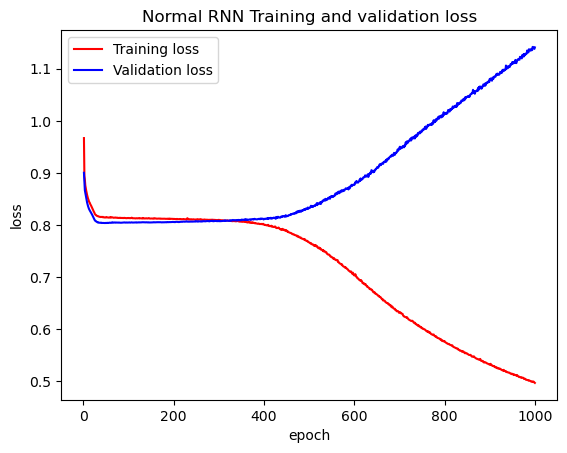

In [18]:
# plot training and validation losses against epochs

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Normal RNN Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()